In [2]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [3]:
%R source('plots/colors.R');

### Notes on the choice of limma-voom over DESeq2:
 - the author of DESeq2 acknowledged that the differences are not significant and provides very through comparative analysis: [blogpost](https://mikelove.wordpress.com/2016/09/28/deseq2-or-edger/), [all plots](https://github.com/mikelove/deseq2_or_edger/blob/master/plots.md), [code](https://github.com/mikelove/deseq2_or_edger)
 - in my empirical experience many scientists oppose the use of limma for RNASeq data, which seems to based be an artifact of the past; granted original limma is worse than many methods for RNASeq data, though for several years now (4? 5?) limma with trend correction/voom has entered the field achieving comparable or better results than most of the methods.
 - this may have been exacerbated by the benchmarking differences in the DESeq2 publication, which as author states in the linked blog post:  
  >  "My original 2014 analysis did not use CPM filtering for edgeR or limma-voom, which should be used for an accurate assessment [...] The figure looks roughly similar to (1 – precision) in Figure 9 of the DESeq2 paper (thresholding at 10% nominal FDR), except the CPM filtering definitely improves the performance of limma-voom."
 - finally, I want to use limma-voom as to have a consistent methodology between proteomic and transcriptomic data and this is the main argument; while I am sure that DESeq2 is better than voom for certain applications, the nice gain of reducing the burden of differences between methods justifies the choice in my opinion.
 
Some support for my sentiment - have a look at https://www.biostars.org/p/284775/#382693 (and my comment); the reply was written 1.5 years ago but uses publication from 2013 - 6 years ago (before the release of DESeq2 and limma-trend/voom!). Conclusion: when releasing an improved method, better change the name...

### Comparative studies for limma/DESeq2:
 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0103207 (2014):
     - does not take limma-voom into account, really outdated
 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0190152 (2018)
     - DESeq2 the best, though only slightly better than limma+voom (F1 0.88 vs 0.85, TPR 0.84 vs 0.81)
     - external validity limited by small number of experimental designs considered (Mike Love’s blog post highlighted that the major difference between the methods is in how they perform against low/large numbers of samples in groups and outliers)
     - authors summary:
       > The NOIseq, DESeq2 and limma+voom methods performed well, with high TPR and ACC rates. The limma+voom tool had already been pointed out in previous works as one of the better results in the DEG ranking and for analyses with more than two samples [22]. NOIseq and DESeq2 tools showed consistent results, indicating these methods are suitable for experiments with a large number of samples and an annotated genome.
     - the authors claim that combining results from five methods is even better than each individual one  (which seems plausible, did not read at critical level yet though)

Inputs:

In [4]:
clinical_deseq2_path = 'data/clean/rna/clinical_data_ordered_to_match_rna_deseq2.csv'
clinical_counts_path = 'data/clean/rna/clinical_data_ordered_to_match_rna_counts.csv'

# normalized counts
deseq2_path = 'data/clean/rna/all_samples.csv'
# raw counts
counts_path = 'data/clean/rna/all_samples_counts.csv'

ensembl_to_entrez_path = 'data/ensembl_to_entrez.csv'

# for comparison
definite_tbm_cm_deg_path = 'data/preliminary_analyses/deg/definite_tbm-cm.csv'
definite_tbm_vm_deg_path = 'data/preliminary_analyses/deg/definite_tbm-vm.csv'

Outputs:

In [5]:
results_path = 'data/preliminary_analyses/differential_rna_expression/'
normalized_counts_path = Path(results_path) / 'normalized_counts'

In [6]:
clinical_deseq2 = read_csv(clinical_deseq2_path, index_col=0)
clinical_counts = read_csv(clinical_counts_path, index_col=0)

raw_deseq2_matrix = read_csv(deseq2_path, index_col=[0, 1])
raw_counts_matrix = read_csv(counts_path, index_col=0)

reference_definite_tbm_cm_deg = read_csv(definite_tbm_cm_deg_path)
reference_definite_tbm_vm_deg = read_csv(definite_tbm_vm_deg_path)

In [7]:
reference_definite_tbm_cm_deg.head()

ensembl_id ensembl_gene_name  \
0  ENSG00000100226            GTPBP1   
1  ENSG00000165997             ARL5B   
2  ENSG00000164691             TAGAP   
3  ENSG00000108771             DHX58   
4  ENSG00000128016             ZFP36   

                                       description     baseMean  \
0                           GTP binding protein 1    580.453924   
1          ADP ribosylation factor like GTPase 5B    222.402492   
2  T-cell activation RhoGTPase activating protein   1023.319959   
3                            DExH-box helicase 58    125.298558   
4                       ZFP36 ring finger protein   2070.881325   

   log2FoldChange     lfcSE      stat        pvalue      padj  
0        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
1        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
2        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
3        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
4        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [8]:
raw_counts_matrix.head()

001.TMD  006.CM  012.BM  016.CM  017.TMD  ...  158.TMD  \
ENSG00000000003      1.0     3.0    2.00   16.00    25.00  ...      0.0   
ENSG00000000005      0.0     0.0    0.00    1.00     0.00  ...      0.0   
ENSG00000000419      0.0    12.0   53.00    0.00    73.00  ...      0.0   
ENSG00000000457     11.0    56.0  123.84   38.72   124.95  ...      0.0   
ENSG00000000460      4.0     0.0   73.16   21.28    15.05  ...      0.0   

                 167.TMR  175.TMD  233.CM  261.CM  
ENSG00000000003      0.0      0.0     0.0   25.00  
ENSG00000000005      0.0      0.0     0.0    5.00  
ENSG00000000419      0.0      0.0     0.0   48.00  
ENSG00000000457      0.0      0.0     0.0  151.94  
ENSG00000000460      0.0      0.0     0.0   37.06  

[5 rows x 56 columns]

In [9]:
# note: this is already limitted to the patients having the RNASeq measurments
by_condition = clinical_deseq2.Meningitis
by_condition_and_tb_subset = clinical_deseq2.Meningitis_with_tuberculosis_status
by_condition_and_tb_subset.head()

001.TMD    Definite tuberculosis
006.CM              Cryptococcal
012.BM                 Bacterial
016.CM              Cryptococcal
017.TMD    Definite tuberculosis
Name: Meningitis_with_tuberculosis_status, dtype: object

In [10]:
%R -i by_condition_and_tb_subset -i by_condition

In [11]:
raw_deseq2_matrix = raw_deseq2_matrix.reset_index()
raw_deseq2_matrix = raw_deseq2_matrix.drop(columns=['ensembl_gene_id']).set_index('ensembl_id')

## Using DESeq2 normalized counts

### What are the DESeq2 normalized counts?

In [12]:
%%R
import::here(space_to_dot, dot_to_space, remove_leading_X, .from='helpers/utilities.R')

In [13]:
%%R -i raw_counts_matrix -i raw_deseq2_matrix
colnames(raw_counts_matrix) = remove_leading_X(colnames(raw_counts_matrix))
colnames(raw_deseq2_matrix) = remove_leading_X(colnames(raw_deseq2_matrix))

In [14]:
raw_deseq2_matrix.head(n=2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ensembl_id                                                            ...   
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ensembl_id                                                          
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

In [15]:
raw_counts_matrix.head(n=2)

001.TMD  006.CM  012.BM  016.CM  017.TMD  ...  158.TMD  \
ENSG00000000003      1.0     3.0     2.0    16.0     25.0  ...      0.0   
ENSG00000000005      0.0     0.0     0.0     1.0      0.0  ...      0.0   

                 167.TMR  175.TMD  233.CM  261.CM  
ENSG00000000003      0.0      0.0     0.0    25.0  
ENSG00000000005      0.0      0.0     0.0     5.0  

[2 rows x 56 columns]

As expected, there is a considerable difference between the "raw" RSEM counts and the DESeq2 normalized counts: 

In [16]:
%%R
reference_samples = colnames(raw_deseq2_matrix)
reference_genes = rownames(raw_deseq2_matrix)

raw_counts_trimmed = raw_counts_matrix[reference_genes, reference_samples]

relative_mean_diff = function(a, b) {
    ma = mean(rowMeans(a))
    mb = mean(rowMeans(b))
    mean(rowMeans(
        abs(a / ma - b / mb) * 100,
    ))
}

relative_mean_diff(raw_deseq2_matrix, raw_counts_trimmed)

[1] 61.80482


#### Can I recreate the DESeq2 normalization?

In [17]:
%%R
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]

dds <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_trimmed),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
# DESeq call can be skipped, as it performs dispersion estimation
# and GLM fitting which are not required for size estimation,
# see https://support.bioconductor.org/p/109586/
# dds <- DESeq2::DESeq(dds)
dds <- DESeq2::estimateSizeFactors(dds)

converting counts to integer mode
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]


In [18]:
%%R -o normalized_counts
normalized_counts = as.data.frame(DESeq2::counts(dds, normalized=TRUE))

In [19]:
%%R
relative_mean_diff(raw_deseq2_matrix, normalized_counts)

[1] 9.977589e-09


Yes. This is exactly what I was given.

I understand that the very small difference is due to rounding precision and the file being exported to Excel and then imported in Python; on the high level the values are close enough though:

In [20]:
np.allclose(normalized_counts.values, raw_deseq2_matrix.values)

True

In [21]:
normalized_counts.head(2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

In [22]:
raw_deseq2_matrix.head(2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ensembl_id                                                            ...   
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ensembl_id                                                          
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

The normalization shown above [corresponds to](https://support.bioconductor.org/p/66067/):

In [23]:
%%R -o counts_normalized_manually
counts_normalized_manually = as.data.frame(DESeq2::counts(dds) / DESeq2::sizeFactors(dds))

Notably, these normalised counts are not really used so much in the actual DESeq2 method, just for the mean-variance trend estimation:

> The point of the software and other count-based methods is to model the raw counts, so that estimation steps take into account the variance profile of counts. If you look over the methods, you'll see that almost all steps use K_ij which is the raw count for gene i and sample j. The normalized counts K_ij/s_j are only used to give each gene a single mean value for the dispersion trend regression (equation 5). [https://support.bioconductor.org/p/66067/#66081]

And the size factors are computed using:
> "median ratio method" described by Equation 5 in Anders and Huber (2010) [(DESeq2 documentation, estimateSizeFactors)](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/estimateSizeFactors)

The size factors are meant to make counts for different samples (patients) comparable; DESeq uses median of ratios of counts to geometric mean of counts in each sample [(Anders and Huber, 2010)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-10-r106):

$$\hat s_j = \text{median}_{i=1}^n \frac{k_{i,j}}{\left(\prod^m_{v=1} k_{i,v}\right)^{1/m}}$$

where:
 - $i$ indexes genes ($n$ in total)
 - $j$ and $v$ indexes samples, $m$ in total
 - $k_{i,j}$ represents raw count for gene $i$ and sample $j$

### Filtering and normalization

Using protocol from limma's User Guide:

In [24]:
%%R
import::here(
    design_from_conditions, calculate_means, limma_fit, contrasts_fit,
    .from='helpers/differential_expression.R'
)

In [25]:
%%R
dge_all <- edgeR::DGEList(counts=raw_deseq2_matrix, group=by_condition)
design = design_from_conditions(by_condition, intercept=F)
length(rownames(dge_all))

[1] 38664


Keeping most of the genes. Note this is not fully valid given that this function was written for raw counts data, not normalized data.

In [26]:
%%R
keep <- edgeR::filterByExpr(dge_all, design)
sum(keep) / length(rownames(dge_all)) * 100

[1] 94.54531


In [27]:
%%R
dge <- dge_all[keep,,keep.lib.sizes=FALSE]

Normal procedure for limma/edgeR adds TMM normalization factors now, but since we already have normalized counts I will skip this step.

**Note 1 (TMM)**: TMM stands for *trimmed mean of M-values* which was introduced by [(Robinson and Oshlack, 2010)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25); it is calculated by `edgeR::calcNormFactors` in limma's pipeline. The goal is the same as for the median normalization in DESeq2.

**Note 2 (comparable)**: 
The TMM and DESeq's median based normalization (sometimes called "Relative Log Expression" RLE) were shown to give very comparable results in simulation studies [(Maza, 2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3918003/) [see table 2] and [(Dillies et al, 2012)](https://academic.oup.com/bib/article/14/6/671/189645) [see table 3] and may produce equivalent results under some additional assumptions [(Maza, 2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5025571/).

**Note 3 (assumptions)**: Both assume that they can capture the scaling factor from the non-differentially expressed genes (see [here](https://support.bioconductor.org/p/63630/) for some more intuition). **This could be a problem in our study design...** But do we have anything better?

### Transformation

The TMM normalization factors would be used by `edgeR::cpm` now; however, as in this case the counts are already normalized I will use simpler, equivalent log2-transformation (corresponds to `edgeR::cpm(dge, log=T, prior.count=0.25)`)

In [28]:
%%R
log_cpm = log2(dge$counts + 0.25)

**Note**: previously I was adding `eps = .Machine$double.eps` as a damping factor and the very low numbers (while not technically zero) were the cause of the "stripy" patterns in average log-expression/variance:
because these led to high negative log-expression values, the quantification of read counts started to emerge on the x axis: the damping factor not only prevents the infinite values of the log function, but also "attracts" the values for counts closer together.

In [29]:
%R head(as.data.frame(log_cpm), n=2)

001.TMD    006.CM    012.BM    016.CM   017.TMD  ...  \
ENSG00000000003  3.566343  3.010119  0.715063  5.307333  4.644722  ...   
ENSG00000000005 -2.000000 -2.000000 -2.000000  1.437872 -2.000000  ...   

                   174.CM   011.TMR   043.TMS  078.CM    261.CM  
ENSG00000000003  2.226839  5.702116  5.165053    -2.0  4.389261  
ENSG00000000005 -2.000000  3.504906 -2.000000    -2.0  2.134586  

[2 rows x 49 columns]

### Fitting

#### Assessing the the mean-variance relation

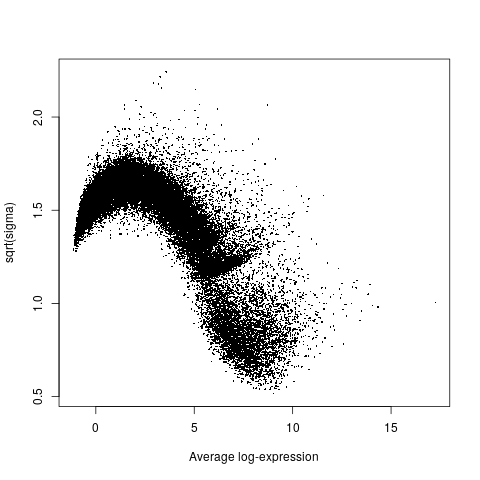

In [30]:
%%R
fit <- limma_fit(data=log_cpm, conditions=by_condition, a='Tuberculosis', b='Cryptococcal')
limma::plotSA(fit)

It looks ok, though the cut-off might have been more stringent. There is one suspected outlier (very highly expressed gene), but this one seems to be present across samples (see the raw-counts analysis).

In [31]:
%%R
limma_dge = function(a, b, data, conditions, ...) {
    raw_fit <- limma_fit(data=data, conditions_vector=conditions, a=a, b=b)
    fit <- limma::eBayes(raw_fit, trend=T, robust=T)
    limma::topTable(fit, ...)
}

In [32]:
%R limma_dge('Tuberculosis', 'Cryptococcal', log_cpm, by_condition)

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000241313 -3.750636  1.848536 -4.984593  0.000004   0.116133  3.683285
ENSG00000280809 -3.551704  1.393227 -4.891309  0.000006   0.116133  3.388815
ENSG00000179412 -3.687491  0.189983 -4.743796  0.000011   0.134419  2.927865
ENSG00000266486 -3.409226  0.586013 -4.453012  0.000032   0.138453  2.037845
ENSG00000271397 -3.137736  0.096760 -4.436862  0.000034   0.138453  1.989197
ENSG00000264714 -3.703843  2.563455 -4.395959  0.000039   0.138453  1.866380
ENSG00000187848 -3.289822  0.776672 -4.373313  0.000043   0.138453  1.798626
ENSG00000272975 -3.592755  1.430871 -4.358725  0.000045   0.138453  1.755073
ENSG00000224791 -3.359333  0.902272 -4.342054  0.000048   0.138453  1.705393
ENSG00000158163 -3.175936  3.185874 -4.334336  0.000049   0.138453  1.682425

The adjusted p-values seem relatively high.

#### Comparing top genes called by limma and by DESeq2

In [33]:
%%R -o definite_tb_cm
definite_tb_cm = limma_dge('Definite tuberculosis', 'Cryptococcal', log_cpm, by_condition_and_tb_subset, n=15)

In [34]:
definite_tb_cm

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000104415 -4.554774  3.116708 -5.510924  6.026732e-07   0.022031   
ENSG00000231768 -4.365053  2.347671 -4.731515  1.178258e-05   0.205418   
ENSG00000100226  1.024016  8.934570  4.634202  1.685828e-05   0.205418   
ENSG00000117298  1.416507  8.918096  4.548234  2.466147e-05   0.225375   
ENSG00000213568 -3.904801  0.613604 -4.417650  3.696268e-05   0.270234   
...                   ...       ...       ...           ...        ...   
ENSG00000261812 -3.670228  2.475171 -4.067754  1.264545e-04   0.324247   
ENSG00000185875 -3.661298  3.368061 -4.061585  1.291673e-04   0.324247   
ENSG00000143028 -3.382007  3.544580 -4.061208  1.293350e-04   0.324247   
ENSG00000238099 -3.544111  1.510469 -4.057070  1.311887e-04   0.324247   
ENSG00000155363  1.219986  8.529577  4.043097  1.376380e-04   0.324247   

                        B  
ENSG00000104415  4.849606  
ENSG00000231768  2.539558  
ENSG00000100226  2.260183  
ENSG00000117298  1.962215  
ENSG00000213568  1.647534  
...                   ...  
ENSG00000261812  0.687512  
ENSG00000185875  0.670953  
ENSG00000143028  0.669940  
ENSG00000238099  0.658838  
ENSG00000155363  0.621400  

[15 rows x 6 columns]

The p-values are lower (possibly we get more consistent support for these DEGs) while the adjusted p-values get higher (possibly due to fewer samples giving the support).

In [35]:
reference_definite_tbm_cm_deg.head()

ensembl_id ensembl_gene_name  \
0  ENSG00000100226            GTPBP1   
1  ENSG00000165997             ARL5B   
2  ENSG00000164691             TAGAP   
3  ENSG00000108771             DHX58   
4  ENSG00000128016             ZFP36   

                                       description     baseMean  \
0                           GTP binding protein 1    580.453924   
1          ADP ribosylation factor like GTPase 5B    222.402492   
2  T-cell activation RhoGTPase activating protein   1023.319959   
3                            DExH-box helicase 58    125.298558   
4                       ZFP36 ring finger protein   2070.881325   

   log2FoldChange     lfcSE      stat        pvalue      padj  
0        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
1        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
2        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
3        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
4        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [36]:
top_reference = reference_definite_tbm_cm_deg.head(15).ensembl_id
top_limma = definite_tb_cm.index

In [37]:
intersection = set(top_reference) & set(top_limma)
intersection

{'ENSG00000100226',
 'ENSG00000108771',
 'ENSG00000117298',
 'ENSG00000155363',
 'ENSG00000185507'}

5 out of 15 - not bad; however the only "significant" gene: ENSG00000104415 was not scored as high by DESeq2; was it deemed significant at all?

In [38]:
reference_definite_tbm_cm_deg.set_index('ensembl_id').loc[['ENSG00000104415']]

ensembl_gene_name  \
ensembl_id                          
ENSG00000104415             WISP1   

                                                 description  baseMean  \
ensembl_id                                                               
ENSG00000104415  WNT1 inducible signaling pathway protein 1   22.30457   

                 log2FoldChange     lfcSE      stat    pvalue  padj  
ensembl_id                                                           
ENSG00000104415       -2.882794  0.623437 -4.624037  0.000004   NaN

Well... what does NaN mean for adjusted p-value?

> If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p value will be set to  NA. Description and customization of independent filtering is described below 
> [(DESeq2 vignette)](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

So the independent filtering is an interesting way (or trick) of decreasing the FDR/adjusted p-value by disregarding some hypotheses upfront. The criterion used by DESeq2 is having a small number of normalized counts (regardless of the condition). For more details see the plot and explanation in the [DESeq2 vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilttheory).

## Using RSEM counts

These counts are RSEM gene-level expected counts. Can we use limma-voom on RSEM rather than on raw counts?
Yes.

> If you are working with RSEM gene-level expected counts, then you can just pass them to limma as if they were counts. That's what we do. \[limma's author answering [this Bioconductor question](https://support.bioconductor.org/p/84749/#84807)\]

Side note: another, related answer from prof Gordon: https://support.bioconductor.org/p/91054/#91098 highlights use of `normalizeQuantiles` when applying limma to log(counts), but this is not needed for this project generally (as in any case we can proceed with TMM/RLE normalization).

### Outliers

#### Removing patients without clinical data?

The raw counts have for a few patients excluded from initial version of clinical dataset as those were marked as outliers:

In [39]:
patients_initially_excluded = ['233.CM', '167.TMR', '158.TMD']

In [40]:
samples = read_csv('data/clean/samples_list.csv')

assert all(p not in set(samples.sample_id) for p in patients_initially_excluded)

However, data for those patients were added for consistency:

In [41]:
assert all(p in set(clinical_counts.index) for p in patients_initially_excluded)

Let's investigate library sizes of these samples:

In [42]:
patients_absent_in_clinical_data = patients_initially_excluded
patients_absent_in_processsed_counts = set(raw_counts_matrix.columns) - set(raw_deseq2_matrix.columns)

In [43]:
sizes = raw_counts_matrix.sum().to_frame('library_size').reset_index()
sizes['label'] = np.where(
    sizes['index'].isin(patients_absent_in_processsed_counts),
    sizes['index'], ''
)
absent_samples = (
    set(patients_absent_in_clinical_data)
    |
    set(patients_absent_in_processsed_counts)
)
sizes['status'] = sizes.apply(lambda sample: (
    'Present'
    if sample['index'] not in absent_samples else
    (
        'Excluded in inital clinical datasheet'
        if sample['index'] in patients_absent_in_clinical_data else
        'Absent in processed counts'
    )
), axis=1)

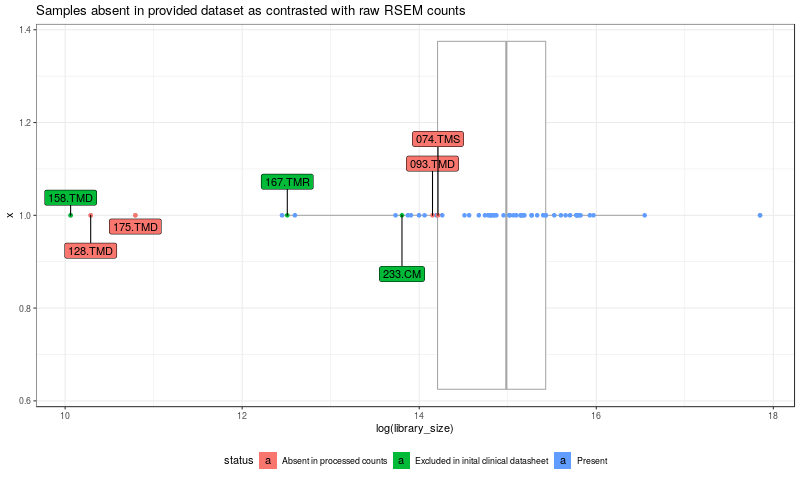

In [44]:
%%R -i sizes -w 800
set.seed(0)
(
    ggplot(sizes, aes(x=1, y=log(library_size), label=label))
    + nice_theme
    + geom_boxplot(color='grey65')
    + geom_point(aes(color=status))
    + coord_flip()
    + ggrepel::geom_label_repel(aes(fill=status), force=6, direction="y")
    + ggtitle('Samples absent in provided dataset as contrasted with raw RSEM counts')
)

Removal of `158.TMD` seems easily warranted (law library size). Not sure about others though.

While I could deduce the subgroup, I am not certain if I should be using these..
I will discard the three patients without the data for now as it is easier to include them later than rewrite to discard:

In [45]:
without_absent = 'index not in @patients_initially_excluded'

clinical_counts_subset = clinical_counts.query(without_absent)
raw_counts_matrix_subset = raw_counts_matrix.T.query(without_absent).T

In [46]:
c_by_condition = clinical_counts_subset.Meningitis
c_by_condition_and_tb_subset = clinical_counts_subset.Meningitis_with_tuberculosis_status

In [47]:
%R -i c_by_condition -i c_by_condition_and_tb_subset -i raw_counts_matrix_subset

#### Comparison to samples (patients) removed for DESeq2

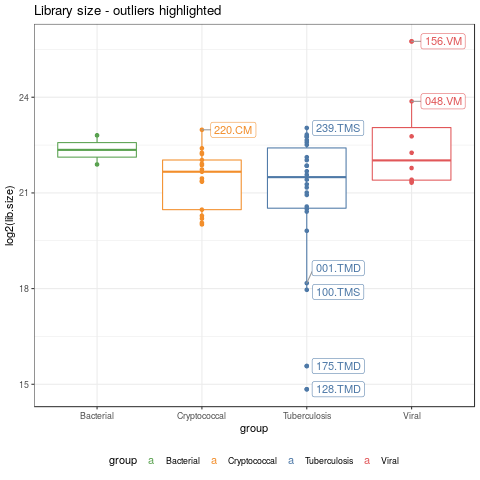

In [48]:
%%R
f_dge <- edgeR::DGEList(counts=raw_counts_matrix_subset, group=c_by_condition)
samples = f_dge$samples
sample_names = remove_leading_X(rownames(samples))
sample_size = log2(samples$lib.size)
samples$sample = ifelse(sample_size > 22.9 | sample_size < 19, sample_names, '')
(
    ggplot(samples, aes(color=group, x=group, y=log2(lib.size), label=sample))
    + geom_boxplot() + geom_point()
    + ggrepel::geom_label_repel(force=6, nudge_x=0.3, segment.color='grey60')
    + scale_color_manual(values=patient_colors$Meningitis)
    + nice_theme
    + ggtitle('Library size - outliers highlighted')
)

In [49]:
set(raw_counts_matrix.columns) - set(raw_deseq2_matrix.columns)

{'074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '175.TMD', '233.CM'}

In [50]:
set(raw_counts_matrix_subset.columns) - set(raw_deseq2_matrix.columns)

{'074.TMS', '093.TMD', '128.TMD', '175.TMD'}

For DESeq2 four samples more were excluded:
- I understand exclusion of `175.TMD` and `128.TMD` (very low library size)
- I was not sure why `093.TMD` and `074.TMS` were excluded; dr Rachel provided criteria as follows:
  - Rows (gene) filter
    - Expression threshold (min. read count) = 1
    - Required percentage (min. percentage of columns/samples required to pass the expression threshold) = 25
  - Column (sample) filter
    - Expression threshold = 1
    - Required percentage (min. percentage of genes required to pass the threshold) = 50

While I was not able to exactly replicate the results in Python, the samples that I filtered using this criteria are a superset of the missing samples, so it seems ok:

In [51]:
gene_filtered = raw_counts_matrix.iloc[list((raw_counts_matrix >= 1).apply(mean, axis=1) >= 0.25),:]
sample_filtered = gene_filtered.iloc[:,list((gene_filtered >= 1).apply(mean) >= 0.5)]
set(raw_counts_matrix_subset.columns) - set(sample_filtered.columns)

{'028.TMR', '043.TMS', '074.TMS', '093.TMD', '128.TMD', '149.TMD', '175.TMD'}

Also, using 40% works:

In [52]:
gene_filtered = raw_counts_matrix.iloc[list((raw_counts_matrix >= 1).apply(mean, axis=1) >= 0.25),:]
sample_filtered = gene_filtered.iloc[:,list((gene_filtered >= 1).apply(mean) >= 0.4)]
set(raw_counts_matrix_subset.columns) - set(sample_filtered.columns)

{'074.TMS', '093.TMD', '128.TMD', '175.TMD'}

Sanity check: there should be no additional samples in the DESeq2 normalized counts:

In [53]:
assert not set(raw_deseq2_matrix.columns) - set(raw_counts_matrix.columns)

#### Outlier detection will be continued

Given low number of samples and the fact that both limma-voom and DESeq2 can correct for the library size I would be conservative in outlier removal and only remove `128.TMD`, `158.TMD` and `175.TMD` based on the very low library sizes; however it seems alarming that all of these belong to TMD group.

A simple hierarchical clustering confirms that these samples group together due to low absolute expression values:

In [54]:
%R library(pheatmap);

In [55]:
from plots.annotations import generate_patient_annotations

In [56]:
clinical_full = clinical_counts
full_by_condition = clinical_full.Meningitis
full_by_condition_and_tb_subset = clinical_full.Meningitis_with_tuberculosis_status

In [57]:
counts_patient_annotations = generate_patient_annotations(clinical_full)

In [58]:
%%R -i counts_patient_annotations

names(counts_patient_annotations) = dot_to_space(names(counts_patient_annotations))
colnames(raw_counts_matrix) <- remove_leading_X(colnames(raw_counts_matrix))

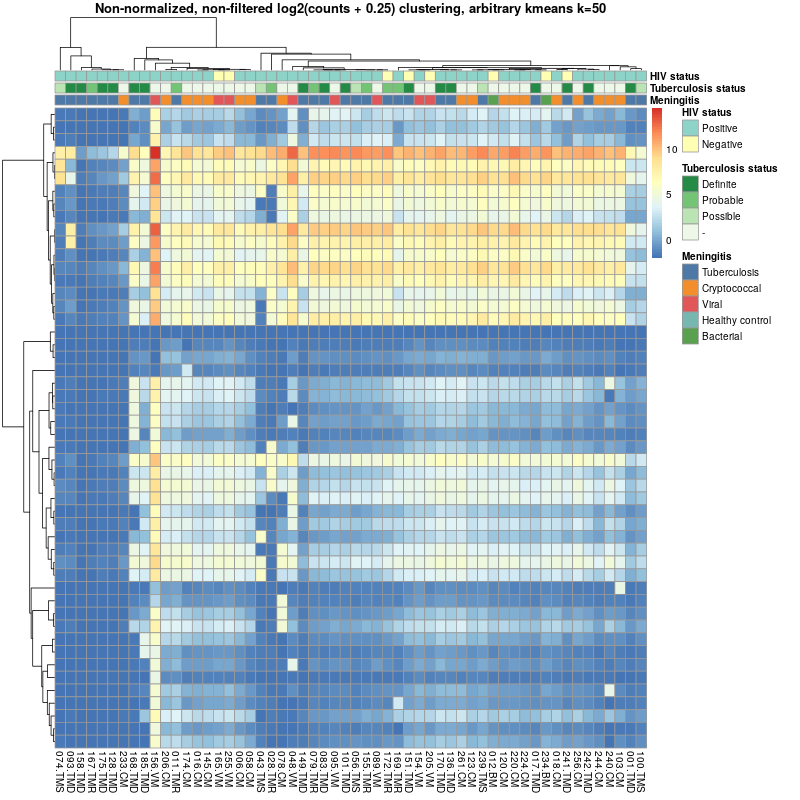

In [59]:
%%R -w 800 -h 800 -i gene_filtered 
set.seed(0)

full_counts_clusters = pheatmap(
    log2(raw_counts_matrix + 0.25),
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='Non-normalized, non-filtered log2(counts + 0.25) clustering, arbitrary kmeans k=50'
)

The four columns to the right does not look right...

However, such analysis is not very informative due to library size differences - I will continue with outlier detection using filtered and normalized data.

### Gene filtering

Note: the filtering uses the design vector, thus it might seem that it needs to be repeated for the designs with and without use of the TB subsets (possible, probable, definite).

However, as the filtering procedure uses the criteria based on the smallest number of samples (patients) in each condition, the viral condition is always the smallest (has less patients than each of the TB subgroups) so the filtering result should be the same:

By default `filterByExpr` requires at least 10 (`min.count`) reads (scaled to library size) in at least $n$ samples where $n$ is determined by the number of samples in smallest groups (n >= 70% |size of smallest group|). For us this is $n \ge 0.7 * 8 \approx 6$ samples. Additionally minimum 15 (`min.count.total`) reads per gene are required in total. But is it?

In [60]:
full_by_condition.value_counts()

Tuberculosis    28
Cryptococcal    18
Viral            8
Bacterial        2
Name: Meningitis, dtype: int64

In [61]:
full_by_condition_and_tb_subset.value_counts()

Cryptococcal             18
Definite tuberculosis    16
Viral                     8
Probable tuberculosis     7
Possible tuberculosis     5
Bacterial                 2
Name: Meningitis_with_tuberculosis_status, dtype: int64

The problem is that using the current design there are also two other bacterial samples, which reduce the samples count threshold (instead of \*8 we have just \*2), which makes the filtering less stringent.

In [62]:
%%R -i full_by_condition -i full_by_condition_and_tb_subset
c_dge <- edgeR::DGEList(counts=raw_counts_matrix, group=full_by_condition)
c_dge_subset <- edgeR::DGEList(counts=raw_counts_matrix, group=full_by_condition_and_tb_subset)

import::here(filter_out_low_expression, .from='helpers/differential_expression.R')

Therefore, I opt to modify the design at this point to trick `filterByExpr` to calculate $n$ as $\ge 0.7 * 8$:

In [63]:
dummy_condition_vector = full_by_condition.replace('Bacterial', 'Tuberculosis')

In [64]:
dummy_condition_vector_for_subet = full_by_condition_and_tb_subset.replace('Bacterial', 'Definite tuberculosis')

In [65]:
min(dummy_condition_vector.value_counts())

8

In [66]:
min(dummy_condition_vector_for_subet.value_counts())

5

In [67]:
%%R -i dummy_condition_vector
c_dge_tb_together_filtered = filter_out_low_expression(c_dge, dummy_condition_vector);

[1] "Retaining: 50.51%"


In [68]:
%%R -i dummy_condition_vector_for_subet
c_dge_tb_subsets_filtered = filter_out_low_expression(c_dge_subset, dummy_condition_vector_for_subet);

[1] "Retaining: 55.12%"


Whereas, without the change we would get (the counts are identical as in both cases the bacterial "2" was limiting $n$):

In [69]:
%R c_dge_tb_together_permissively_filtered = filter_out_low_expression(c_dge, full_by_condition);

[1] "Retaining: 71.59%"


In [70]:
%R c_dge_tb_subsets_permissively_filtered = filter_out_low_expression(c_dge_subset, full_by_condition_and_tb_subset);

[1] "Retaining: 71.59%"


In other words, I will use the bacterial group to improve the trend predictions, but not for filtering as this is not a group of primary interest.

This provides a nice mean-variance relation plot (which is not as good when using less stringent filtering with the bacterial group):

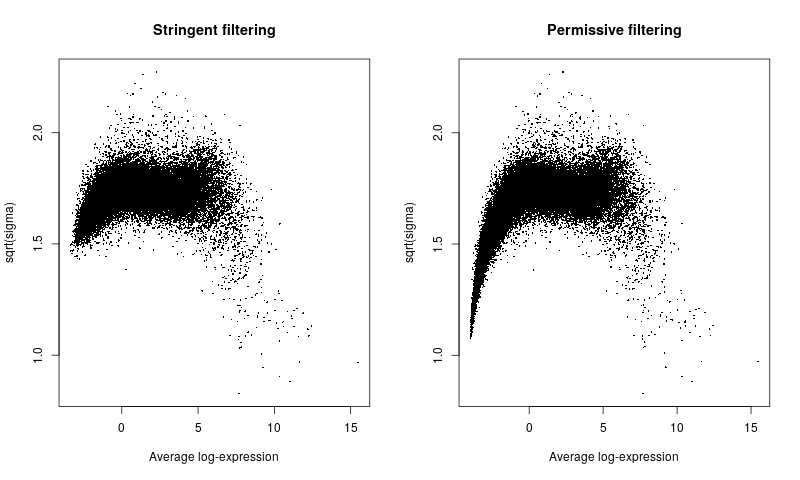

In [71]:
%%R -w 800
par(mfrow=c(1,2))

logCPM <- edgeR::cpm(c_dge_tb_subsets_filtered, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit)
title('Stringent filtering')


logCPM <- edgeR::cpm(c_dge_tb_subsets_permissively_filtered, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit)
title('Permissive filtering')

The "niceness" is defined by the lack of the initial turn of the relation to the left-down corner (i.e. the genes with little reads which are less variable due to numerical properties (negative binomial) do not misguide the relation). See [this comment](https://support.bioconductor.org/p/85511/#85639) for intuition.

Note: the approach mentioned [here](https://support.bioconductor.org/p/85511/#85514) has been recently (well, two years ago - 2017) automated in edgeR and roughly corresponds to `edgeR::filterByExpr`.

There were below 6000 raw counts:

In [72]:
len(raw_counts_matrix)

58233

The dataset provided to DESeq2 was filtered to:

In [73]:
len(raw_deseq2_matrix)

38664

And our strict filtering gives comparable results (with slightly fewer genes remaining):

In [74]:
%R nrow(c_dge_tb_subsets_filtered$counts)

array([32098], dtype=int32)

In [75]:
%R nrow(c_dge_tb_together_filtered$counts)

array([29411], dtype=int32)

### The outlier to the right

We still have an outlier here (at 15) as we only filtered out the lowly expressed genes. Now, can we remove it? Is it of any benefit?
- Rather not, as I use "robust" version and the limma's author agues it is robust enough [link]
- Maybe, because this outlier may affect the trend estimate

TODO: I lost the link!

So what do we see exactly?

In [76]:
%%R
l = rowMeans(logCPM)
head(l[l > 15])

ENSG00000251562 
       15.48669 


In [77]:
from helpers.ensembl import Ensembl

ensembl = Ensembl(95)
get_gene = ensembl.get_gene

In [78]:
ensembl.gene_by_id('ENSG00000251562')

Gene(gene_id='ENSG00000251562', gene_name='MALAT1', biotype='lincRNA', contig='11', start=65497688, end=65506516, strand='+', genome='GRCh38')

I've got no idea why.. Is this condition-dependent anyhow?

In [79]:
%%R
malat1 = data.frame(
    condition=full_by_condition_and_tb_subset,
    malat1=logCPM['ENSG00000251562',]
)

In [80]:
%R head(malat1)

condition     malat1
001.TMD  Definite tuberculosis  15.945300
006.CM            Cryptococcal  14.883386
012.BM               Bacterial  15.734177
016.CM            Cryptococcal  15.659558
017.TMD  Definite tuberculosis  16.132236
018.CM            Cryptococcal  15.930723

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


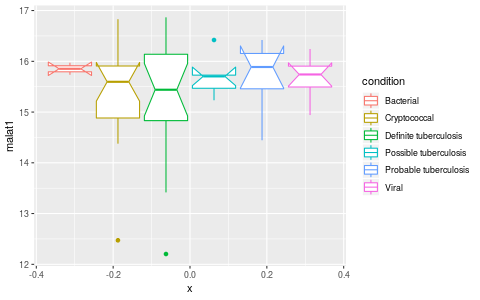

In [81]:
%%R -h 300
ggplot(malat1, aes(y=malat1, color=condition, x=0)) + geom_boxplot(notch=T)

(looking at notches) we cannot confidently say that this is differential.

Was it included in DESeq2 processed dataset?

In [82]:
'ENSG00000251562' in set(raw_deseq2_matrix.reset_index().ensembl_id)

True

Will this **really** improve the trend if we remove it?

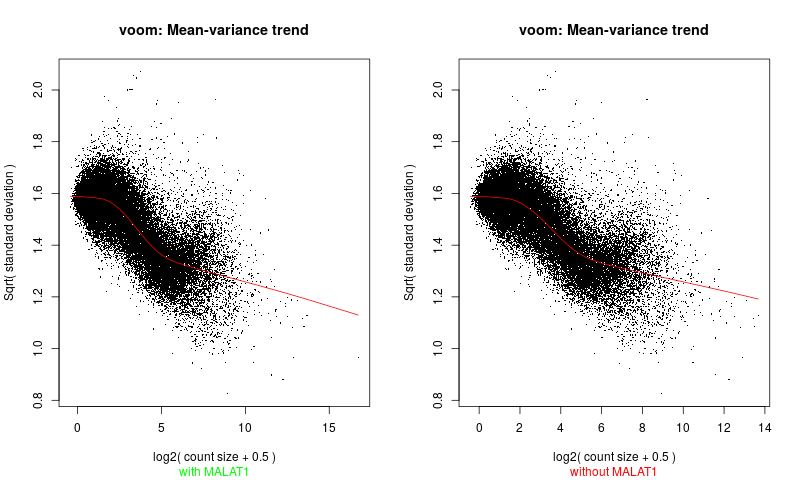

In [83]:
%%R -w 800
c_dge_ts_f <- c_dge_tb_subsets_filtered

dge_without_outlier = c_dge_ts_f[rownames(c_dge_ts_f) != 'ENSG00000251562',]
design = design_from_conditions(full_by_condition_and_tb_subset)
par(mfrow=c(1,2))
v = limma::voom(c_dge_ts_f, design, plot=TRUE); title(sub='with MALAT1', col.sub='green')
v = limma::voom(dge_without_outlier, design, plot=TRUE); title(sub='without MALAT1', col.sub='red')

No, not really - just a little bit.

### Normalization

Adding TMM normalization/scaling factors:

In [84]:
%%R
c_dge_tb_subsets_filtered_norm <- edgeR::calcNormFactors(c_dge_tb_subsets_filtered)
c_dge_tb_together_filtered_norm <- edgeR::calcNormFactors(c_dge_tb_together_filtered) 

In [282]:
%%R
c_dge_tb_subsets_filtered$samples$norm.factors = dge_norm$norm.factors
logCPM_tcc <- edgeR::cpm(c_dge_tb_subsets_filtered, log=TRUE, prior.count=0.25)

In [240]:
%%R
rle <- edgeR::calcNormFactors(c_dge_tb_subsets_filtered, 'RLE') 

In [267]:
%%R
print(all(c_dge_tb_subsets_filtered_norm$samples$norm.factors == dge_norm$samples$norm.factors))
dge_norm$samples$norm.factors

[1] TRUE
 [1] 1.1027791 1.3795982 0.8412453 1.2759954 0.7136337 0.9360285 1.2605779
 [8] 0.7989971 0.7664770 1.4223723 0.6479348 0.4874155 0.7241773 2.0791945
[15] 0.5449614 1.9634400 0.5491589 0.9472882 0.7853420 0.6606435 4.7683228
[22] 0.9632048 1.3111136 0.9895512 0.7934271 0.8240855 0.7151195 0.9482852
[29] 1.0892278 1.5372776 0.9291655 0.8820616 0.7734318 0.7342355 0.6582339
[36] 0.5183558 0.6011739 1.2574567 0.7899231 0.9498440 1.1008888 1.1505000
[43] 1.1314743 0.8892942 1.8302373 2.1076256 1.2768344 1.5021284 1.6008293
[50] 2.1105982 1.1750459 1.0431089 0.1203898 1.1246284 2.6597193 1.0848866


### Transformation

Note: if we were to lowering the `prior.count`, the "stripy" pattern will emerge (I suspect that it highlights individual counts - uncovering discretization):

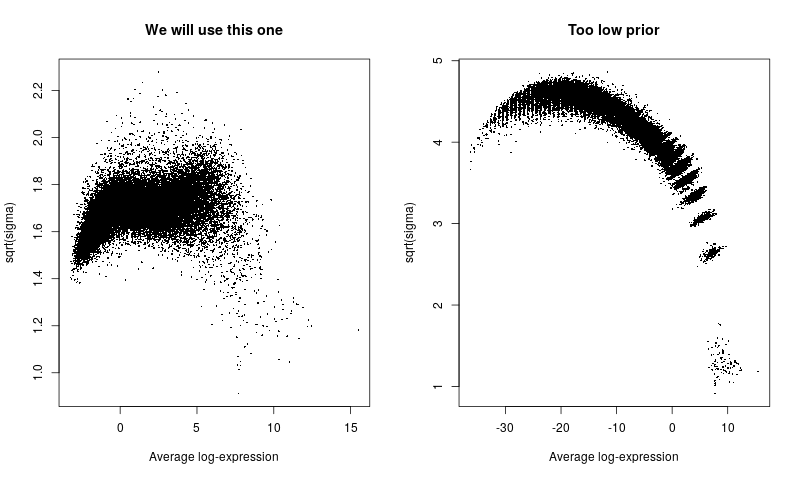

In [85]:
%%R -w 800
par(mfrow=c(1,2))

c_dge_ts_f_n <- c_dge_tb_subsets_filtered_norm

logCPM <- edgeR::cpm(c_dge_ts_f_n, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit); title('We will use this one')
        
low_logCPM <- edgeR::cpm(c_dge_ts_f_n, log=TRUE, prior.count=0.000000000001)
low_raw_fit = limma_fit(data=low_logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(low_raw_fit); title('Too low prior')

### Outlier detection continued

TODO: due to lack of clinical annotations for three samples I am using trimmed data here - this will be updated on Wednesday

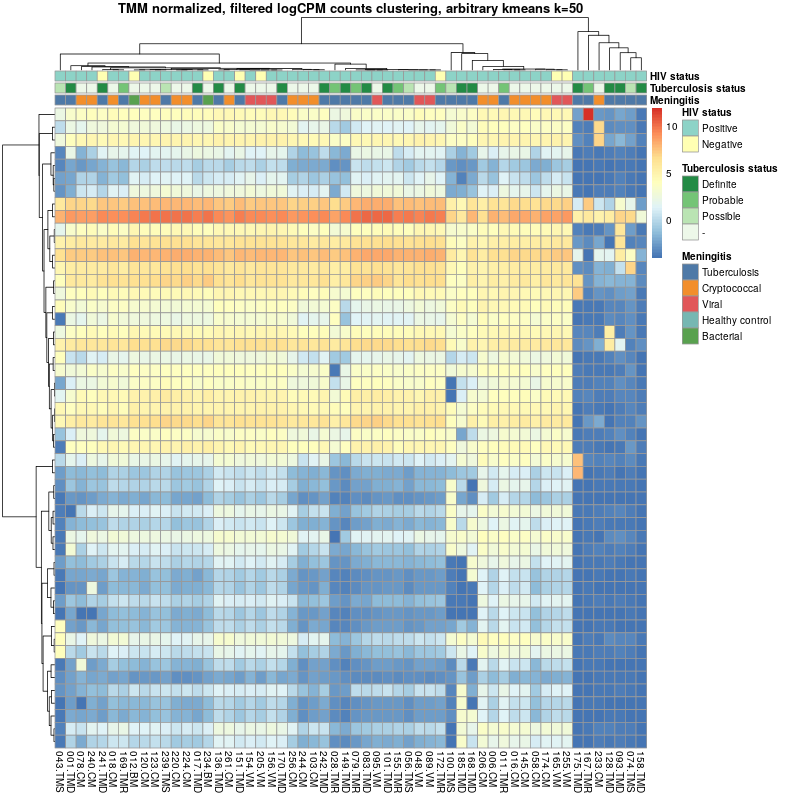

In [86]:
%%R -w 800 -h 800
set.seed(0)

full_counts_clusters = pheatmap(
    logCPM,
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='TMM normalized, filtered logCPM counts clustering, arbitrary kmeans k=50'
)

The divergence of the samples: 175, 074, 093, 128, 158, 233 supports the case for their removal.

In [87]:
%R library(factoextra);

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


In [88]:
%%R
pca = prcomp(t(logCPM), scale=F)

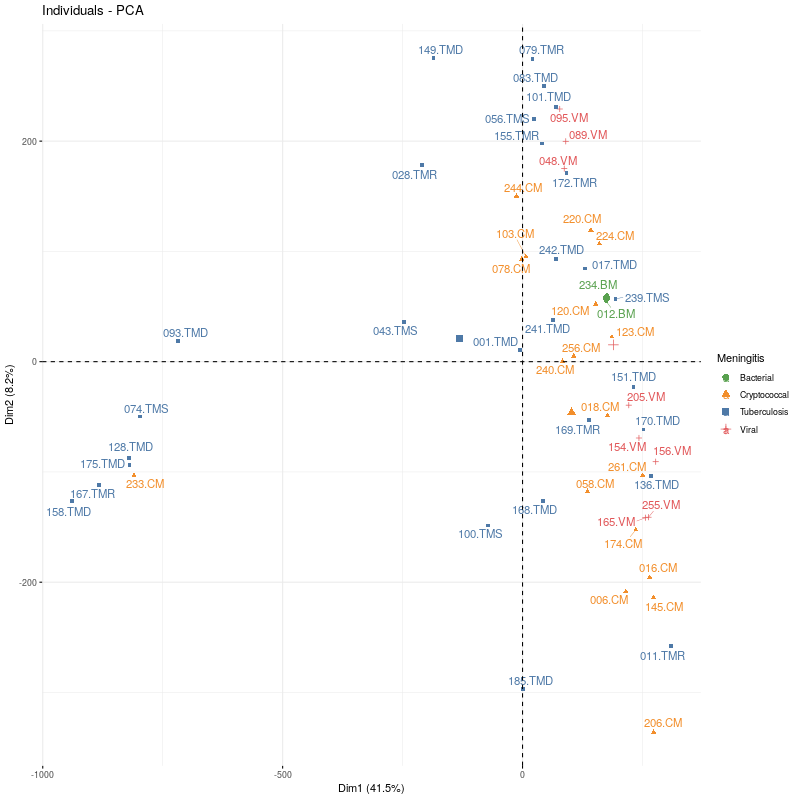

In [89]:
%%R -w 800 -h 800 -u px
fviz_pca_ind(
    pca,
    repel=T,
    col.ind=counts_patient_annotations[colnames(logCPM),]$Meningitis,
    palette=patient_colors$Meningitis
) +  guides(shape=guide_legend(title='Meningitis'), color=guide_legend(title='Meningitis'))

And PCA agrees.

[Some](https://www.biostars.org/p/281767/#281827) recommend |z-score| > 3 for outlier detection. The proposed outliers do not meet this threshold - though they are clearly above two standard deviations away:

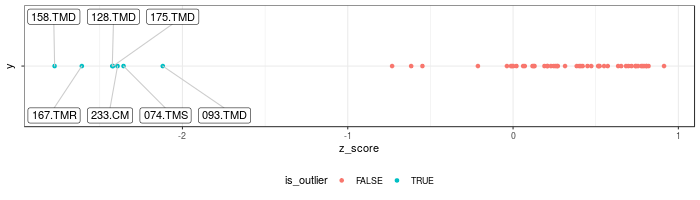

In [90]:
%%R -h 200 -w 700
df = data.frame(z_score=scale(pca$x)[,'PC1'], sample=rownames(pca$x))
df$is_outlier = abs(df$z_score) > 2
(
    ggplot(df, aes(x=z_score, label=sample, y='', color=is_outlier))
    + geom_point()
    + ggrepel::geom_label_repel(data=df[df$is_outlier,], nudge_y=c(-1,1), segment.color='grey80', color='black')
    + nice_theme
)

#### What if we change the normalization method?

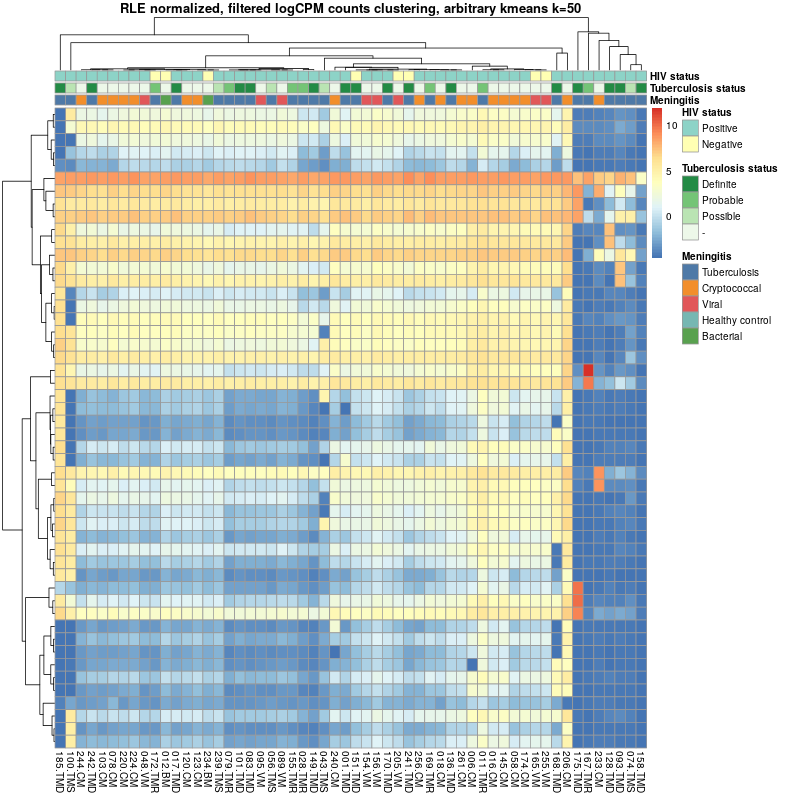

In [90]:
%%R -w 800 -h 800

dge_norm_as_if_dseq2 <- edgeR::calcNormFactors(c_dge_tb_subsets_filtered, method='RLE')
cpm_norm_as_if_dseq2 <- edgeR::cpm(dge_norm_as_if_dseq2, log=TRUE, prior.count=0.25)
        
set.seed(0)

full_counts_clusters = pheatmap(
    cpm_norm_as_if_dseq2,
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='RLE normalized, filtered logCPM counts clustering, arbitrary kmeans k=50'
)

TODO: Treatment status!

The outliers are still visible.

### Removing 175.TMD, 074.TMS, 093.TMD, 128.TMD, 158.TMD, 167.TMR and 233.CM

In [294]:
%%R -o outliers
outliers = c('175.TMD', '074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '233.CM')
is_outlier = colnames(c_dge_subset) %in% outliers

raw_counts_matrix_no_outliers = raw_counts_matrix[,!is_outlier]

c_dge_tb_subsets_filtered_norm_no_outliers = c_dge_tb_subsets_filtered_norm[,!is_outlier]
c_dge_tb_together_filtered_norm_no_outliers = c_dge_tb_together_filtered_norm[,!is_outlier]

by_condition_no_outliers = full_by_condition[!is_outlier]
by_condition_and_tb_subset_no_outliers = full_by_condition_and_tb_subset[!is_outlier]

print(paste0('Removed ', mean(is_outlier) * 100, '% samples as outliers'))

[1] "Removed 12.5% samples as outliers"


In [92]:
clinical_counts['is_rna_outlier'] = clinical_counts.index.isin(outliers)

In [93]:
data = clinical_counts[['censored_survival', 'Sex', 'CSFGlucose', 'Protein', 'is_rna_outlier', 'AntiTB', 'SteroidsStarted', 'Death', 'Meningitis', 'RCC', 'WCC', '%Neutro', '%Lympho', 'TBMGrade']]

In [94]:
%%R -i data
library("survminer")
library("survival")
source('helpers/survival.R')

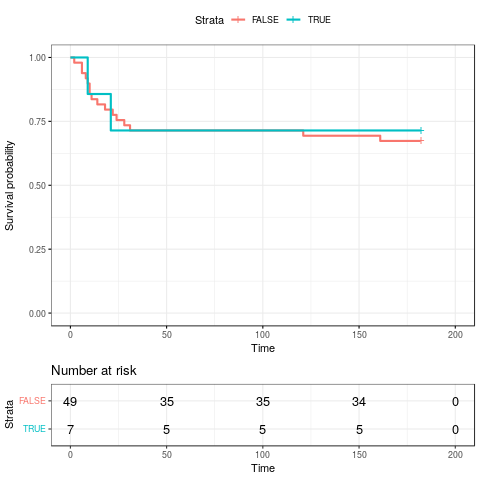

In [95]:
%%R -o fit
fit <- survfit(Surv(data$censored_survival, data$Death) ~ is_rna_outlier, data=data)
strata = strip_strata_prefix(fit)

ggsurvplot(
    fit, data=data,
    legend.labs=strata,
    risk.table=T, ggtheme=theme_bw()
)

In [96]:
%%R
x = data[data$Meningitis == 'Tuberculosis',]
x = x[, complete.cases(t(x))]
x = Filter(var, x)
x = type.convert(x, as.is=T)

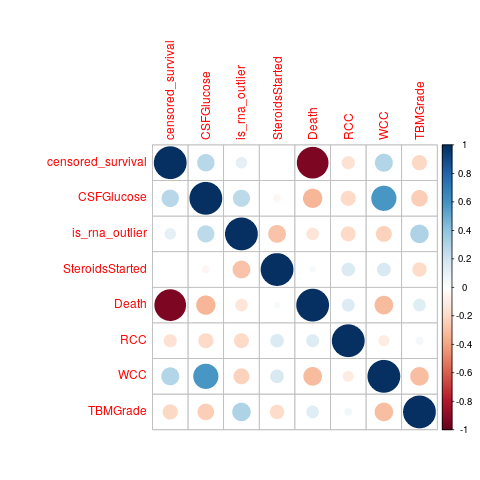

In [97]:
%%R
library(corrplot)
correlations <- cor(x)
corrplot(correlations, method="circle")

In [98]:
%%R
# death and survival obviously too corelated; WCC/CSFGlucose - close!
selection = subset(x, select=-c(Death))
summary(lm(is_rna_outlier ~ ., data=selection))


Call:
lm(formula = is_rna_outlier ~ ., data = selection)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61740 -0.23003 -0.01822  0.10483  0.75196 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)         -0.3681857  0.3749918  -0.982   0.3374  
censored_survival    0.0008521  0.0010295   0.828   0.4172  
CSFGlucose           0.1820418  0.0700032   2.600   0.0167 *
SteroidsStartedTRUE -0.1206518  0.2067015  -0.584   0.5656  
RCC                 -0.0014824  0.0023108  -0.642   0.5281  
WCC                 -0.0009280  0.0004126  -2.249   0.0353 *
TBMGrade             0.2232207  0.1299867   1.717   0.1006  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3621 on 21 degrees of freedom
Multiple R-squared:  0.4158,	Adjusted R-squared:  0.2489 
F-statistic: 2.491 on 6 and 21 DF,  p-value: 0.05595



For a plot, see below logistic regression.

In [99]:
%%R
summary(glm(is_rna_outlier ~., family=binomial(link='logit'), data=selection))


Call:
glm(formula = is_rna_outlier ~ ., family = binomial(link = "logit"), 
    data = selection)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.85691  -0.36555  -0.06684   0.00000   1.93056  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)  
(Intercept)         -9.219768   5.306774  -1.737   0.0823 .
censored_survival    0.002562   0.011193   0.229   0.8189  
CSFGlucose           2.076905   1.223718   1.697   0.0897 .
SteroidsStartedTRUE -1.373669   1.731629  -0.793   0.4276  
RCC                 -0.387524   0.475437  -0.815   0.4150  
WCC                 -0.003655   0.005353  -0.683   0.4948  
TBMGrade             2.861555   1.863328   1.536   0.1246  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 29.096  on 27  degrees of freedom
Residual deviance: 14.538  on 21  degrees of freedom
AIC: 28.538

Number of Fisher Scoring iterations: 

In [100]:
# sometimes fighting with the rpy2 conversions is not worth it: 
tmp_clinical_path = '/tmp/clinical_counts_with_rna_outliers.csv'
clinical_counts.to_csv(tmp_clinical_path)

In [101]:
%%R -i tmp_clinical_path
df = read.csv(tmp_clinical_path, row.names=1, check.names=FALSE)
names(df) = sub('%', 'Percent_', names(df))
df = df[df$Meningitis=='Tuberculosis',]
df$observation_type = ifelse(as.logical(df$is_rna_outlier), 'RNA outlier TB', 'Non-outlier TB')

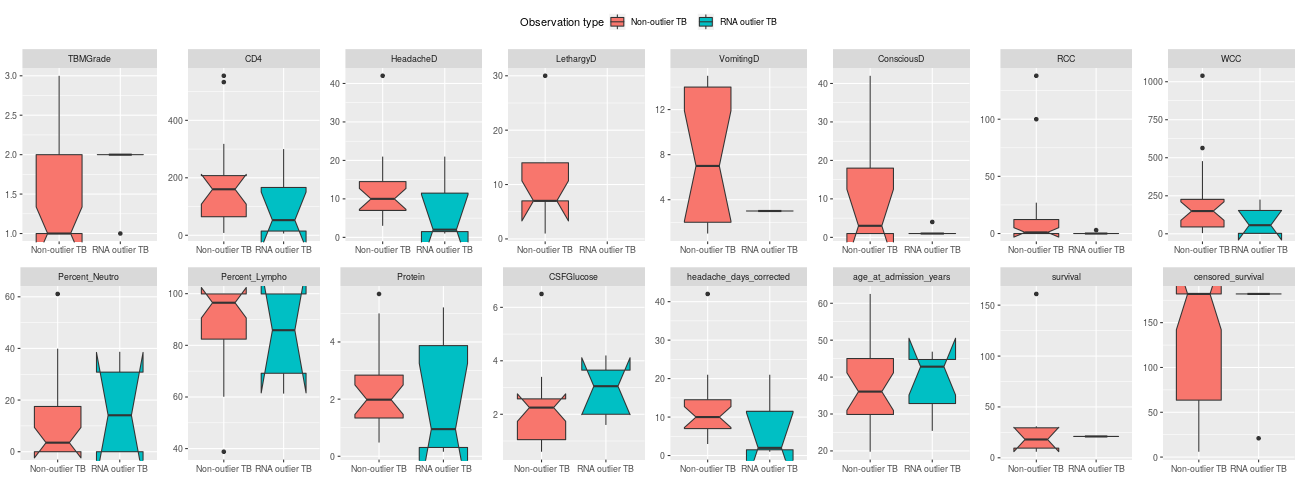

In [102]:
%%R -w 1300
import::here(ggplot_columns_grid, .from='plots/grids.R')

ggplot_columns_grid(
    df,
    ggplot=function(data, column) { (
        ggplot(data, aes_string(x='observation_type', y=column, fill='observation_type', group='observation_type'))
        + geom_boxplot(notch=T)
    )},
    prepare_legend=function(legend) {
        legend + guides(fill=guide_legend(title='Observation type'))
    }
)

### Wrapping up

Repeat preprocessing, this time without outliers:

In [306]:
%%R
import::here(calc_normalization_factors, .from='helpers/preprocessing.R')

preprocess_limma = function(counts, conditions, strict_filter_join_bacterial_to=F, method='TMM') {
    dge = edgeR::DGEList(counts=counts, group=conditions)#, genes=rownames(counts))
    
    if(strict_filter_join_bacterial_to != F)
        conditions[conditions=='Bacterial'] = strict_filter_join_bacterial_to

    dge_filtered = filter_out_low_expression(dge, conditions)
    dge_filtered_norm = calc_normalization_factors(dge_filtered, method=method)

    dge_filtered_norm
}

clean_dge_tb_together = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis')
clean_dge_tb_subset = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis')

[1] "Retaining: 49.79%"
[1] "Retaining: 59.29%"


### Helper functions

In [364]:
from helpers.venn import venn2, venn3, venn4, venn_n

In [310]:
with_gene_data = partial(ensembl.merge_gene_data, sort='adj.P.Val')

### Enabling Gene Set Enrichment Analysis

In [313]:
ensembl_to_entrez = read_csv(ensembl_to_entrez_path, index_col=0)
ensembl_to_entrez.head(2)

NCBI Gene ID
Ensembl gene ID              
ENSG00000121410             1
ENSG00000268895        503538

In [315]:
from helpers.gse import collection_to_R, nice_kegg, formatter_to_fix_letter_case
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase, GeneMatrixTransposed

db = MolecularSignaturesDatabase('data/msigdb', version='6.2')

In [317]:
reactome_new_symbol = GeneMatrixTransposed.from_gmt('ReactomePathways.gmt', name='reactome_new_symbol')
kegg_pathways_entrez = db.load(gene_sets='c2.cp.kegg', id_type='entrez').format_names(nice_kegg)
reactome_pathways_entrez = db.load(gene_sets='c2.cp.reactome', id_type='entrez').format_names(
    formatter_to_fix_letter_case(reactome_new_symbol)
)

In [787]:
ensembl_to_gene_name = ensembl.merge_gene_data(raw_counts_matrix)[['gene_name']]

In [321]:
i = set(ensembl_to_entrez.index)

entrez_ids = {
    str(int(ensembl_to_entrez.loc[g])) for g in raw_counts_matrix_subset.index
    if g in i
}
symbols = set(ensembl_to_gene_name.loc[raw_counts_matrix.index]['gene_name'])

for collection, genes in [
    (kegg_pathways_entrez, entrez_ids),
    (reactome_pathways_entrez, entrez_ids),
    (reactome_new_symbol, symbols)
]:
    after_trimming = collection_to_R(collection, trim_to=genes)
    print(collection.name, len(after_trimming))

c2.cp.kegg 186
c2.cp.reactome 671
reactome_new_symbol 1641


### The differential expression analysis and GSEA procedures

In [493]:
%%R
import::here(calc_camera, calc_de, .from='helpers/differential_expression.R')

#### Sanity check: are the Camera/CameraPR results comparable?

In [112]:
%%R -o cam -o cam_pr
cam = calc_camera('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers, voom=T)
cam_pr = calc_camera('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers, voom=T, statistic='t')

In [113]:
cam.head(n=10)

NGenes Direction  \
FCERI mediated NF-kB activation                      133.0        Up   
Signaling by the B Cell Receptor (BCR)               160.0        Up   
Fc epsilon receptor (FCERI) signaling                185.0        Up   
FCERI mediated Ca+2 mobilization                      84.0        Up   
Role of LAT2/NTAL/LAB on calcium mobilization         69.0        Up   
FCGR activation                                       71.0        Up   
Antigen activates B Cell Receptor (BCR) leading...    81.0        Up   
FCERI mediated MAPK activation                        85.0        Up   
Interferon alpha/beta signaling                       67.0        Up   
CD22 mediated BCR regulation                          56.0        Up   

                                                          PValue           FDR  
FCERI mediated NF-kB activation                     1.544709e-14  2.534867e-11  
Signaling by the B Cell Receptor (BCR)              9.765169e-14  8.012321e-11  
Fc epsilon receptor (FCERI) signaling               1.963220e-13  1.073881e-10  
FCERI mediated Ca+2 mobilization                    4.126192e-13  1.692770e-10  
Role of LAT2/NTAL/LAB on calcium mobilization       6.777535e-13  1.883935e-10  
FCGR activation                                     6.888243e-13  1.883935e-10  
Antigen activates B Cell Receptor (BCR) leading...  3.199626e-12  7.500837e-10  
FCERI mediated MAPK activation                      4.900921e-12  1.005302e-09  
Interferon alpha/beta signaling                     6.119763e-12  1.115837e-09  
CD22 mediated BCR regulation                        7.412169e-12  1.216337e-09

In [114]:
cam_pr.head(n=10)

NGenes Direction  \
FCERI mediated NF-kB activation                      133.0        Up   
Signaling by the B Cell Receptor (BCR)               160.0        Up   
Fc epsilon receptor (FCERI) signaling                185.0        Up   
Interferon alpha/beta signaling                       67.0        Up   
Ub-specific processing proteases                     184.0        Up   
FCERI mediated Ca+2 mobilization                      84.0        Up   
Role of LAT2/NTAL/LAB on calcium mobilization         69.0        Up   
FCGR activation                                       71.0        Up   
Antigen activates B Cell Receptor (BCR) leading...    81.0        Up   
FCERI mediated MAPK activation                        85.0        Up   

                                                          PValue           FDR  
FCERI mediated NF-kB activation                     5.576130e-13  9.150430e-10  
Signaling by the B Cell Receptor (BCR)              2.025443e-12  1.661876e-09  
Fc epsilon receptor (FCERI) signaling               3.322449e-12  1.817379e-09  
Interferon alpha/beta signaling                     5.488534e-12  2.251671e-09  
Ub-specific processing proteases                    4.143655e-11  1.359948e-08  
FCERI mediated Ca+2 mobilization                    8.350073e-11  2.283745e-08  
Role of LAT2/NTAL/LAB on calcium mobilization       2.322169e-10  5.342562e-08  
FCGR activation                                     2.604540e-10  5.342562e-08  
Antigen activates B Cell Receptor (BCR) leading...  4.949510e-10  9.024606e-08  
FCERI mediated MAPK activation                      5.825666e-10  9.559918e-08

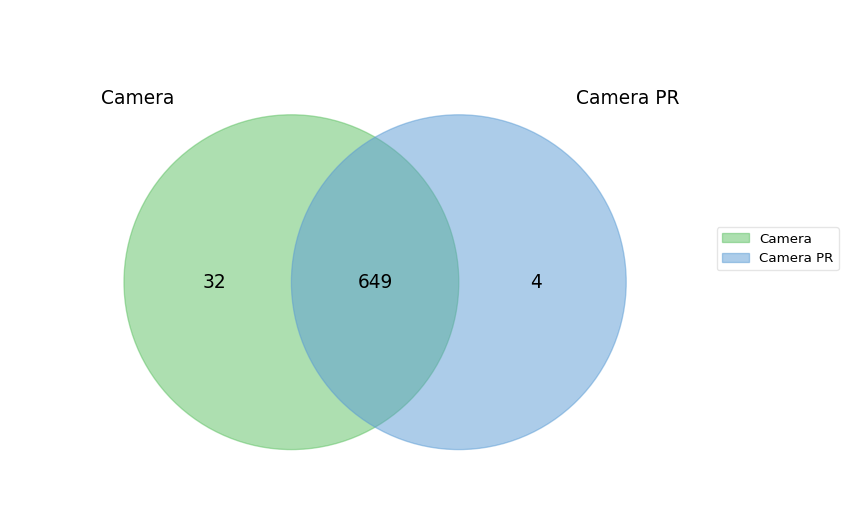

In [115]:
venn2({
    'Camera': cam.query('FDR < 0.05').index,
    'Camera PR': cam_pr.query('FDR < 0.05').index
});

Yes!

#### How much does pre-processing without outliers change?

In [116]:
%R head(calc_de('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers))

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000241313 -3.827504  0.103471 -4.957357  0.000006   0.082776  3.424716
ENSG00000280809 -3.687482 -0.392448 -4.932004  0.000007   0.082776  3.347667
ENSG00000179412 -4.027153 -1.742398 -4.882371  0.000008   0.082776  3.197210
ENSG00000272975 -3.837146 -0.400797 -4.617754  0.000022   0.128365  2.404251
ENSG00000264714 -3.895521  0.800231 -4.506954  0.000032   0.128365  2.077294
ENSG00000266486 -3.579099 -1.294764 -4.479094  0.000035   0.128365  1.995594

In [117]:
%R head(calc_de('Tuberculosis', 'Cryptococcal', clean_dge_tb_together, by_condition_no_outliers))

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000241313 -3.754627  0.053107 -4.891953  0.000008   0.086834  3.193391
ENSG00000280809 -3.622892 -0.450922 -4.864057  0.000009   0.086834  3.109575
ENSG00000179412 -3.995456 -1.786214 -4.861691  0.000009   0.086834  3.102473
ENSG00000272975 -3.774459 -0.453120 -4.588835  0.000024   0.149866  2.291996
ENSG00000264714 -3.837496  0.743798 -4.479999  0.000035   0.149866  1.973816
ENSG00000266486 -3.538271 -1.350025 -4.465489  0.000037   0.149866  1.931635

Not much. But this may be more statistically sound (e.g. when assuming that the rejected samples carry technical error burden).

In [366]:
def limma_venn(limma_gene_sets):
    return venn_n(limma_gene_sets, names=['limma-' + name.replace('_', ' ') for name in limma_gene_sets], n=len(limma_gene_sets))

In [344]:
%R import::here(volcano_plot, .from='plots/volcano.R')

## Comparison of limma-trend, limma-voom and DESeq2

I will be using robust voom with sample quality weights. I will also demonstrate effects of different normalization methods (RLE and TMM) but I will continue using TMM which is standard for limma toolkit.

I will also use independent filtering to limit the effect of lowly expressed genes; for the comparison purposes I will start with the same method as used in DESeq2; but for the final analysis I will use a more advanced technique (Independent hypothesis weighting) which does not blatantly reject all lowly expressed genes.

In [404]:
%%R
import::here(
    filter_by_mean_expression, add_p_value_for_filtered_subset,
    weight_by_mean_expression, add_p_value_for_weighted_hypothesis,
    .from='helpers/independent_hypothesis.R'
)

The independent filtering is an interesting way (or trick) of decreasing the FDR/adjusted p-value by disregarding some hypotheses upfront. The criterion used by DESeq2 is having a small number of normalized counts (regardless of the condition). For more details see the plot and explanation in the [DESeq2 vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilttheory).

Thus at the cost of getting a few false negatives, DESeq increases the number of true positives.

The independent filtering can be applied to edgeR's statistical piepline as well ([statquests](https://statquest.org/2017/05/16/statquest-filtering-genes-with-low-read-counts/) by prof Joshua Starmer)

### Tuberculosis (regardless of certainty) vs Cryptococcal

In [332]:
%%R
tmm_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='TMM')
rle_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='RLE')
tcc_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='EEE')

[1] "Retaining: 49.79%"
[1] "Retaining: 49.79%"
[1] "Retaining: 49.79%"
[1] "edger"
TCC::INFO: Calculating normalization factors using DEGES
TCC::INFO: (iDEGES pipeline : tmm - [ edger - tmm ] X 3 )
TCC::INFO: Done.


In [334]:
%%R -o trend_tmm -o trend_rle -o voom_rle -o voom_tmm -o trend_tcc -o voom_tcc
trend_tmm = calc_de('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers)
trend_rle = calc_de('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers)
trend_tcc = calc_de('Tuberculosis', 'Cryptococcal', tcc_normalized, by_condition_no_outliers)
voom_rle = calc_de('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
voom_tmm = calc_de('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
voom_tcc = calc_de('Tuberculosis', 'Cryptococcal', tcc_normalized, by_condition_no_outliers, voom=T, quality_weights=T)

In [123]:
%store trend_tmm
%store trend_rle
%store voom_rle
%store voom_tmm
%store reference_definite_tbm_cm_deg

Stored 'trend_tmm' (DataFrame)
Stored 'trend_rle' (DataFrame)
Stored 'voom_rle' (DataFrame)
Stored 'voom_tmm' (DataFrame)
Stored 'reference_definite_tbm_cm_deg' (DataFrame)


In [124]:
%R -o reference_samples -o raw_counts_trimmed

In [125]:
%store by_condition_and_tb_subset
%store reference_samples
%store raw_counts_trimmed

Stored 'by_condition_and_tb_subset' (Series)
Stored 'reference_samples' (ndarray)
Stored 'raw_counts_trimmed' (DataFrame)


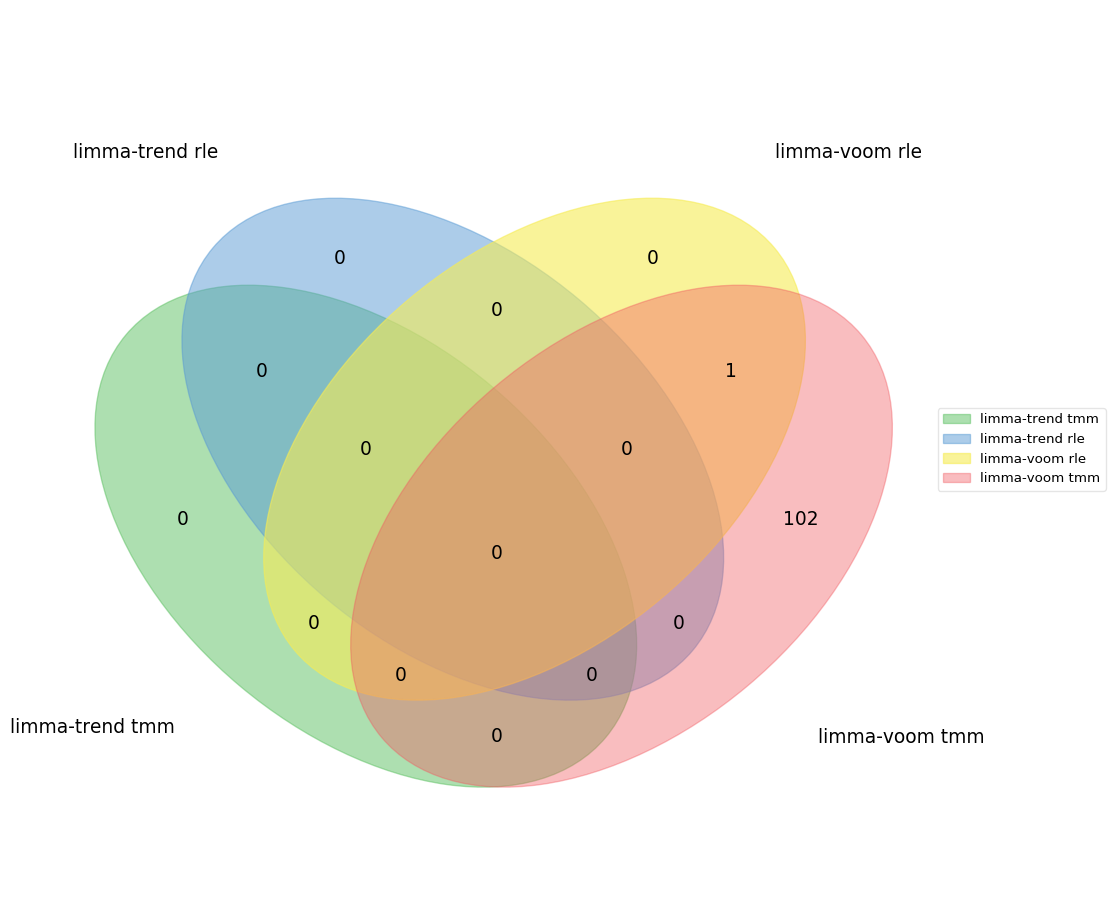

In [126]:
limma_degs = {'trend_tmm': trend_tmm, 'trend_rle': trend_rle, 'voom_rle': voom_rle, 'voom_tmm': voom_tmm}
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_degs.items()});

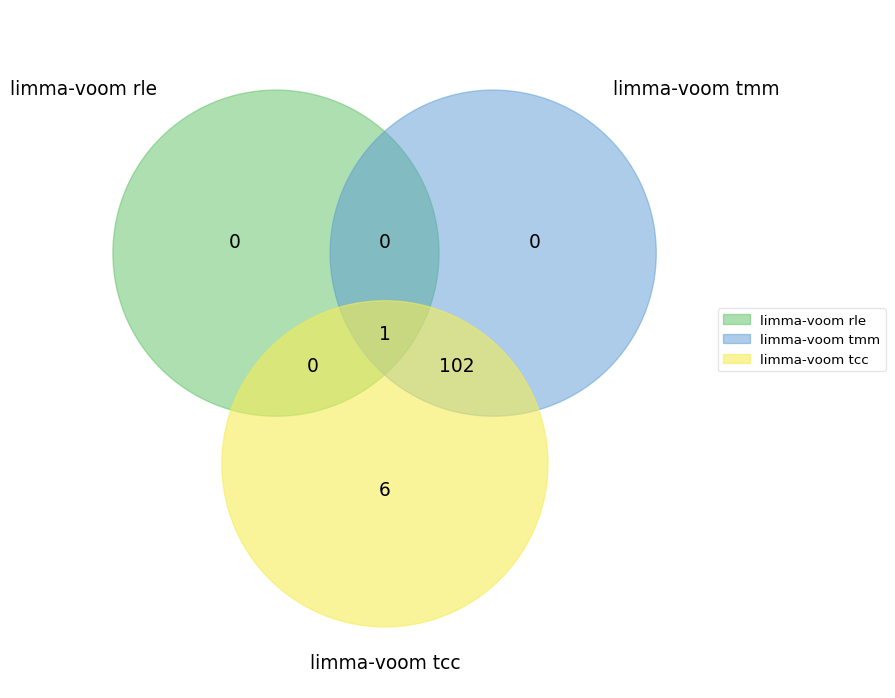

In [368]:
limma_degs = {'voom_rle': voom_rle, 'voom_tmm': voom_tmm, 'voom_tcc': voom_tcc}
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_degs.items()});

With TCC, not only 6 additional genes were recovered, but the ordering changed slightly as well:

In [127]:
tb_cm_degs = with_gene_data(voom_tmm)
tb_cm_degs.head()

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.850623  1.151840  7.092514  1.582206e-09   0.000046   
ENSG00000279457  2.911276  0.294718  5.957668  1.363680e-07   0.001977   
ENSG00000250151  2.189311  1.272580  5.439394  9.911301e-07   0.009580   
ENSG00000267745  2.297618  1.393316  5.255802  1.976942e-06   0.014331   
ENSG00000111788  2.234684  0.843328  5.132164  3.133927e-06   0.014625   

                         B    gene_name                 biotype contig strand  
ENSG00000269242  11.219056   AC010422.3          protein_coding     19      -  
ENSG00000279457   7.024647       WASH9P  unprocessed_pseudogene      1      -  
ENSG00000250151   5.367719  ARPC4-TTLL3          protein_coding      3      +  
ENSG00000267745   4.706754   AC060766.7    processed_transcript     17      -  
ENSG00000111788   4.184976   AC009533.1  unprocessed_pseudogene     12      +

In [358]:
tcc_degs = with_gene_data(voom_tcc)
tcc_degs.head()

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.874598  1.306148  7.129904  1.341555e-09   0.000039   
ENSG00000279457  2.934062  0.449026  6.009205  1.105397e-07   0.001603   
ENSG00000250151  2.203826  1.426888  5.465230  8.917844e-07   0.008620   
ENSG00000111788  2.255086  0.997636  5.178563  2.619780e-06   0.011966   
ENSG00000143575  1.164903  4.756001  5.159526  2.812282e-06   0.011966   

                         B    gene_name                 biotype contig strand  
ENSG00000269242  11.386115   AC010422.3          protein_coding     19      -  
ENSG00000279457   7.228720       WASH9P  unprocessed_pseudogene      1      -  
ENSG00000250151   5.471558  ARPC4-TTLL3          protein_coding      3      +  
ENSG00000111788   4.356047   AC009533.1  unprocessed_pseudogene     12      +  
ENSG00000143575   4.492438         HAX1          protein_coding      1      +

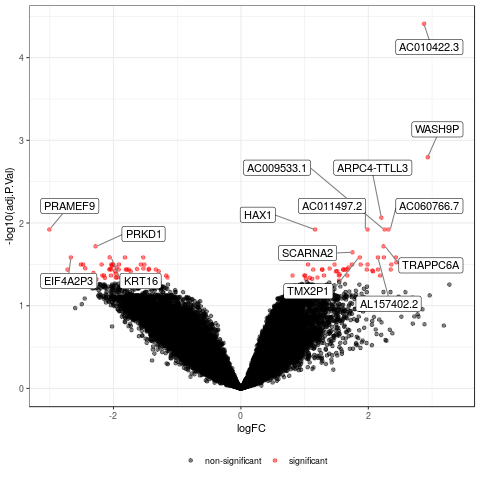

In [356]:
%%R -i tcc_degs
volcano_plot(tcc_degs, significant_only=F, transparency=0.5)

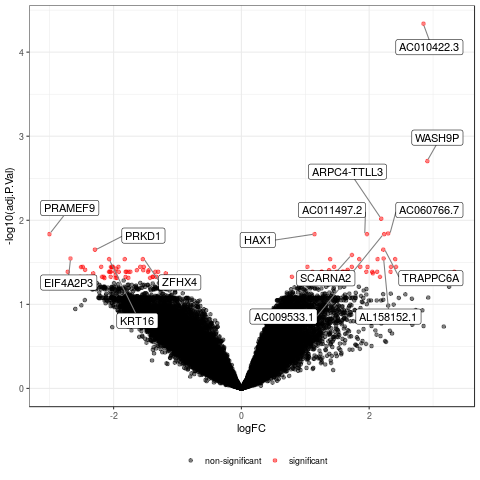

In [128]:
%%R -i tb_cm_degs
volcano_plot(tb_cm_degs, significant_only=F, transparency=0.5)

AC010422.3 is NMD variant of MAN2B1 (Mannosidase Alpha Class 2B Member 1)

> This gene encodes an enzyme that hydrolyzes terminal, non-reducing alpha-D-mannose residues in alpha-D-mannosides. Its activity is necessary for the catabolism of N-linked carbohydrates released during glycoprotein turnover and it is member of family 38 of glycosyl hydrolases [RefSeq]

Related to alpha-Mannosidosis, a lysosomal storage diseases. Likely a false positive, but who knows?

**Just occurred to be when reading the latest PubMed alert on TB Meningitis**, with a study on Lipoarabinomannan as a diagnostic test for TBM:

Unrelated Uniprot entry which explains relation to LM and LAM:
> P9WMZ3
> - GDP-mannose-dependent alpha-(1-6)-phosphatidylinositol monomannoside mannosyltransferase
> Involved in the biosynthesis of phosphatidyl-myo-inositol mannosides (PIM) which are early precursors in the biosynthesis of lipomannans (LM) and lipoarabinomannans (LAM) (PubMed:19395496). Catalyzes the addition of a mannosyl residue from GDP-D-mannose (GDP-Man) to the position 6 of a phosphatidyl-myo-inositol bearing an alpha-1,2-linked mannose residue (PIM1) to generate phosphatidyl-myo-inositol bearing alpha-1,2- and alpha-1,6-linked mannose residues (Ac1PIM2) (PubMed:19395496). 

So there is some thin, indirect link between AC010422.3 and TBM... Is it possible that the RNA that we observe is not an NMD variant of a human gene but a bacterial one?
Unlikely, blasting returns only mammals; I blasted using both cDNA and protein sequences.

[Ensembl](http://www.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000269242;r=19:12643831-12648397;t=ENST00000597692), [Uniprot](https://www.uniprot.org/uniprot/M0QZ24)

LM blocks immune system of human macrophages (https://www.pnas.org/content/108/42/17408, TNF biosynthesis: MAPK-activated protein kinase 2 (MK2) and microRNA miR-125b). Anyway, time to move on.

In [129]:
tb_cm_degs.query('gene_name == "MAN2B1"')

logFC   AveExpr         t   P.Value  adj.P.Val        B  \
ENSG00000104774  0.482098  6.757319  1.626566  0.108968   0.304995 -5.11164   

                gene_name         biotype contig strand  
ENSG00000104774    MAN2B1  protein_coding     19      -

An even wilder idea: could TB reprogram human cells to produce a protein which is useful for its wall assembly?

Well the reprogramming is not a stupid idea per-se - [there  was an offer of PhD on UCL](https://www.findaphd.com/phds/project/reprogramming-of-human-host-cells-by-mycobacteria-a-cell-biology-approach/?p37576). A study from 2008 looked at the cross talk but used microarays so was rather unable to detect this transcript https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2151136/

- A good review from 2005: https://academic.oup.com/femsre/article/29/5/1041/546335 but no mention of cell transformation, other than the mycobacterium can traffic its proteins to the cytosol of the host:
> If the virulence of M. tuberculosis is dependent on the activity of mycobacterial phospho-proteins, **secretion of these proteins into the phagosome, and possibly through the phagosomal membrane into the host cell cytoplasm, is likely**. Secretion of bacterial protein into the host cell is critical for the intracellular survival of pathogens such as Salmonella and Yersinia[78]. The recent identification of a specified secretion system in mycobacteria [79, 80] raises the possibility of active transport of mycobacterial proteins into the host cell. Significantly, the culture medium of M. tuberculosis shows the presence of a protein tyrosine phosphatase [81] and a protein kinase [82], indicating an active secretion of these proteins

Terminology alert: if this was a thing we would probably refer to it as bactofection as bacterial transfection is already used for an unrelated procedure. 

In [400]:
from helpers.r import r_function

add_p_value_for_filtered_subset = partial(r_function, 'add_p_value_for_filtered_subset')
add_p_value_for_weighted_hypothesis = partial(r_function, 'add_p_value_for_weighted_hypothesis')
    
def apply_to_degs(dicts_with_degs, func, **kwargs):
        return {
            k: func(v, **kwargs)
            for k, v in dicts_with_degs.items()
        }
    
filter_degs = partial(apply_to_degs, func=add_p_value_for_filtered_subset)
weight_degs = partial(apply_to_degs, func=add_p_value_for_weighted_hypothesis)

In [131]:
limma_filtered_degs = filter_degs(limma_degs)

In [132]:
tb_cm_degs_filtered = with_gene_data(limma_filtered_degs['voom_tmm'])
tb_cm_degs_filtered.head(10)

logFC   AveExpr         t   P.Value  adj.P.Val  ...  \
ENSG00000100226  1.033786  7.263131  4.437090  0.000039   0.039285  ...   
ENSG00000164054  1.112920  7.198418  4.231338  0.000079   0.040137  ...   
ENSG00000055332  1.075537  8.456809  3.291954  0.001655   0.042205  ...   
ENSG00000101294  0.770991  7.168689  3.594118  0.000650   0.042205  ...   
ENSG00000102096  0.990084  7.209150  3.503469  0.000865   0.042205  ...   
ENSG00000107099  0.909200  9.324414  3.423674  0.001108   0.042205  ...   
ENSG00000107201  1.215734  7.307868  3.287864  0.001746   0.042205  ...   
ENSG00000107290  0.845222  8.874543  3.280811  0.001712   0.042205  ...   
ENSG00000111335  1.280150  8.099110  4.040337  0.000151   0.042205  ...   
ENSG00000112343  0.868263  7.989724  3.366615  0.001320   0.042205  ...   

                 unfiltered.adj.P.Val  gene_name         biotype contig strand  
ENSG00000100226              0.035825     GTPBP1  protein_coding     22      +  
ENSG00000164054              0.041020     SHISA5  protein_coding      3      -  
ENSG00000055332              0.084109    EIF2AK2  protein_coding      2      -  
ENSG00000101294              0.072242       HM13  protein_coding     20      +  
ENSG00000102096              0.079290       PIM2  protein_coding      X      -  
ENSG00000107099              0.083024      DOCK8  protein_coding      9      +  
ENSG00000107201              0.084109      DDX58  protein_coding      9      -  
ENSG00000107290              0.084109       SETX  protein_coding      9      -  
ENSG00000111335              0.047330       OAS2  protein_coding     12      +  
ENSG00000112343              0.083979     TRIM38  protein_coding      6      +  

[10 rows x 11 columns]

In [133]:
tb_cm_degs_weighted = with_gene_data(add_p_value_for_weighted_hypothesis(limma_degs['voom_tmm']))
tb_cm_degs_weighted.head(10)

logFC   AveExpr         t       P.Value  adj.P.Val  ...  \
ENSG00000269242  2.850623  1.151840  7.092514  1.582206e-09   0.000109  ...   
ENSG00000279457  2.911276  0.294718  5.957668  1.363680e-07   0.007281  ...   
ENSG00000100226  1.033786  7.263131  4.437090  3.870477e-05   0.031199  ...   
ENSG00000164054  1.112920  7.198418  4.231338  7.908860e-05   0.032636  ...   
ENSG00000185507  1.372894  6.832088  4.320428  5.814908e-05   0.032636  ...   
ENSG00000278249  1.730000  3.121146  4.821462  9.807885e-06   0.032636  ...   
ENSG00000111788  2.234684  0.843328  5.132164  3.133927e-06   0.035378  ...   
ENSG00000274827 -1.826270  3.457761 -4.643182  1.864643e-05   0.035378  ...   
ENSG00000111335  1.280150  8.099110  4.040337  1.513833e-04   0.040707  ...   
ENSG00000005339  0.731574  8.954208  3.198832  2.186645e-03   0.045543  ...   

                 unweighted.adj.P.Val   gene_name                 biotype  \
ENSG00000269242              0.000046  AC010422.3          protein_coding   
ENSG00000279457              0.001977      WASH9P  unprocessed_pseudogene   
ENSG00000100226              0.035825      GTPBP1          protein_coding   
ENSG00000164054              0.041020      SHISA5          protein_coding   
ENSG00000185507              0.039213        IRF7          protein_coding   
ENSG00000278249              0.025854     SCARNA2                  scaRNA   
ENSG00000111788              0.014625  AC009533.1  unprocessed_pseudogene   
ENSG00000274827              0.028969   LINC01297                 lincRNA   
ENSG00000111335              0.047330        OAS2          protein_coding   
ENSG00000005339              0.089054      CREBBP          protein_coding   

                contig strand  
ENSG00000269242     19      -  
ENSG00000279457      1      -  
ENSG00000100226     22      +  
ENSG00000164054      3      -  
ENSG00000185507     11      -  
ENSG00000278249      1      +  
ENSG00000111788     12      +  
ENSG00000274827     14      -  
ENSG00000111335     12      +  
ENSG00000005339     16      -  

[10 rows x 11 columns]

In [134]:
tb_cm_degs.head(10)

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.850623  1.151840  7.092514  1.582206e-09   0.000046   
ENSG00000279457  2.911276  0.294718  5.957668  1.363680e-07   0.001977   
ENSG00000250151  2.189311  1.272580  5.439394  9.911301e-07   0.009580   
ENSG00000267745  2.297618  1.393316  5.255802  1.976942e-06   0.014331   
ENSG00000111788  2.234684  0.843328  5.132164  3.133927e-06   0.014625   
ENSG00000143575  1.144665  4.601693  5.135412  3.096367e-06   0.014625   
ENSG00000204505 -3.005359  0.494087 -5.081866  3.776041e-06   0.014625   
ENSG00000269374  1.965517  0.174522  5.063937  4.034845e-06   0.014625   
ENSG00000007255  2.220900 -0.015033  4.887718  7.706511e-06   0.022347   
ENSG00000184304 -2.292532  0.462342 -4.911217  7.072763e-06   0.022347   

                         B    gene_name                 biotype contig strand  
ENSG00000269242  11.219056   AC010422.3          protein_coding     19      -  
ENSG00000279457   7.024647       WASH9P  unprocessed_pseudogene      1      -  
ENSG00000250151   5.367719  ARPC4-TTLL3          protein_coding      3      +  
ENSG00000267745   4.706754   AC060766.7    processed_transcript     17      -  
ENSG00000111788   4.184976   AC009533.1  unprocessed_pseudogene     12      +  
ENSG00000143575   4.403460         HAX1          protein_coding      1      +  
ENSG00000204505   3.882400      PRAMEF9          protein_coding      1      +  
ENSG00000269374   4.112161   AC011497.2    processed_pseudogene     19      -  
ENSG00000007255   3.201577     TRAPPC6A          protein_coding     19      -  
ENSG00000184304   3.328537        PRKD1          protein_coding     14      -

Caveat: independent filtering may be done with respect to analyzed groups or entire experiment. Which one is better?

In [135]:
%%R -o voom_tmm_filtered_non_agressive
voom_tmm_filtered_non_agressive = add_p_value_for_filtered_subset(voom_tmm, use_deseq2_method=T)

In [136]:
tb_cm_degs_filtered_non_agressive = with_gene_data(voom_tmm_filtered_non_agressive)

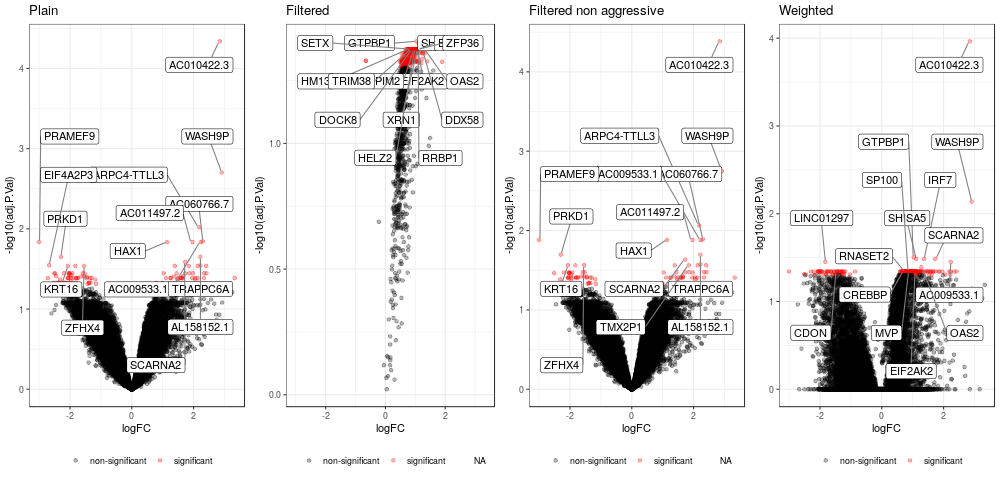

In [137]:
%%R -i tb_cm_degs_filtered -i tb_cm_degs_weighted -i tb_cm_degs -w 1000 -i tb_cm_degs_filtered_non_agressive

gridExtra::grid.arrange(
    volcano_plot(tb_cm_degs, significant_only=F, transparency=0.3) + ggtitle('Plain'),
    volcano_plot(tb_cm_degs_filtered, significant_only=F, transparency=0.3) + ggtitle('Filtered'),
    volcano_plot(tb_cm_degs_filtered_non_agressive, significant_only=F, transparency=0.3) + ggtitle('Filtered non aggressive'),
    volcano_plot(tb_cm_degs_weighted, significant_only=F, transparency=0.3) + ggtitle('Weighted'),
    ncol=4
)

> More realistic nonspecific filters can also detrimentally affect the conditional distribution of the test statistic. The limma t-statistic (Embedded Image) is based on an empirical Bayes approach which models the gene-level error variances Embedded Image with a scaled inverse χ2 distribution. For many microarray datasets, this distribution provides a good fit (4). In ref. 7, an overall variance filter is combined with the limma Embedded Image. Because the within-class variance estimator (Embedded Image) and the overall variance are correlated, filtering on overall variance will deplete the set of genes with low Embedded Image (Fig. 2B). A scaled inverse χ2 will then no longer provide a good fit to the data passing the filter, causing the limma algorithm to produce a posterior degrees-of-freedom estimate of ∞. This has two consequences: (i) gene-level variance estimates will be ignored, leading to an unintended analysis based on fold change only; and (ii) the p-values will be overly optimistic (Fig. 2C). See SI Text for details.

> Moderated t-statistics like the limma T^ are also often used to avoid discoveries with small effect sizes. Further, the null distribution for Embedded Image is typically more concentrated than that of the standard t-statistic. In many cases, this concentration also produces power gains—gains which may exceed those obtained by the combination of variance filtering and the standard t-statistic. Can even greater power gains be obtained by combining filtering and moderation? Perhaps, but Fig. 2C shows that such an approach has the potential to inflate the false positive rate when the sample size is small. Thus, we do not recommend combining limma with a filtering procedure which interferes with its distributional assumptions. We are therefore left with two options: variance filtering combined with the standard T, or an unfiltered Embedded Image. Each option addresses the issue of small effect sizes, and each can improve power. Which one provides the best improvement is data dependent, and we provide further examples and discussion in SI Text. (https://www.pnas.org/content/107/21/9546)

There is an interesting correspondence between creators of limma and DESeq2 (including genefilter) published on bioconductor. Picking some fragments in favour of using genefilter for limma:

> In reality, filtering low intensity probes (not low variance probes) is usually of benefit to limma, and we do this routinely for nearly all analyses in my lab. This is for a number of reasons.
 
> First there is the generic (not specific to limma) reason that probes that are not detecting real signal to any worthwhile degree for any sample cannot be detecting DE to any worthwhile degree. Therefore there is a positive correlation between mean log intensity and true DE.

> Second there is the limma-specific reason that probes that are not detecting signal above background levels in any sample trend to have atypical variances, both in absolute size and in terms of mean- variance relationship, compared to probes that are responding to genuine biological signal. In other words, non-expressed or dead probes have variances that cannot be considered to be sampled from the same population as variances for probes from regular expressed probes. It is desirable to get rid of these atypical probes so that limma can concentrate on the behaviour of probes of genuine interest. Filtering by mean log-intensity does not cause any problems for the limma probabilistic model. Indeed it generally improves concordance with the empirical Bayes assumptions.

(https://support.bioconductor.org/p/53061/)

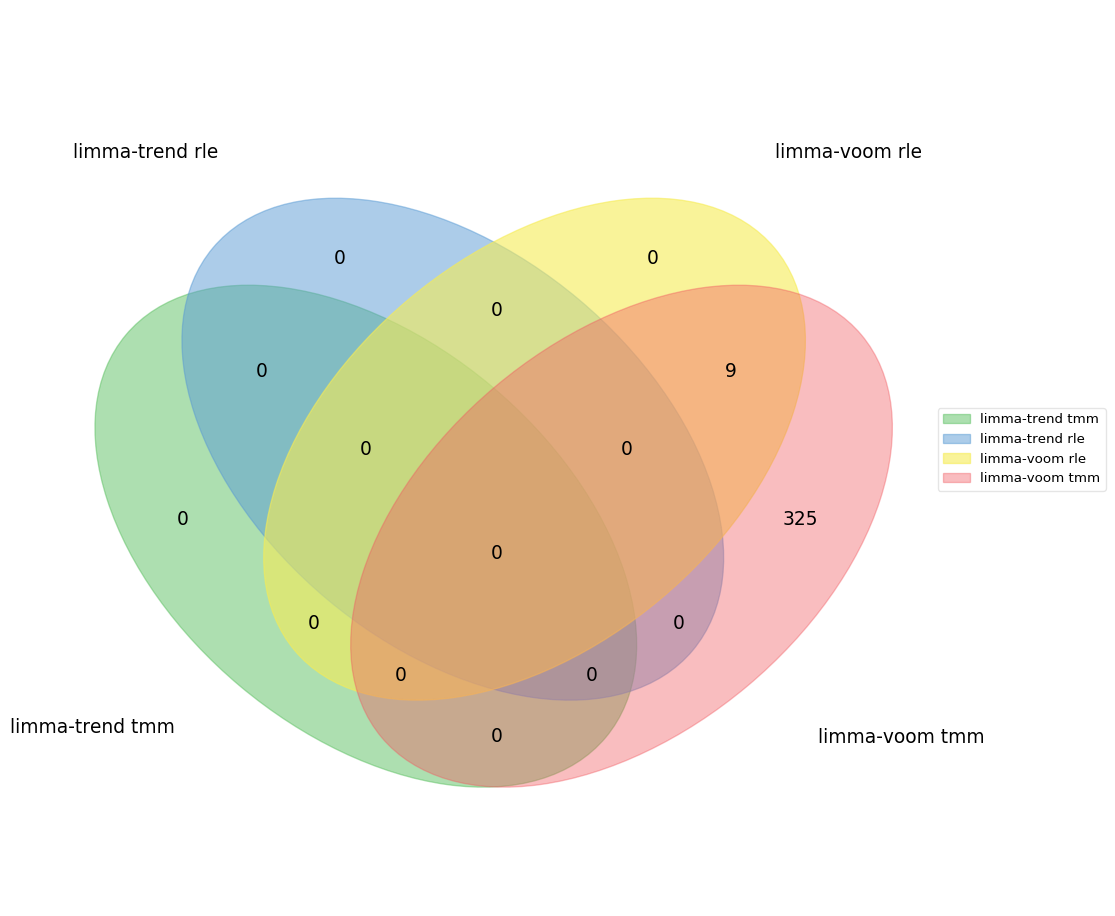

In [138]:
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_filtered_degs.items()});

There is a high agreement for significantly changed gene sets:

In [139]:
%%R -o gs_trend_tmm -o gs_trend_rle -o gs_voom_rle -o gs_voom_tmm
gs_trend_tmm = calc_camera('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers)
gs_trend_rle = calc_camera('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers)
gs_voom_rle = calc_camera('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
gs_voom_tmm = calc_camera('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers, voom=T, quality_weights=T)

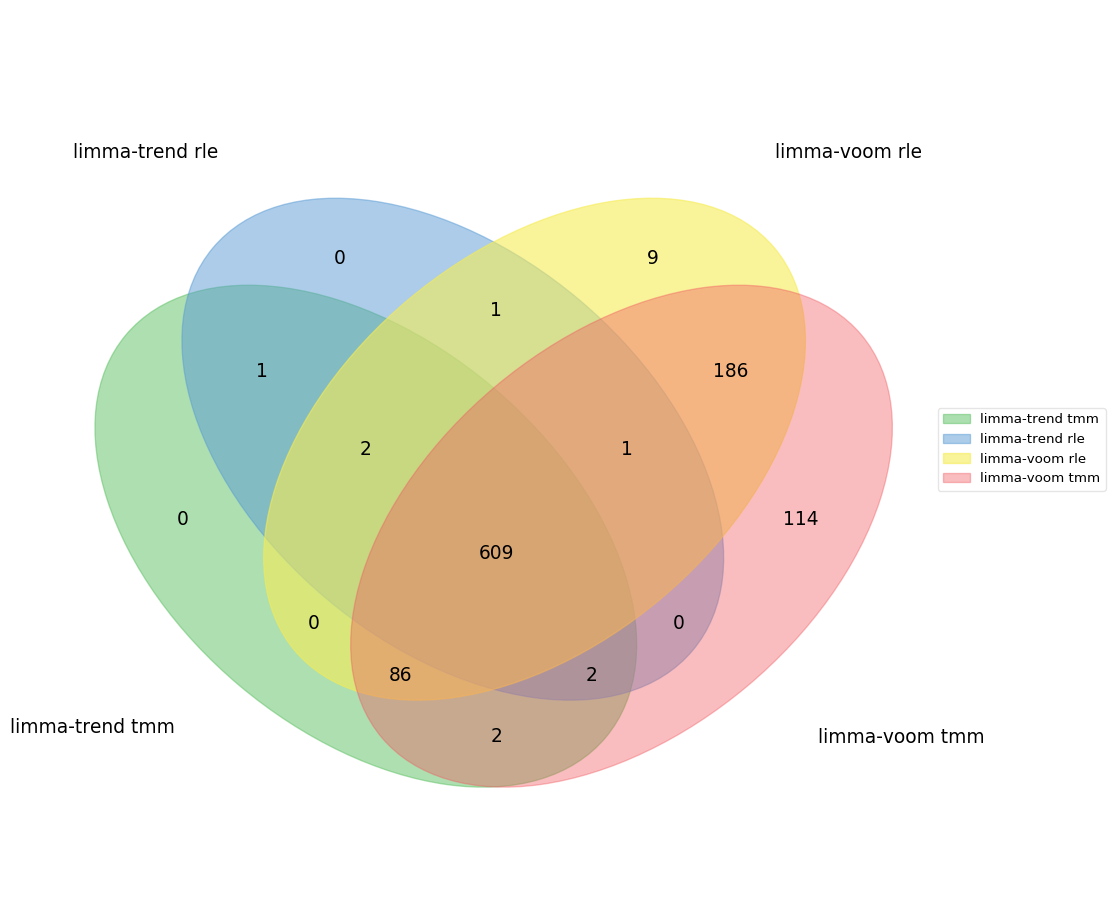

In [140]:
limma_gene_sets = {'trend_tmm': gs_trend_tmm, 'trend_rle': gs_trend_rle, 'voom_rle': gs_voom_rle, 'voom_tmm': gs_voom_tmm}
limma_venn4({k: list(v[v.FDR < 0.05].index) for k, v in limma_gene_sets.items()});

In [141]:
tb_cm_gene_sets = gs_voom_tmm
tb_cm_gene_sets.head(10)

NGenes Direction  \
Signaling by the B Cell Receptor (BCR)            160.0        Up   
Fc epsilon receptor (FCERI) signaling             185.0        Up   
Processing of Capped Intron-Containing Pre-mRNA   239.0        Up   
mRNA Splicing - Major Pathway                     180.0        Up   
FCERI mediated NF-kB activation                   133.0        Up   
mRNA Splicing                                     188.0        Up   
Ub-specific processing proteases                  184.0        Up   
FCERI mediated Ca+2 mobilization                   84.0        Up   
Infectious disease                                376.0        Up   
Interferon Signaling                              192.0        Up   

                                                       PValue           FDR  
Signaling by the B Cell Receptor (BCR)           1.437216e-22  2.358471e-19  
Fc epsilon receptor (FCERI) signaling            1.990306e-21  1.414375e-18  
Processing of Capped Intron-Containing Pre-mRNA  2.585694e-21  1.414375e-18  
mRNA Splicing - Major Pathway                    5.697361e-21  2.065498e-18  
FCERI mediated NF-kB activation                  6.293412e-21  2.065498e-18  
mRNA Splicing                                    2.740110e-20  7.494202e-18  
Ub-specific processing proteases                 3.578094e-18  8.388074e-16  
FCERI mediated Ca+2 mobilization                 4.338695e-18  8.899748e-16  
Infectious disease                               5.222245e-18  9.521894e-16  
Interferon Signaling                             5.828123e-18  9.563949e-16

### Definite Tuberculosis vs Cryptococcal

In [376]:
%%R
tmm_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='TMM')
rle_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='RLE')
eee_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='EEE')

[1] "Retaining: 59.29%"
[1] "Retaining: 59.29%"


In [374]:
%%R
ddd_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='DDD')

In [143]:
normalized_counts_path.mkdir(exist_ok=True)
normalized_counts_path = str(normalized_counts_path)

In [144]:
%%R -i normalized_counts_path
import::here(extract_counts, .from='helpers/differential_expression.R')

write.csv(
    edgeR::cpm(tmm_normalized_tb_subsets, log=T),
    file=paste0(normalized_counts_path, '/tmm_for_subsets.csv')
)
write.csv(
    edgeR::cpm(rle_normalized_tb_subsets, log=T),
    file=paste0(normalized_counts_path, '/rle_for_subsets.csv')
)

In [378]:
%%R -o definite_tb_cm_voom_tmm -o definite_tb_cm_voom_rle -o definite_tb_cm_trend_tmm -o definite_tb_cm_trend_rle -o definite_tb_cm_voom_eee
definite_tb_cm_voom_tmm = calc_de('Definite tuberculosis', 'Cryptococcal', tmm_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
definite_tb_cm_voom_rle = calc_de('Definite tuberculosis', 'Cryptococcal', rle_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
definite_tb_cm_voom_eee = calc_de('Definite tuberculosis', 'Cryptococcal', eee_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)

definite_tb_cm_trend_tmm = calc_de('Definite tuberculosis', 'Cryptococcal', tmm_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers)
definite_tb_cm_trend_rle = calc_de('Definite tuberculosis', 'Cryptococcal', rle_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers)

In [382]:
# definite_tb_cm_voom_ddd = calc_de('Definite tuberculosis', 'Cryptococcal', ddd_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)

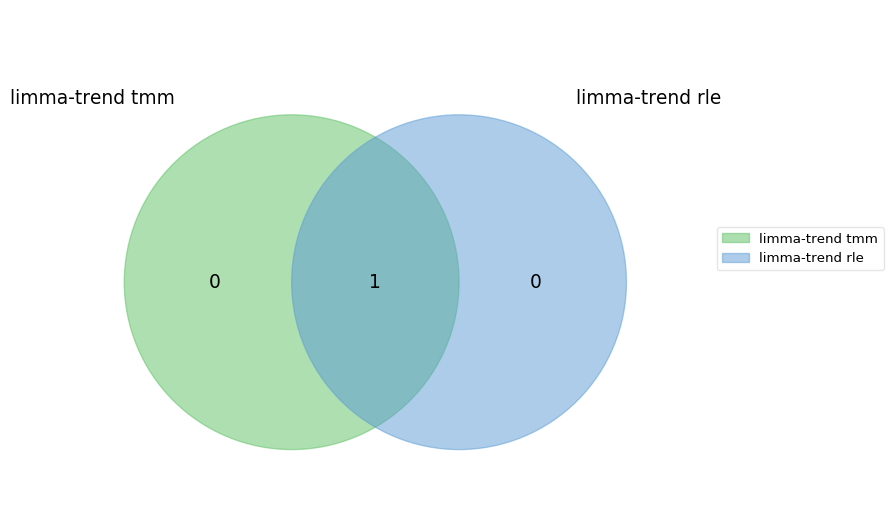

In [390]:
definite_tb_cm_trend_cmp = {
    'trend_tmm': definite_tb_cm_trend_tmm, 'trend_rle': definite_tb_cm_trend_rle
}

definite_tb_cm_voom_cmp = {
    'voom_rle': definite_tb_cm_voom_rle, 'voom_tmm': definite_tb_cm_voom_tmm,
    'voom_eee': definite_tb_cm_voom_eee
}

limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in definite_tb_cm_trend_cmp.items()});

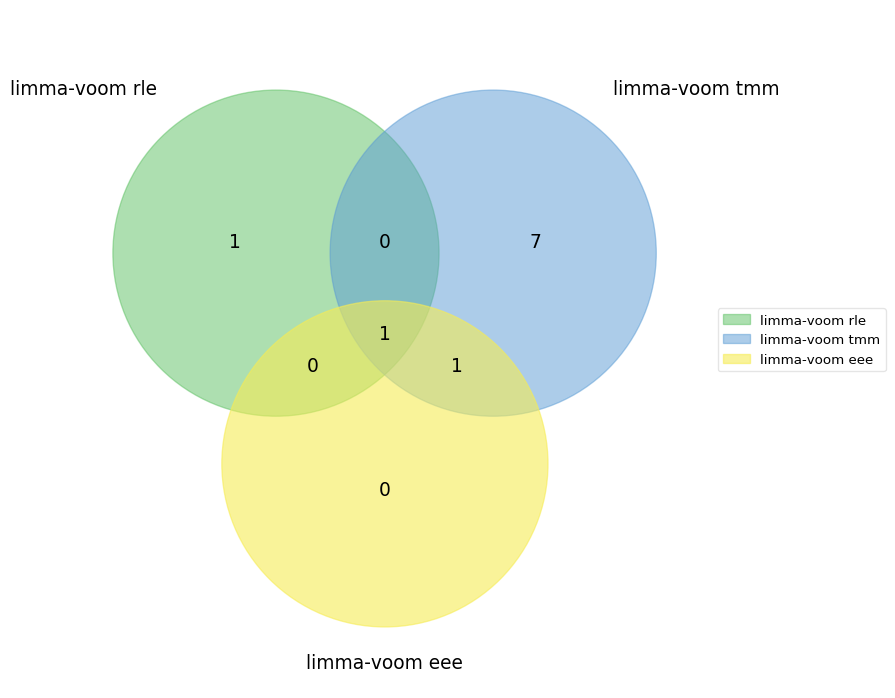

In [392]:
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in definite_tb_cm_voom_cmp.items()});

In [147]:
definite_tb_cm = with_gene_data(definite_tb_cm_voom_tmm)
definite_tb_cm.head()

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.990765  1.141511  6.277182  3.309281e-08   0.001143   
ENSG00000224789  3.561383 -1.218302  6.021654  9.125444e-08   0.001575   
ENSG00000103257  1.533484  5.871268  4.825832  8.918638e-06   0.049288   
ENSG00000130589  1.451401  7.514417  4.767670  1.104287e-05   0.049288   
ENSG00000250151  2.372412  1.262251  4.934340  5.970566e-06   0.049288   

                        B    gene_name         biotype contig strand  
ENSG00000269242  7.945509   AC010422.3  protein_coding     19      -  
ENSG00000224789  5.470512   AC012363.1       antisense      2      -  
ENSG00000103257  3.410113       SLC7A5  protein_coding     16      -  
ENSG00000130589  3.223338        HELZ2  protein_coding     20      -  
ENSG00000250151  3.472950  ARPC4-TTLL3  protein_coding      3      +

AC010422.3 keeps popping up! Although it is missing in the DESeq2 results (likely filtered out in the very first step):

In [148]:
'ENSG00000269242' in set(reference_definite_tbm_cm_deg.ensembl_id)

False

The other one (AC012363.1) is related to Inhibin beta B chain, annotated to be related to regulation of MAPK cascade.

**With independent filtering:**

TODO: independent filtering can be based on the mean for compared disease pairs only or on the mean for all samples. In the latter case it "borrows" the information on the importance of transcripts from other samples - which is usually ok; but again, we got a fairly specific setting - CSF - which makes it less obvious to explain.

In [149]:
%%R -o base_mean
samples = by_condition_and_tb_subset_no_outliers == 'Cryptococcal' | by_condition_and_tb_subset_no_outliers == 'Definite tuberculosis'
base_mean = rowMeans(tmm_normalized_tb_subsets$counts[,samples])[rownames(definite_tb_cm_voom_tmm)]

In [396]:
definite_tb_cm_cmp = {**definite_tb_cm_trend_cmp, **definite_tb_cm_voom_cmp}

In [150]:
definite_tb_cm_limma_cmp_filtered = filter_degs(definite_tb_cm_cmp, expression_col=base_mean)

Or on the mean from the entire experiment:

In [406]:
definite_tb_cm_limma_cmp_filtered = filter_degs(definite_tb_cm_cmp)

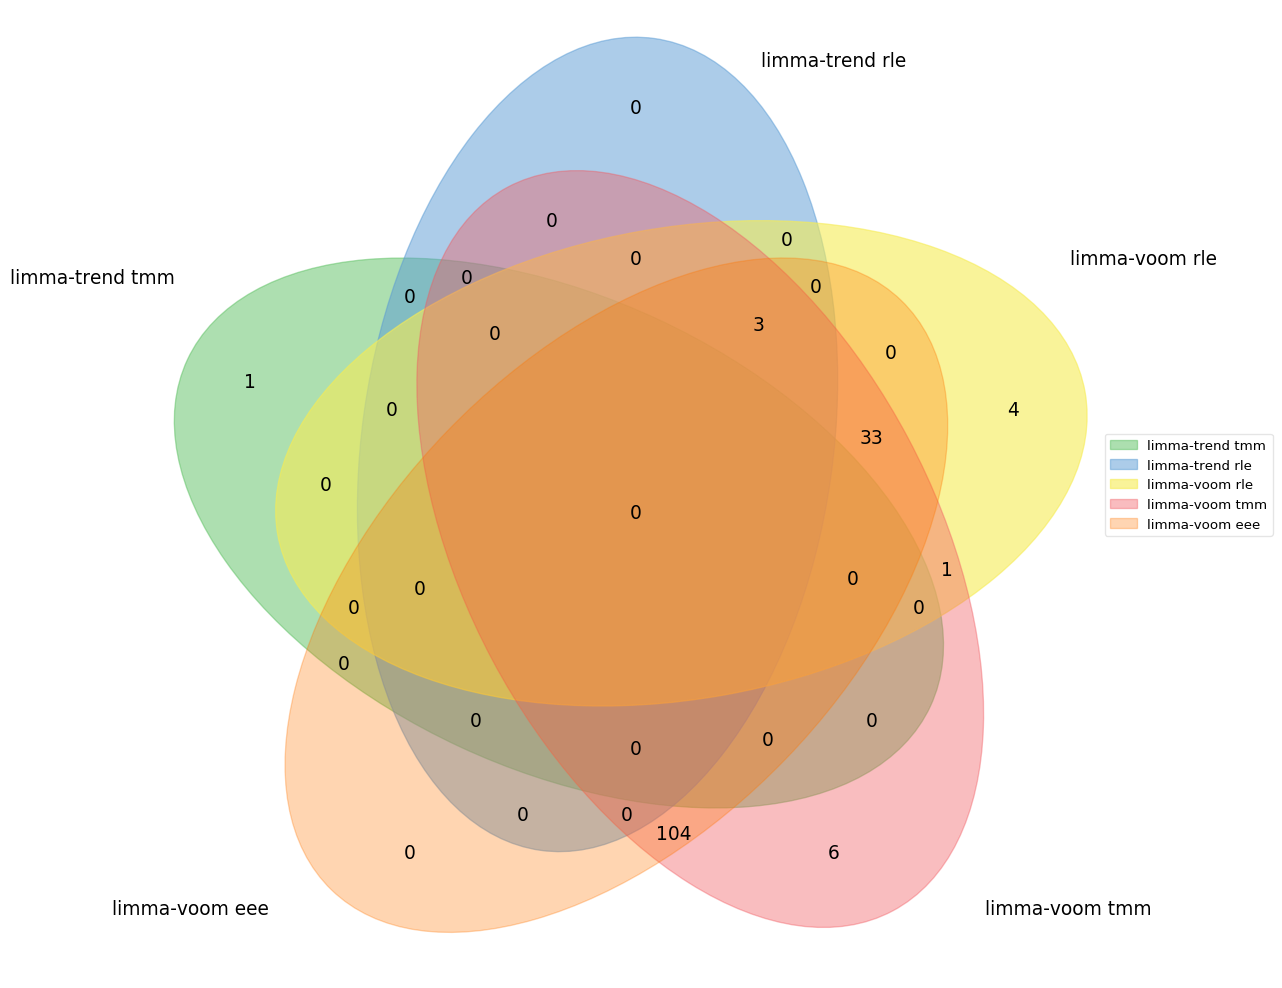

In [408]:
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in definite_tb_cm_limma_cmp_filtered.items()});

In [153]:
with_gene_data(definite_tb_cm_limma_cmp_filtered['voom_tmm'].sort_values('adj.P.Val')).head()

logFC   AveExpr         t   P.Value  adj.P.Val  ...  \
ENSG00000130589  1.451401  7.514417  4.767670  0.000011   0.012246  ...   
ENSG00000185507  1.670813  6.821759  4.725229  0.000013   0.012246  ...   
ENSG00000100226  1.224167  7.252802  4.565390  0.000023   0.012868  ...   
ENSG00000164054  1.317582  7.188089  4.519904  0.000027   0.012868  ...   
ENSG00000117298  1.443953  7.237395  4.387922  0.000043   0.016466  ...   

                 unfiltered.adj.P.Val  gene_name         biotype contig strand  
ENSG00000130589              0.049288      HELZ2  protein_coding     20      -  
ENSG00000185507              0.049475       IRF7  protein_coding     11      -  
ENSG00000100226              0.061137     GTPBP1  protein_coding     22      +  
ENSG00000164054              0.064818     SHISA5  protein_coding      3      -  
ENSG00000117298              0.072842       ECE1  protein_coding      1      -  

[5 rows x 11 columns]

### Comparing to DESeq2

- Limma-trend is more similar (than voom) to DESeq2 as both use gene-level mean-variance trend adjustment (whereas voom does it on observation-level).
- RLE normalization corresponds to the DESeq2 normalization

Thus, limma-trend with RLE is expected to agree with DESeq2 the most. Voom is expected to offer more power as it corrects the "noise" from the experimental setup better.

In [410]:
significant_deseq2 = reference_definite_tbm_cm_deg.query('padj < 0.05').ensembl_id

In [412]:
reference_definite_tbm_cm_deg.head()

ensembl_id ensembl_gene_name  \
0  ENSG00000100226            GTPBP1   
1  ENSG00000165997             ARL5B   
2  ENSG00000164691             TAGAP   
3  ENSG00000108771             DHX58   
4  ENSG00000128016             ZFP36   

                                       description     baseMean  \
0                           GTP binding protein 1    580.453924   
1          ADP ribosylation factor like GTPase 5B    222.402492   
2  T-cell activation RhoGTPase activating protein   1023.319959   
3                            DExH-box helicase 58    125.298558   
4                       ZFP36 ring finger protein   2070.881325   

   log2FoldChange     lfcSE      stat        pvalue      padj  
0        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
1        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
2        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
3        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
4        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [524]:
def get_limma_significant(data, threshold=0.05):
    return data[data['adj.P.Val'] < threshold]

def significant_ensembl(data, **kwargs):
    return get_limma_significant(data, **kwargs).index

#### Limma-trend

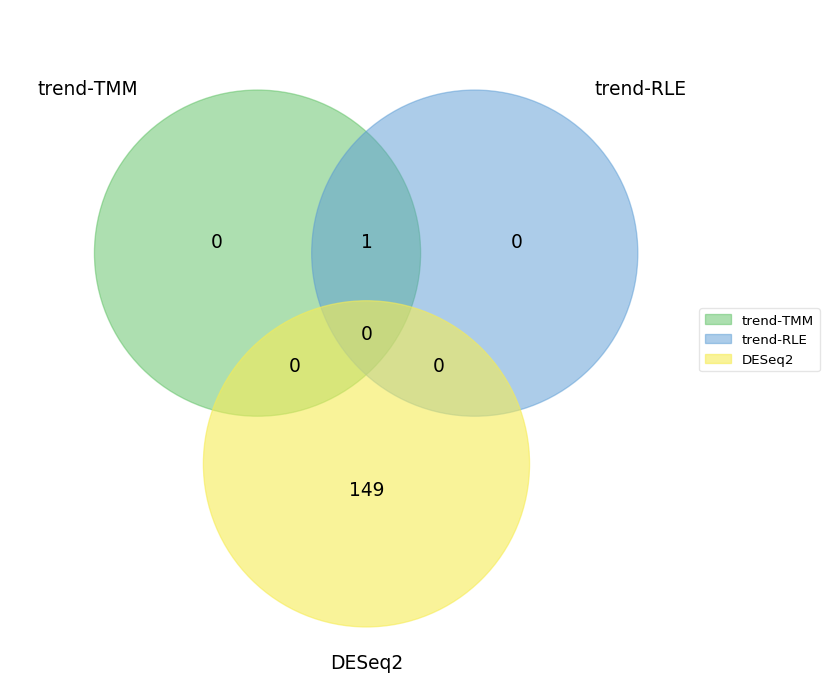

In [157]:
venn3({
    'trend-TMM': significant_ensembl(definite_tb_cm_trend_tmm),
    'trend-RLE': significant_ensembl(definite_tb_cm_trend_rle),
    'DESeq2': significant_deseq2
});

There is no intersection in significant genes and the limma-trend methods detect only of significant gene:

In [158]:
significant_definite_tb_cm_trend_tmm = significant_ensembl(definite_tb_cm_trend_tmm)
get_gene(significant_definite_tb_cm_trend_tmm[0]).gene_name

'WISP1'

Which was filtered out by independent filtering step in DESeq2:

In [159]:
reference_definite_tbm_cm_deg.query('ensembl_id in @significant_definite_tb_cm_trend_tmm')

ensembl_id ensembl_gene_name  \
8991  ENSG00000104415             WISP1   

                                      description  baseMean  log2FoldChange  \
8991  WNT1 inducible signaling pathway protein 1   22.30457       -2.882794   

         lfcSE      stat    pvalue  padj  
8991  0.623437 -4.624037  0.000004   NaN

Notably the top 15 genes of trend-RLE have a decent intersection with the top 15 of DESeq2:

In [160]:
head_deseq2 = reference_definite_tbm_cm_deg.head(15).ensembl_id
intersection = set(head_deseq2) & set(definite_tb_cm_trend_rle.head(15).index)
[get_gene(g).gene_name for g in intersection]

['DHX58', 'IRF7', 'GTPBP1', 'ECE1']

For trend-TMM - less so:

In [161]:
assert set() == set(head_deseq2) & set(definite_tb_cm_trend_tmm.head(15).index)

#### Voom

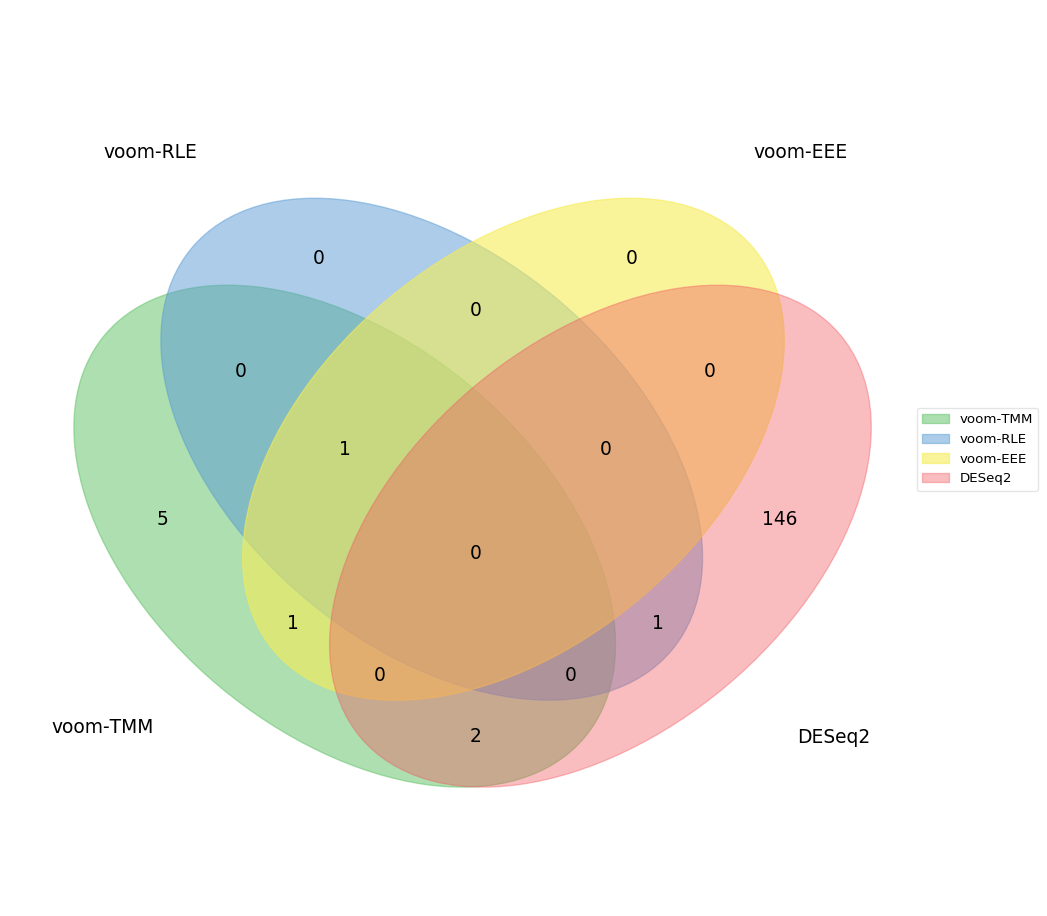

In [420]:
venn4({
    'voom-TMM': significant_ensembl(definite_tb_cm_voom_tmm),
    'voom-RLE': significant_ensembl(definite_tb_cm_voom_rle),
    'voom-EEE': significant_ensembl(definite_tb_cm_voom_eee),
    'DESeq2': significant_deseq2
});

### With independent filtering

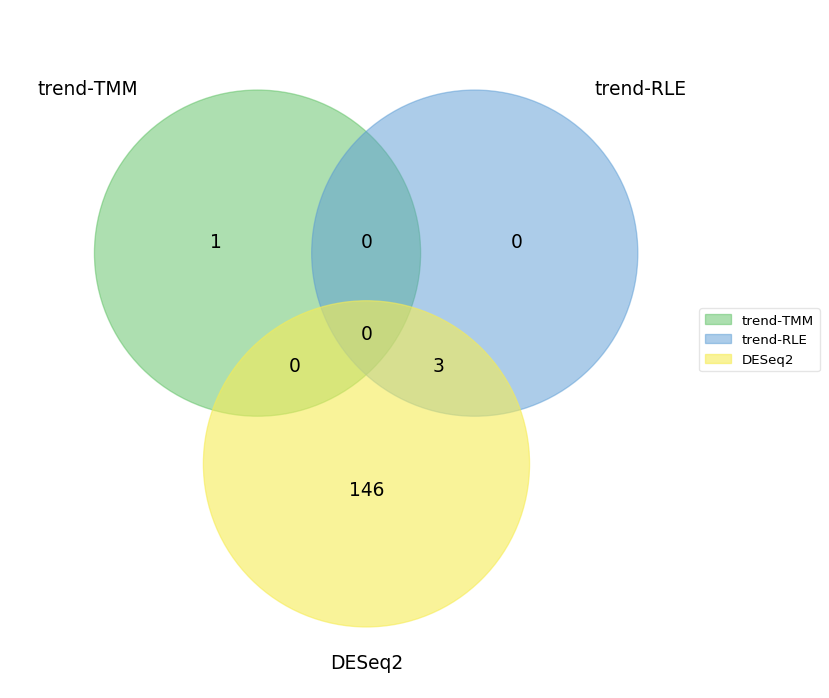

In [163]:
venn3({
    'trend-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['trend_tmm']),
    'trend-RLE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['trend_rle']),
    'DESeq2': significant_deseq2
});

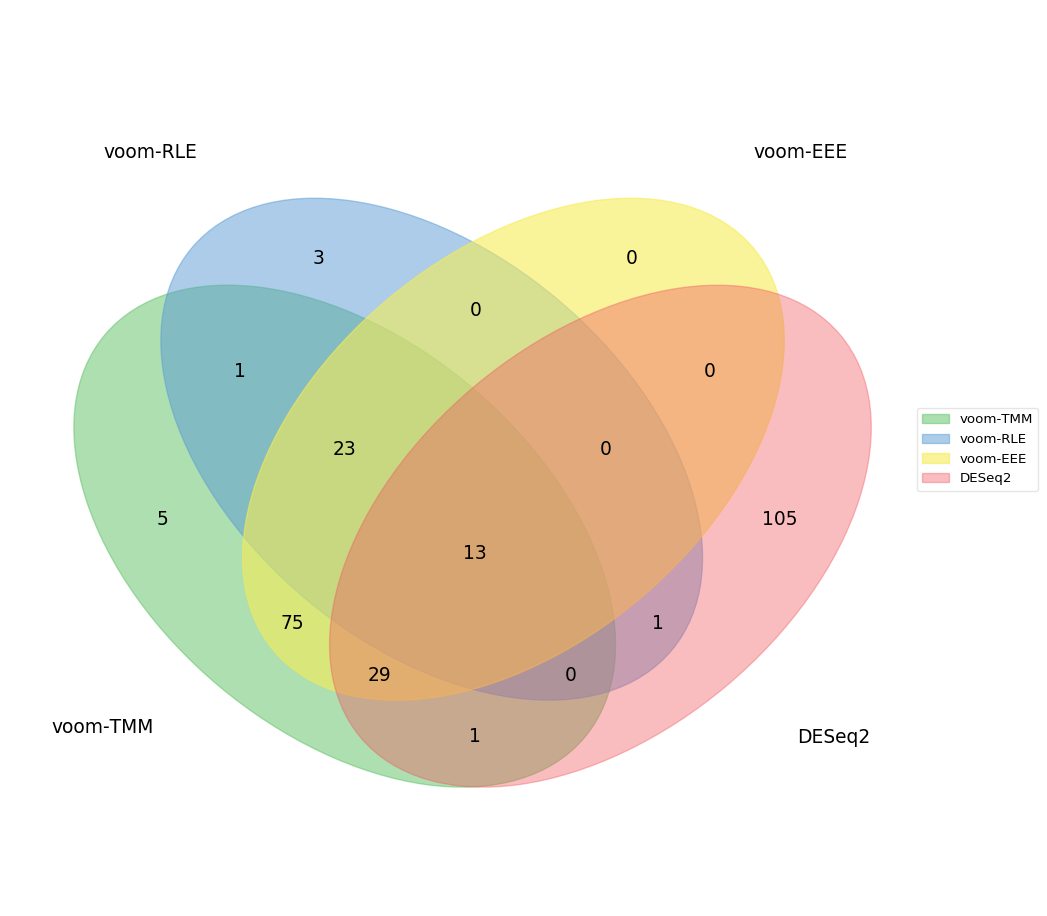

In [424]:
venn4({
    'voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']),
    'voom-RLE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_rle']),
    'voom-EEE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_eee']),
    'DESeq2': significant_deseq2
});

While one might think that voom-TMM is more closely aligned with DESeq2 than voom-RLE (which would be counterintuitive as RLE is used in DESeq2), this is not actually the case:

Ratio of voom-TMM significant genes aligned with DESeq2:

In [165]:
(30 + 13) / (30 + 13 + 24 + 80)

0.2925170068027211

Ratio of voom-RLE significant genes aligned with DESeq2:

In [166]:
(1 + 13) / (1 + 13 + 24 + 3)

0.34146341463414637

The intersection seem to have the highly DE genes enriched (which is a good thing):

In [1194]:
intersection_tmm = set(significant_deseq2) & set(significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']))

In [1196]:
comparison = concat([
    definite_tb_cm_limma_cmp_filtered['voom_tmm'][['adj.P.Val']].rename({'adj.P.Val': 'padj'}, axis=1).rank(method='first').loc[intersection_tmm].assign(method='voom-TMM'),
    reference_definite_tbm_cm_deg.set_index('ensembl_id')[['padj']].rank(method='first').loc[intersection_tmm].assign(method='DESeq2 dr Rachel'),
]).rename_axis('gene').reset_index()

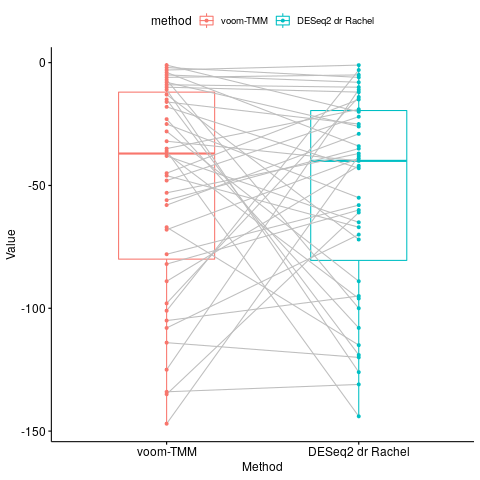

In [1197]:
%%R -i comparison
(
    ggpubr::ggpaired(
        comparison, x='method', y='-padj',
        color='method', line.color='gray', xlab='Method'
    )
)

The outliers detected in the preliminary analysis by dr Rachel are the same as detected here:

In [1230]:
%%R
reference_patients = by_condition_and_tb_subset[reference_samples, drop=F]
stopifnot(
    all(by_condition_and_tb_subset_no_outliers == reference_patients)
)

In [1620]:
%%R
get_deseq_definite_tb_cm = function(dds, ...) {
    as.data.frame(DESeq2::results(
        dds,
        contrast=c('conditions_for_deseq', 'Definite.tuberculosis', 'Cryptococcal'),
        parallel=T,
        ...)
    )
}

In [1216]:
%%R -i reference_definite_tbm_cm_deg
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]

dds_reproduction <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_matrix[
        reference_definite_tbm_cm_deg$ensembl_id, 
        reference_samples
    ]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
dds_reproduction <- DESeq2::DESeq(dds_reproduction)

converting counts to integer mode
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a

In [ ]:
%%R
library(DESeq2) # Note it seems that IHW relies on DESeq2 without proper prefixing, hence import into global namespace is necessary

In [1942]:
%%R -o deseq2_with_filtering_reproduction -o deseq2_with_weighting_reproduction
deseq2_with_filtering_reproduction = get_deseq_definite_tb_cm(dds_reproduction)
deseq2_with_weighting_reproduction = get_deseq_definite_tb_cm(dds_reproduction, filterFun=IHW::ihw)

Like-for-like comparison against voom:

In [1634]:
%%R
conditions_for_deseq = by_condition_and_tb_subset_no_outliers

dds_edger_prefiltered <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_matrix[
        rownames(c_dge_tb_subsets_filtered$counts),
        names(by_condition_and_tb_subset_no_outliers)
    ]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
dds_edger_prefiltered <- DESeq2::DESeq(dds_edger_prefiltered)

converting counts to integer mode
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a

In [1240]:
%%R -o deseq2_with_filtering -o deseq2_without_filtering -o deseq2_with_weighting
deseq2_with_filtering = get_deseq_definite_tb_cm(dds_edger_prefiltered)
deseq2_without_filtering = get_deseq_definite_tb_cm(dds_edger_prefiltered, independentFiltering=F)
deseq2_with_weighting = get_deseq_definite_tb_cm(dds_edger_prefiltered, filterFun=IHW::ihw)

In [1242]:
from itertools import combinations

In [1786]:
labels = {
    'deseq2_Rachel': 'DESeq2 from dr Rachel',
    **{
        method.lower().replace('-', '_') + id_suffix: method + suffix
        for method in ['DESeq2', 'voom-TMM', 'voom-RLE']
        for id_suffix, suffix in {
            '_no_filter': ' without filtering',
            '_filtered': ' filtered',
            '_reproduction': ' reproduced',
            '_weighted': ' weighted'
        }.items()
    }
}

deseq_cols = ['pvalue', 'padj']
voom_cols = {
    'P.Value': 'pvalue',
    'adj.P.Val': 'padj'
}

p_values = {
    **{
        f'{method_id}_filtered': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_limma_cmp_filtered.items()
    },
    **{
        f'{method_id}_no_filter': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_cmp.items()
    },
    **{
        'deseq2_filtered': deseq2_with_filtering[deseq_cols],
        'deseq2_weighted': deseq2_with_weighting[deseq_cols],
        'deseq2_reproduction': deseq2_with_filtering_reproduction[deseq_cols],
        'deseq2_no_filter': deseq2_without_filtering[deseq_cols],
        'deseq2_Rachel': reference_definite_tbm_cm_deg.set_index('ensembl_id')[deseq_cols]
    }
}

def significant_set(p_values, threshold=0.05):
    return set(p_values.query(f'padj < {threshold}').index)

def significant_union(a, b, threshold=0.05):
    return (
        significant_set(p_values[a], threshold)
        |
        significant_set(p_values[b], threshold)
    )

def get_ranks(method, subset):
    return (
        p_values[method]
        .dropna()
        .loc[subset]
        .rename_axis('gene').reset_index()
        .sort_values(['padj', 'pvalue', 'gene'])
        .set_index('gene')
        .rank(method='dense', numeric_only=True)
        .assign(method=labels[method])
    ).rename(columns={'pvalue': 'pvalue_rank'})

def corr_label(res):
    return f'corr = {res.correlation:.2f}, p = {res.pvalue:.2f}'

def generate_comparison(methods, threshold=0.05):
    df = concat([
        concat([ranks_a, ranks_b]).assign(
            contrast=f'{labels[a]} - {labels[b]}',
            corr=corr_label(spearmanr(
                ranks_a.loc[significanct_in_either]['pvalue_rank'],
                ranks_b.loc[significanct_in_either]['pvalue_rank'],
                nan_policy='omit'
            ))
        )
        for a, b in combinations(sorted(methods), 2)
        for a, b in [sorted([a, b])]
        for significanct_in_either in [significant_union(a, b, threshold)]
        for ranks_a, ranks_b in [[
            get_ranks(a, significanct_in_either).assign(side=-1),
            get_ranks(b, significanct_in_either).assign(side=+1)
        ]]
    ]).reset_index()
    df['name'] = ensembl_to_gene_name.loc[df.gene].values
    df = df.sort_values('method')
    df['method'] = pd.Categorical(df['method'], ordered=True)
    df = df.sort_values('contrast')
    df['contrast'] = pd.Categorical(df['contrast'], ordered=True)
    return df

In [1787]:
filtered_comparisons = generate_comparison(['deseq2_filtered', 'voom_tmm_filtered', 'voom_rle_filtered'])

Correlation is calculated for transcripts which were included in both compared analyses (so not rejected in pre-filtering step) and not rejected by the independent hypothesis filter:

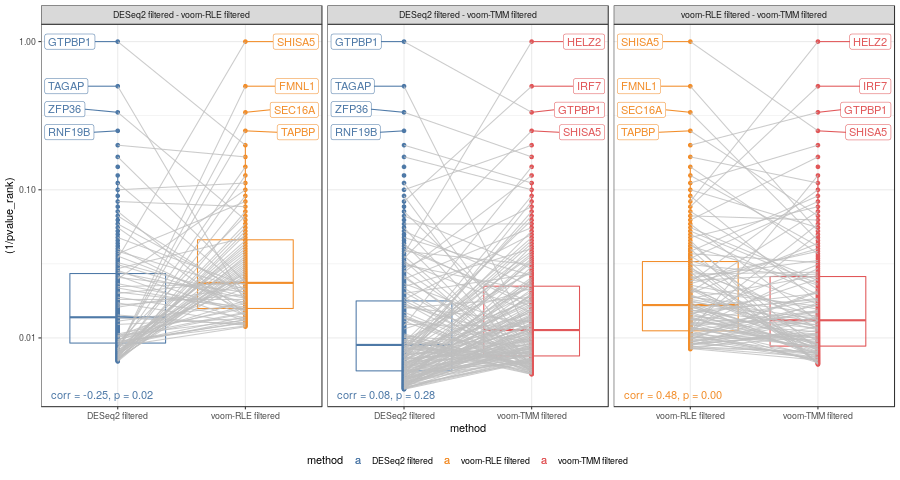

In [1788]:
%%R -i filtered_comparisons -w 900

de_comparison_pairplot = function(comparisons, label_top_n=5) {
    # paired plot
    df = na.omit(comparisons[comparisons$pvalue_rank < label_top_n,])
    (
        ggplot(na.omit(comparisons), aes(x=method, y=(1/pvalue_rank), color=method))
        + facet_wrap('contrast', scales='free_x')
        + geom_boxplot(alpha=0.2)
        + geom_point()
        + scale_y_log10()
        + geom_line(aes(group=gene), color='grey', alpha=0.8)
        + ggrepel::geom_label_repel(data=df, aes(label=name), direction='y', nudge_x=df$side)
        + nice_theme
        + scale_color_manual(values=ggthemes::tableau_color_pal('Tableau 10')(3))
        + geom_text(aes(label=corr), x=-Inf, y=-Inf, vjust=-1, hjust=-0.1, check_overlap=T)
    )
}

de_comparison_pairplot(filtered_comparisons)

In [1789]:
plain_comparisons = generate_comparison(
    ['deseq2_no_filter', 'voom_tmm_no_filter', 'voom_rle_no_filter'],
    threshold=0.1
)

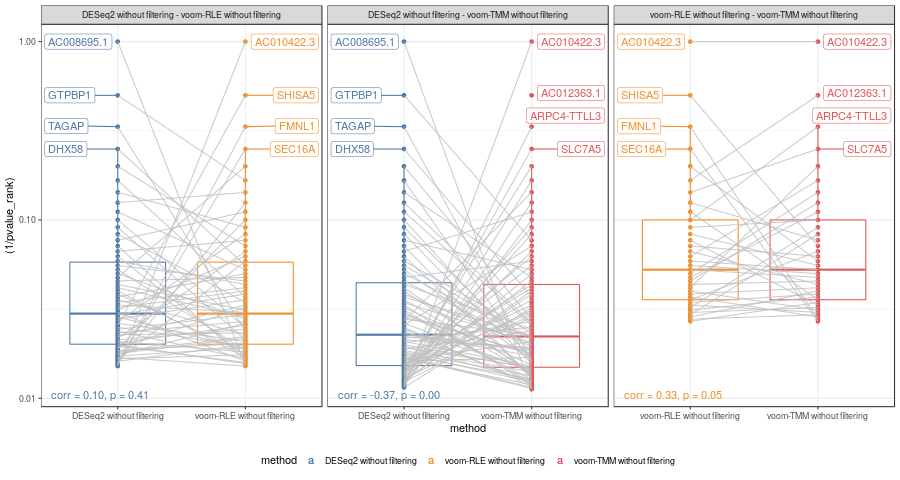

In [1792]:
%%R -i plain_comparisons -w 900
de_comparison_pairplot(plain_comparisons)

In [1794]:
deseq_comparison = generate_comparison(['deseq2_no_filter', 'deseq2_filtered', 'deseq2_Rachel'])

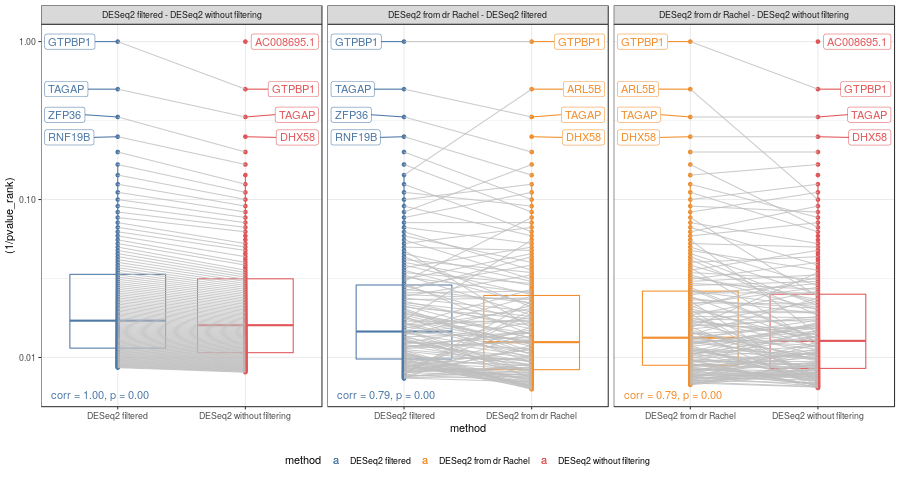

In [1795]:
%%R -i deseq_comparison -w 900
de_comparison_pairplot(deseq_comparison)

In [1796]:
reproduction_comparison = generate_comparison(['deseq2_reproduction', 'deseq2_filtered', 'deseq2_Rachel'])

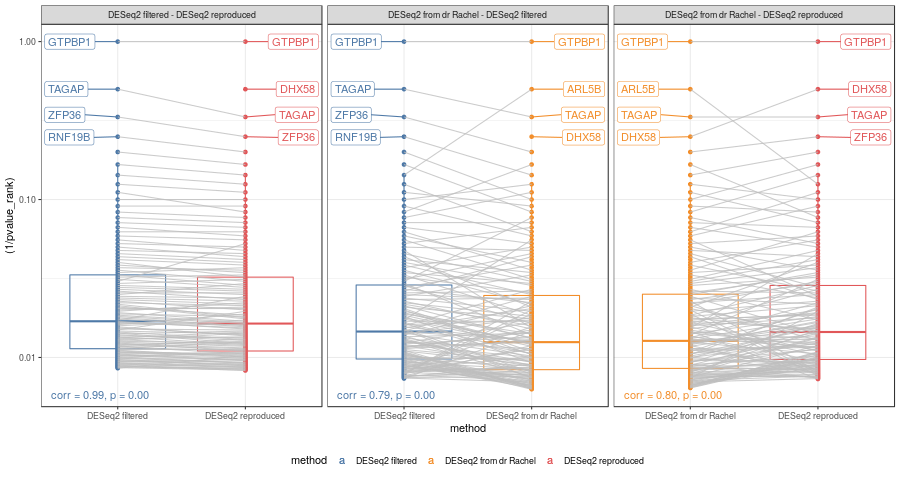

In [1797]:
%%R -i reproduction_comparison -w 900
de_comparison_pairplot(reproduction_comparison)

In [1512]:
from scipy.stats import pearsonr

In [1680]:
ref = reference_definite_tbm_cm_deg.set_index('ensembl_id')
repro = deseq2_with_filtering_reproduction.loc[ref.index]
pearsonr(repro['log2FoldChange'], ref['log2FoldChange'])

(0.9884259288818367, 0.0)

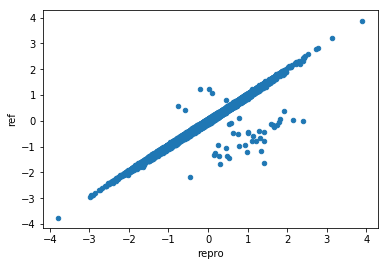

In [1681]:
df = with_gene_data(DataFrame(dict(
    repro=repro['log2FoldChange'],
    ref=ref['log2FoldChange']
)), sort=False)
df.plot.scatter(x='repro', y='ref');

Interesting..

In [1712]:
df['difference'] = abs(df.repro - df.ref)
df['p_ref'] = ref['padj']
df['p_repro'] = repro['padj']
df['voom'] = definite_tb_cm_limma_cmp_filtered['voom_tmm'].loc[ref.index].logFC

In [1714]:
from scipy.stats import zscore

In [1715]:
lfc_outliers = df[zscore(df.difference) > 2]
show_table(lfc_outliers.sort_values('difference'))

repro       ref   gene_name  \
ENSG00000211892  0.450181  0.798702  IGHG4        
ENSG00000132463  0.535183 -0.119796  GRSF1        
ENSG00000188542  0.584919 -0.077051  DUSP28       
ENSG00000100307  0.782972  0.096994  CBX7         
ENSG00000211938  0.108468  1.074797  IGHV3-7      
ENSG00000252010 -0.579511  0.415941  SCARNA5      
ENSG00000211890  0.627704 -0.452663  IGHA2        
ENSG00000170448  0.255641 -0.923274  NFXL1        
ENSG00000224650  0.028125  1.218261  IGHV3-74     
ENSG00000119969  0.760992 -0.524589  HELLS        
ENSG00000211955 -0.749624  0.569888  IGHV3-33     
ENSG00000242049  0.184276 -1.236904  DNAJB8-AS1   
ENSG00000211895  1.021719 -0.415987  IGHA1        
ENSG00000211653 -0.213651  1.251059  IGLV1-40     
ENSG00000084764  0.142140 -1.325527  MAPRE3       
ENSG00000279796  1.009205 -0.470974  AL133384.2   
ENSG00000260644  0.466668 -1.046711  HERC2P5      
ENSG00000167513  1.924596  0.365181  CDT1         
ENSG00000230701  0.269321 -1.379538  FBXW4P1      
ENSG00000126583  1.281556 -0.376443  PRKCG        
ENSG00000146677  1.580066 -0.116122  AC004453.1   
ENSG00000237480 -0.460603 -2.159984  AL355306.2   
ENSG00000174640  1.126453 -0.596179  SLCO2A1      
ENSG00000253755  1.822637  0.082716  IGHGP        
ENSG00000142549  0.778363 -0.991390  IGLON5       
ENSG00000271811  1.654031 -0.163345  Z97200.1     
ENSG00000184076  1.421570 -0.414666  UQCR10       
ENSG00000266691  1.784161 -0.064294  AC138761.5   
ENSG00000077498  0.926544 -0.930783  TYR          
ENSG00000078725  0.489452 -1.375846  BRINP1       
ENSG00000136930  1.742626 -0.145880  PSMB7        
ENSG00000253417  1.118297 -0.792920  LINC02159    
ENSG00000235472  1.665747 -0.256422  EIF4A1P7     
ENSG00000124780  1.308107 -0.648201  KCNK17       
ENSG00000272808  0.533804 -1.423718  AC015712.6   
ENSG00000213727  1.213750 -0.762339  AP000533.1   
ENSG00000187537  0.304939 -1.684169  POTEG        
ENSG00000176566  2.146748  0.042305  DCAF4L2      
ENSG00000185689  1.406150 -0.771564  C6orf201     
ENSG00000183632  0.996831 -1.192830  TP53TG3      
ENSG00000102452  2.409962 -0.014653  NALCN        
ENSG00000237821  1.327329 -1.159325  AC083873.1   
ENSG00000232150  1.403217 -1.622115  ST13P4       

                                            biotype contig strand  difference  \
ENSG00000211892  IG_C_gene                           14     -      0.348521     
ENSG00000132463  protein_coding                      4      -      0.654979     
ENSG00000188542  protein_coding                      2      +      0.661970     
ENSG00000100307  protein_coding                      22     -      0.685978     
ENSG00000211938  IG_V_gene                           14     -      0.966328     
ENSG00000252010  scaRNA                              2      +      0.995452     
ENSG00000211890  IG_C_gene                           14     -      1.080368     
ENSG00000170448  protein_coding                      4      -      1.178915     
ENSG00000224650  IG_V_gene                           14     -      1.190136     
ENSG00000119969  protein_coding                      10     +      1.285581     
ENSG00000211955  IG_V_gene                           14     -      1.319512     
ENSG00000242049  antisense                           3      +      1.421180     
ENSG00000211895  IG_C_gene                           14     -      1.437706     
ENSG00000211653  IG_V_gene                           22     +      1.464710     
ENSG00000084764  protein_coding                      2      +      1.467666     
ENSG00000279796  TEC                                 10     -      1.480179     
ENSG00000260644  transcribed_unprocessed_pseudogene  16     +      1.513379     
ENSG00000167513  protein_coding                      16     +      1.559415     
ENSG00000230701  processed_pseudogene                22     +      1.648859     
ENSG00000126583  protein_coding                      19     +      1.657998     
ENSG00000146677  processed_pseudogene                7      +      1.69618

Fortunately, none of the genes with flipping fold-changes were nominated as significant.

First guess: something related to shrinkage must have changed in DESeq2 in between the two analyzes.

Relevant posts:
 - https://support.bioconductor.org/p/100978/
 - https://support.bioconductor.org/p/75330/
 - https://support.bioconductor.org/p/85373/
 
Also:
 > Here we extend the discussion of shrinkage estimators. To repeat, the current default method in lfcShrink is normal, although it will likely change in the October 2018 release to apeglm, as this method has improved performance relative to the original DESeq2 estimator, as does ashr in some of our benchmarks. Below is a summary table of differences between methods available in lfcShrink via the type argument (and for further technical reference on use of arguments please see ?lfcShrink):

And more importantly:
 
> In version 1.16 (November 2016), the log2 fold change shrinkage is no longer default for the DESeq and nbinomWaldTest functions, by setting the defaults of these to betaPrior=FALSE, and by introducing a separate function lfcShrink, which performs log2 fold change shrinkage for visualization and ranking of genes. While for the majority of bulk RNA-seq experiments, the LFC shrinkage did not affect statistical testing, DESeq2 has become used as an inference engine by a wider community, and certain sequencing datasets show better performance with the testing separated from the use of the LFC prior. Also, the separation of LFC shrinkage to a separate function lfcShrink allows for easier methods development of alternative effect size estimators.

 (http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

It's not ashr shrinkage, for certain:

In [1622]:
%%R -o res
res <- as.data.frame(lfcShrink(
    dds_edger_prefiltered,
    contrast=c('conditions_for_deseq', 'Definite.tuberculosis', 'Cryptococcal'),
    type="ashr"
))

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


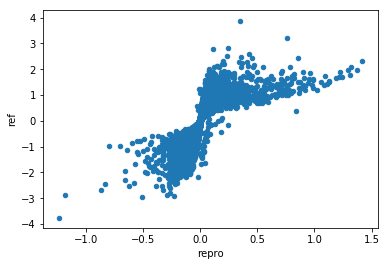

In [1616]:
df = with_gene_data(DataFrame(dict(
    repro=res.loc[ref.index]['log2FoldChange'],
    ref=ref['log2FoldChange']
)), sort=False)
df.plot.scatter(x='repro', y='ref');

In [1861]:
%%R -o res
shrunk_normal_lfc <- as.data.frame(lfcShrink(
    dds_edger_prefiltered,
    contrast=c('conditions_for_deseq', 'Definite tuberculosis', 'Cryptococcal'),
    type="normal"
))
res = shrunk_normal_lfc

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).
additional priors are available via the 'type' argument, see ?lfcShrink for details


Normal shrinkage changes things a little bit:

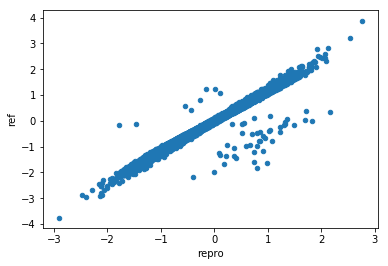

In [1650]:
df = with_gene_data(DataFrame(dict(
    repro=res.loc[ref.index]['log2FoldChange'],
    ref=ref['log2FoldChange']
)), sort=False)
df.plot.scatter(x='repro', y='ref');

Also, how does it look like for voom?

In [1708]:
definite_tb_cm_limma_cmp_filtered['voom_tmm'].loc[lfc_outliers.index].sort_values('P.Value')

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000237480 -1.638620  1.755167 -2.998031  0.003858        NaN -1.973117   
ENSG00000224650  2.706474  1.622972  2.449491  0.018069        NaN -3.128040   
ENSG00000272808 -0.995549  2.363321 -1.912143  0.060307        NaN -4.039648   
ENSG00000211895  1.778796  8.572389  1.924475  0.060869   0.135193 -4.295185   
ENSG00000211890  1.690657  6.858361  1.893763  0.064931   0.139169 -4.311502   
...                   ...       ...       ...       ...        ...       ...   
ENSG00000174640  0.075457  1.883128  0.116628  0.907518        NaN -5.391943   
ENSG00000146677 -0.054824  0.453407 -0.105383  0.916400        NaN -5.358293   
ENSG00000102452 -0.033391  1.561763 -0.042161  0.966501        NaN -5.373010   
ENSG00000185689  0.015903  1.053453  0.024704  0.980368        NaN -5.405566   
ENSG00000077498  0.012029  0.803997  0.017509  0.986085        NaN -5.365287   

                 unfiltered.adj.P.Val  
ENSG00000237480              0.235724  
ENSG00000224650              0.336297  
ENSG00000272808              0.444227  
ENSG00000211895              0.444856  
ENSG00000211890              0.453051  
...                               ...  
ENSG00000174640              0.974959  
ENSG00000146677              0.978201  
ENSG00000102452              0.990691  
ENSG00000185689              0.995042  
ENSG00000077498              0.996650  

[43 rows x 7 columns]

No worrying significant hits either, so these could be some unstable cases...

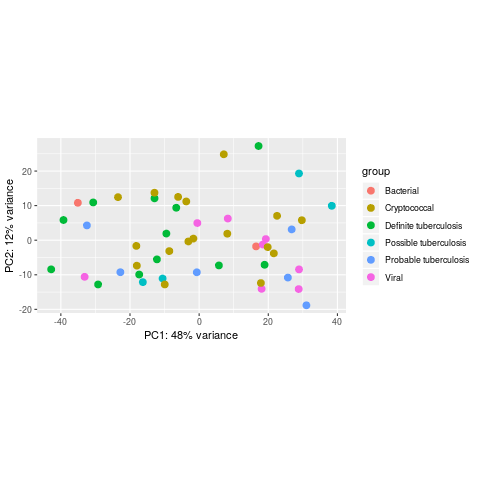

In [1588]:
%%R
vsd <- vst(dds_edger_prefiltered, blind=FALSE)
plotPCA(vsd, intgroup='conditions_for_deseq')

The first few DE genes have good correspondence, but the remaining ones are quite shuffled.

### Finally, with weighted p-values:

In [430]:
definite_tb_cm_limma_cmp_weighted = weight_degs(definite_tb_cm_cmp)

We get slightly smaller overlap with DESeq2 and slightly fewer DE genes, but gain some interesting hits for genes which are not as highly expressed:

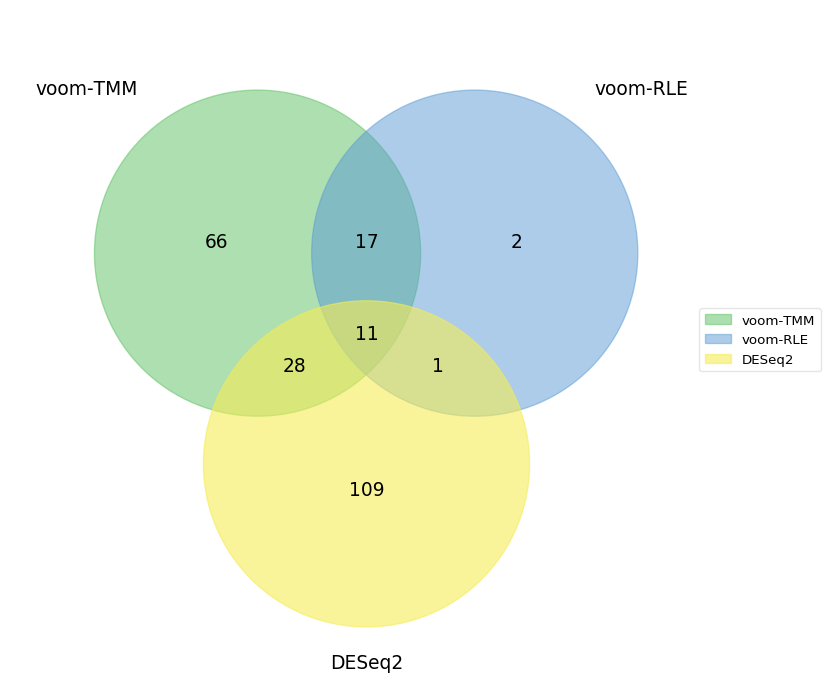

In [171]:
venn3({
    'voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_weighted['voom_tmm']),
    'voom-RLE': significant_ensembl(definite_tb_cm_limma_cmp_weighted['voom_rle']),
    'DESeq2': significant_deseq2
});

In [1804]:
p_values = {
    **{
        f'{method_id}_weighted': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_limma_cmp_weighted.items()
    },
    **p_values
}

In [1805]:
weighted_comparisons = generate_comparison(['deseq2_weighted', 'voom_tmm_weighted', 'voom_rle_weighted'])

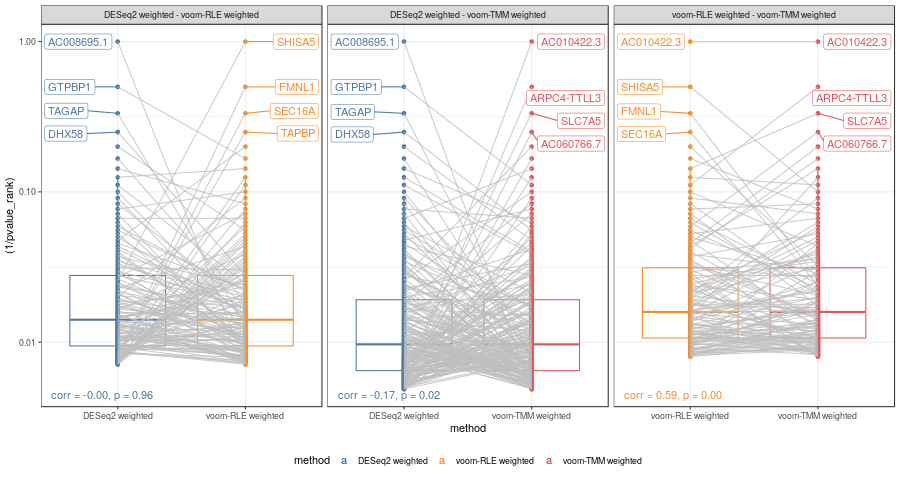

In [1806]:
%%R -i weighted_comparisons -w 900

de_comparison_pairplot(weighted_comparisons)

### An attempt to use IHW for gene sets analysis

In [172]:
voom_de = definite_tb_cm_limma_cmp_weighted['voom_tmm']

In [173]:
%%R -o voom_de_gene_sets -i voom_de
voom_de_gene_sets = camera_with_statistic(voom_de, 't', reactome_new_symbol)

In [174]:
%%R -o voom_de_gene_sets_weighted
voom_de$weighted_stat <- voom_de$adj.P.Val * sign(voom_de$t)
voom_de_gene_sets_weighted = camera_with_statistic(voom_de, 'weighted_stat', reactome_new_symbol)

In [175]:
%%R -o voom_de_gene_sets_unweighted
voom_de$unweighted_stat <- voom_de$unweighted.adj.P.Val * sign(voom_de$t)
voom_de_gene_sets_unweighted = camera_with_statistic(voom_de, 'unweighted_stat', reactome_new_symbol)

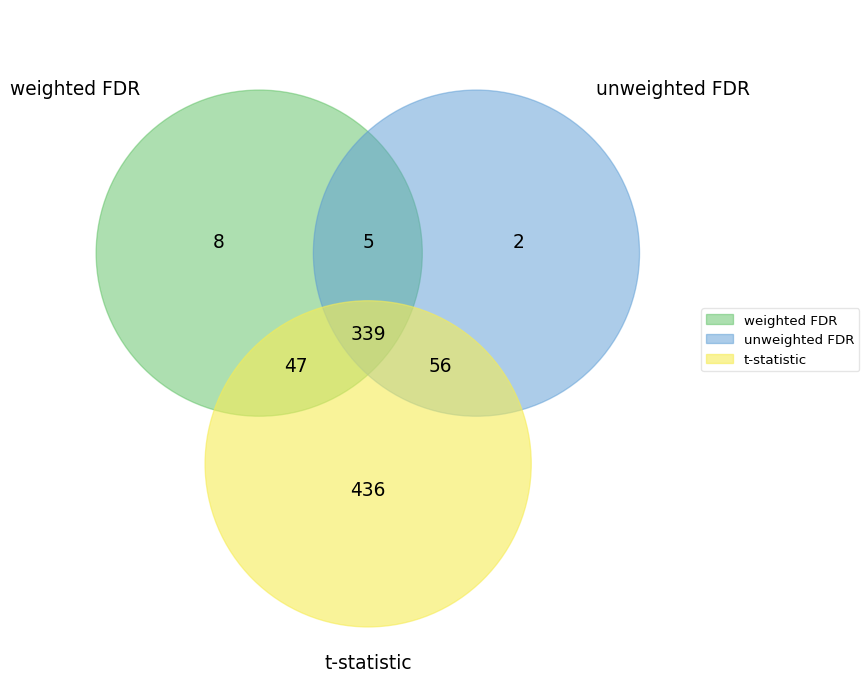

In [176]:
sig = lambda x: set(x[x.FDR < 0.05].index)
sets_comparison = {
    'weighted FDR': sig(voom_de_gene_sets_weighted),
    'unweighted FDR': sig(voom_de_gene_sets_unweighted),
    't-statistic': sig(voom_de_gene_sets)
}
venn3(sets_comparison);

In [177]:
sets_comparison['weighted FDR'] - sets_comparison['unweighted FDR'] - sets_comparison['t-statistic']

{'DNA strand elongation',
 'Defective B4GALT1 causes B4GALT1-CDG (CDG-2d)',
 'Lagging Strand Synthesis',
 'Neurotoxicity of clostridium toxins',
 'Purine salvage',
 'RNA Polymerase III Chain Elongation',
 'Regulation of gene expression in beta cells',
 'Telomere C-strand (Lagging Strand) Synthesis'}

In [178]:
sets_comparison['weighted FDR'] - sets_comparison['t-statistic']

{'Activation of ATR in response to replication stress',
 'DNA strand elongation',
 'Defective B4GALT1 causes B4GALT1-CDG (CDG-2d)',
 'Extension of Telomeres',
 'Formation of tubulin folding intermediates by CCT/TriC',
 'Lagging Strand Synthesis',
 'Lipid particle organization',
 'Molybdenum cofactor biosynthesis',
 'Neurotoxicity of clostridium toxins',
 'Purine salvage',
 'RNA Polymerase III Chain Elongation',
 'Regulation of gene expression in beta cells',
 'Telomere C-strand (Lagging Strand) Synthesis'}

In [179]:
comparison = concat([
    voom_de_gene_sets_unweighted.query('FDR < 0.05')[['FDR']].rank(method='first').assign(method='unweighted FDR'),
    voom_de_gene_sets.query('FDR < 0.05')[['FDR']].rank(method='first').assign(method='t-statistic')
]).rename_axis('pathway').reset_index()

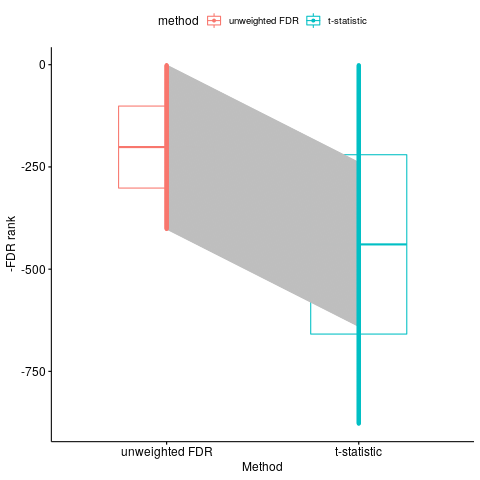

In [180]:
%%R -i comparison
(
    ggpubr::ggpaired(
        comparison, x='method', y='-FDR',
        color='method', line.color='gray',
        xlab='Method', ylab='-FDR rank'
    )
)

This is very bad. I got a better idea: apply `genefilter()` on mean pathway expression level!

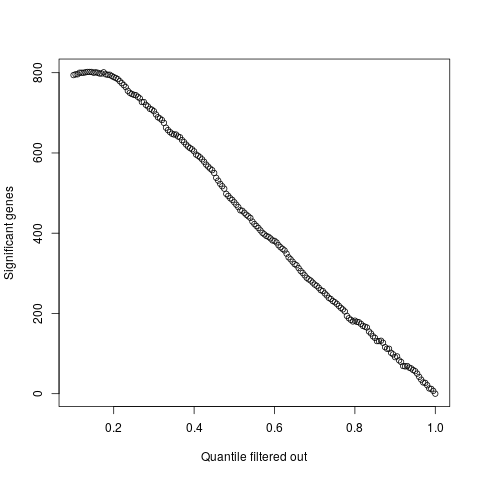

In [181]:
%%R
import::here(average_pathways_expression, .from='helpers/pathways.R')

voom_de_gene_sets$AveExpr = average_pathways_expression(
    tmm_normalized_tb_subsets, collection=reactome_new_symbol, id_type='symbol',
    pathways_subset=rownames(voom_de_gene_sets)
)

filter_by_mean_expression(voom_de_gene_sets, fdr_threshold=0.05, step=0.005, expression_col='AveExpr', pvalue_col='FDR', show_plot=T, use_deseq2_method=F)

It does increase power at $\theta \approx 0.1$ maybe?

In [182]:
voom_de_gene_sets

NGenes Direction  \
Neutrophil degranulation                             460.0        Up   
Interferon Signaling                                 198.0        Up   
Interferon alpha/beta signaling                       69.0        Up   
CLEC7A (Dectin-1) signaling                           98.0        Up   
Interferon gamma signaling                            91.0        Up   
...                                                    ...       ...   
Cation-coupled Chloride cotransporters                 7.0        Up   
Heme biosynthesis                                     11.0      Down   
Activation of PPARGC1A (PGC-1alpha) by phosphor...    10.0      Down   
Glycosaminoglycan metabolism                         122.0      Down   
Biotin transport and metabolism                       11.0        Up   

                                                          PValue           FDR  
Neutrophil degranulation                            3.133880e-16  4.580447e-13  
Interferon Signaling                                5.582507e-16  4.580447e-13  
Interferon alpha/beta signaling                     1.287081e-15  7.040334e-13  
CLEC7A (Dectin-1) signaling                         1.690526e-13  6.551377e-11  
Interferon gamma signaling                          1.996154e-13  6.551377e-11  
...                                                          ...           ...  
Cation-coupled Chloride cotransporters              9.934585e-01  9.957691e-01  
Heme biosynthesis                                   9.939487e-01  9.957691e-01  
Activation of PPARGC1A (PGC-1alpha) by phosphor...  9.984073e-01  9.990163e-01  
Glycosaminoglycan metabolism                        9.984075e-01  9.990163e-01  
Biotin transport and metabolism                     9.994624e-01  9.994624e-01  

[1641 rows x 4 columns]

In [183]:
%%R -o voom_de_gene_sets
voom_de_gene_sets$weighted_fdr = filter_by_mean_expression(voom_de_gene_sets, fdr_threshold=0.05, step=0.005, expression_col='AveExpr', pvalue_col='FDR', show_plot=F)

In [184]:
weighted_signif = voom_de_gene_sets[voom_de_gene_sets.weighted_fdr < 0.05]

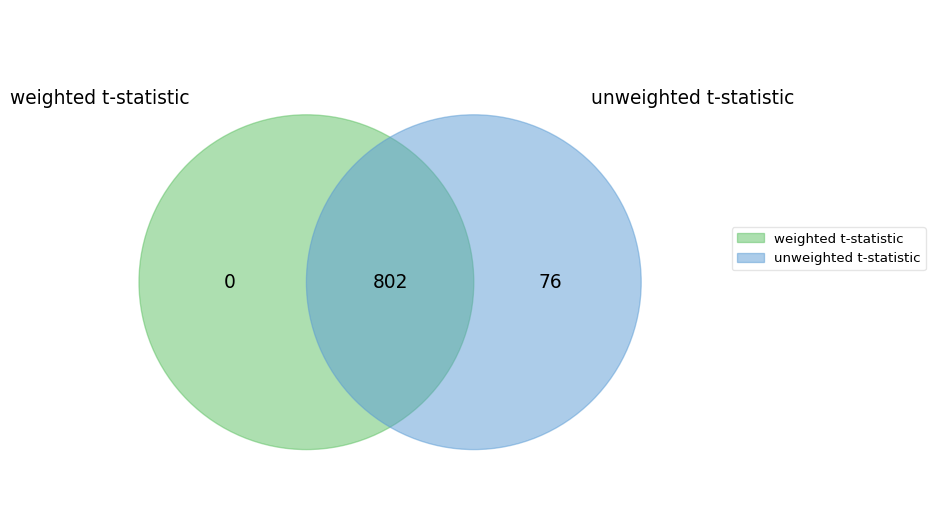

In [185]:
sets_comparison = {
    'weighted t-statistic': weighted_signif.index,
    'unweighted t-statistic': sig(voom_de_gene_sets)
}
venn2(sets_comparison);

In [186]:
voom_de_gene_sets.loc[
    sets_comparison['unweighted t-statistic'] - set(weighted_signif.index)
]

NGenes Direction  \
phosphorylation site mutants of CTNNB1 are not ...    15.0        Up   
Misspliced GSK3beta mutants stabilize beta-catenin    15.0        Up   
Attenuation phase                                     26.0        Up   
Defective CHST6 causes MCDC1                           8.0      Down   
Conversion from APC/C:Cdc20 to APC/C:Cdh1 in la...    19.0        Up   
...                                                    ...       ...   
Signaling by ERBB4                                    45.0        Up   
GAB1 signalosome                                      17.0        Up   
SMAC, XIAP-regulated apoptotic response                8.0        Up   
EPHA-mediated growth cone collapse                    15.0        Up   
T41 mutants of beta-catenin aren't phosphorylated     15.0        Up   

                                                      PValue       FDR  \
phosphorylation site mutants of CTNNB1 are not ...  0.015944  0.031485   
Misspliced GSK3beta mutants stabilize beta-catenin  0.015944  0.031485   
Attenuation phase                                   0.021094  0.040533   
Defective CHST6 causes MCDC1                        0.009355  0.019757   
Conversion from APC/C:Cdc20 to APC/C:Cdh1 in la...  0.022995  0.043424   
...                                                      ...       ...   
Signaling by ERBB4                                  0.024027  0.045215   
GAB1 signalosome                                    0.015204  0.030426   
SMAC, XIAP-regulated apoptotic response             0.022054  0.042131   
EPHA-mediated growth cone collapse                  0.014279  0.028857   
T41 mutants of beta-catenin aren't phosphorylated   0.015944  0.031485   

                                                     AveExpr  weighted_fdr  
phosphorylation site mutants of CTNNB1 are not ...  0.009469      0.054352  
Misspliced GSK3beta mutants stabilize beta-catenin  0.009469      0.054352  
Attenuation phase                                   0.010986      0.068148  
Defective CHST6 causes MCDC1                       -0.004989           NaN  
Conversion from APC/C:Cdc20 to APC/C:Cdh1 in la...  0.001144      0.071733  
...                                                      ...           ...  
Signaling by ERBB4                                  0.003193      0.074432  
GAB1 signalosome                                    0.010653      0.053171  
SMAC, XIAP-regulated apoptotic response             0.005180      0.070417  
EPHA-mediated growth cone collapse                  0.036132      0.050931  
T41 mutants of beta-catenin aren't phosphorylated   0.009469      0.054352  

[76 rows x 6 columns]

In [187]:
%%R -o x -i voom_de_gene_sets
samples = by_condition_and_tb_subset_no_outliers == 'Cryptococcal' | by_condition_and_tb_subset_no_outliers == 'Definite tuberculosis'


voom_de_gene_sets$AveExpr = average_pathways_expression(
    tmm_normalized_tb_subsets, collection=reactome_new_symbol, id_type='symbol',
    pathways_subset=rownames(voom_de_gene_sets),
    #patients_subset=samples
)

x = add_p_value_for_filtered_subset(voom_de_gene_sets, fdr_threshold=0.05, expression_col='AveExpr', pvalue_col='PValue')
#, step=0.005, show_plot=T, use_deseq2_method=F)

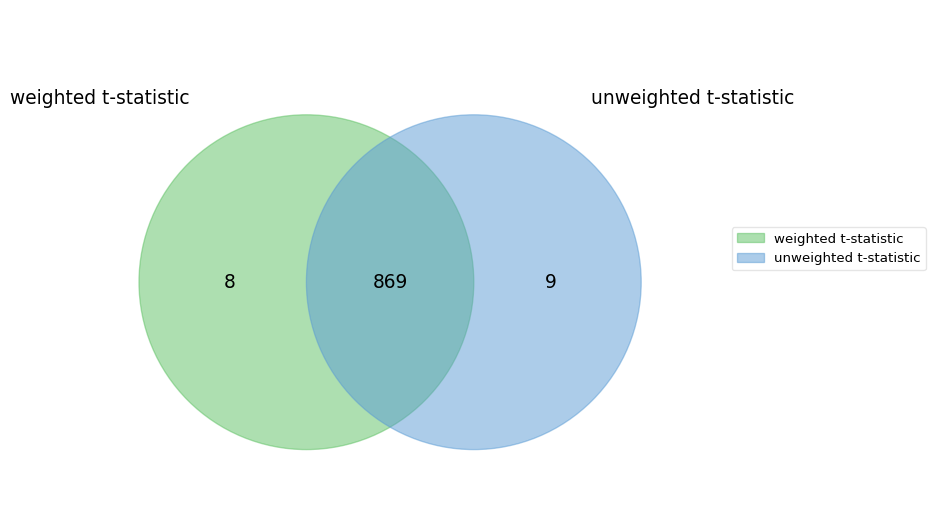

In [188]:
sets_comparison = {
    'weighted t-statistic': x[x['adj.P.Val'] < 0.05].index,
    'unweighted t-statistic': sig(voom_de_gene_sets)
}
venn2(sets_comparison);

In [189]:
x.loc[
    set(x[x['adj.P.Val'] < 0.05].index) - sig(voom_de_gene_sets)
]

NGenes Direction  \
Protein-protein interactions at synapses              88.0      Down   
Recycling of eIF2:GDP                                  8.0        Up   
NRAGE signals death through JNK                       59.0        Up   
Extension of Telomeres                                30.0        Up   
SHC1 events in EGFR signaling                         14.0        Up   
Synthesis of PIPs at the Golgi membrane               17.0        Up   
Factors involved in megakaryocyte development a...   136.0        Up   
Rap1 signalling                                       16.0        Up   

                                                      PValue       FDR  \
Protein-protein interactions at synapses            0.030257  0.055914   
Recycling of eIF2:GDP                               0.027410  0.051056   
NRAGE signals death through JNK                     0.027683  0.051505   
Extension of Telomeres                              0.026823  0.050075   
SHC1 events in EGFR signaling                       0.029034  0.053959   
Synthesis of PIPs at the Golgi membrane             0.029514  0.054726   
Factors involved in megakaryocyte development a...  0.030148  0.055776   
Rap1 signalling                                     0.027340  0.050983   

                                                     AveExpr  weighted_fdr  \
Protein-protein interactions at synapses            0.000448      0.090780   
Recycling of eIF2:GDP                               0.006685      0.083370   
NRAGE signals death through JNK                     0.002952      0.084007   
Extension of Telomeres                             -0.000775           NaN   
SHC1 events in EGFR signaling                       0.003010      0.087908   
Synthesis of PIPs at the Golgi membrane             0.005603      0.089055   
Factors involved in megakaryocyte development a...  0.000875      0.090660   
Rap1 signalling                                     0.017096      0.083347   

                                                    adj.P.Val  
Protein-protein interactions at synapses             0.049818  
Recycling of eIF2:GDP                                0.045391  
NRAGE signals death through JNK                      0.045789  
Extension of Telomeres                               0.044519  
SHC1 events in EGFR signaling                        0.047970  
Synthesis of PIPs at the Golgi membrane              0.048706  
Factors involved in megakaryocyte development a...   0.049696  
Rap1 signalling                                      0.045327

### Comparing overlap of different gene set collections

In [190]:
%%R -o sets_reactome_symbols -i voom_de -o sets_reactome_entrez -o sets_kegg_entrez
sets_reactome_symbols = camera_with_statistic(voom_de, 't', reactome_new_symbol, convert_to='symbol')
sets_reactome_entrez = camera_with_statistic(voom_de, 't', c2.cp.reactome, convert_to='entrez')
sets_kegg_entrez = camera_with_statistic(voom_de, 't', c2.cp.kegg, convert_to='entrez')

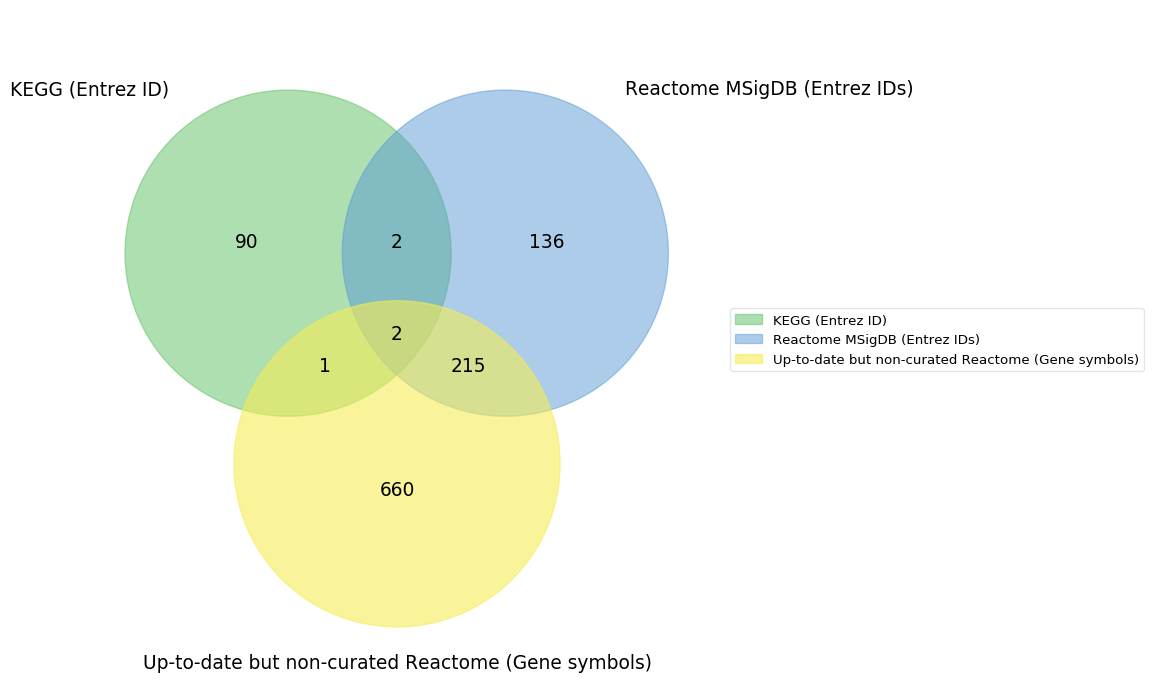

In [191]:
sig = lambda x: set(x[x.FDR < 0.05].index.str.lower())
sets_comparison = {
    'KEGG (Entrez ID)': sig(sets_kegg_entrez),
    'Reactome MSigDB (Entrez IDs)': sig(sets_reactome_entrez),
    'Up-to-date but non-curated Reactome (Gene symbols)': sig(sets_reactome_symbols)
}
venn3(sets_comparison);

### A heatmap demonstaration & test

In [192]:
%R import::here(gene_set_heatmap, .from='plots/differential_expression.R')

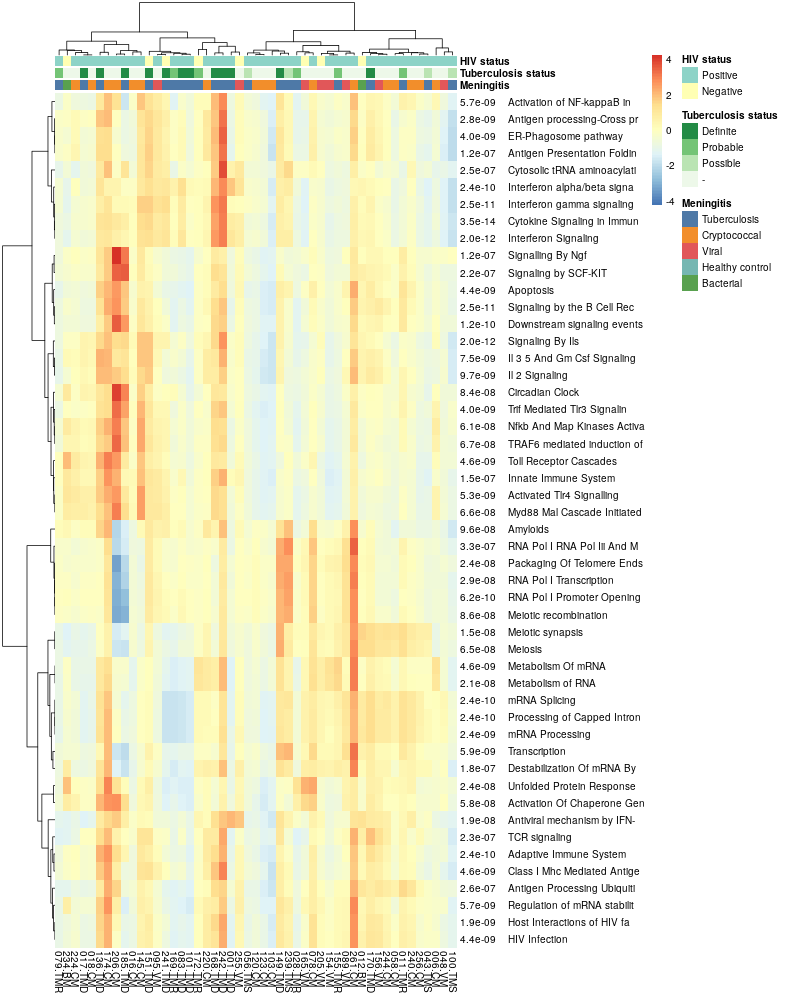

In [193]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_reactome_entrez, 50), tmm_normalized_tb_subsets,
    collection=c2.cp.reactome, id_type='entrez'
)

Note: changing dynamics of the meiosis/apoptosis cannot be observed in the study which looks at the participants in a single time-point...

But maybe I could look at the participants survival, and some proxy for disease stage and it's relation to the general meiosis/apoptosis balance... TODO?

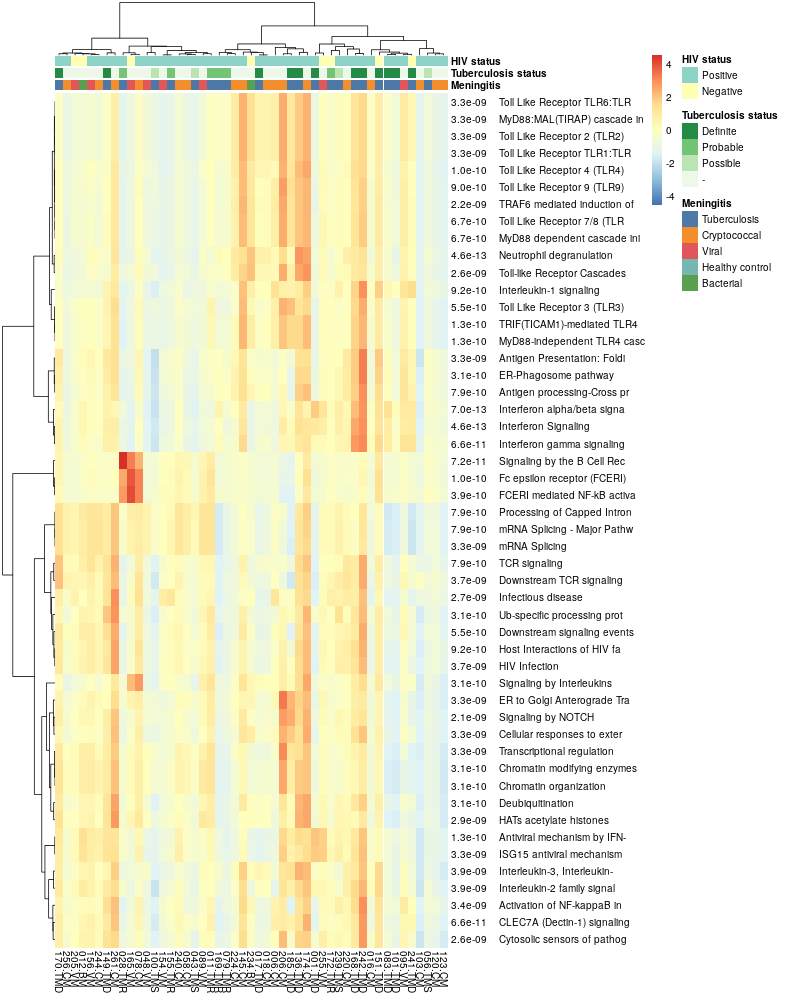

In [194]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_reactome_symbols, 50), tmm_normalized_tb_subsets,
    collection=reactome_new_symbol, id_type='symbol'
)

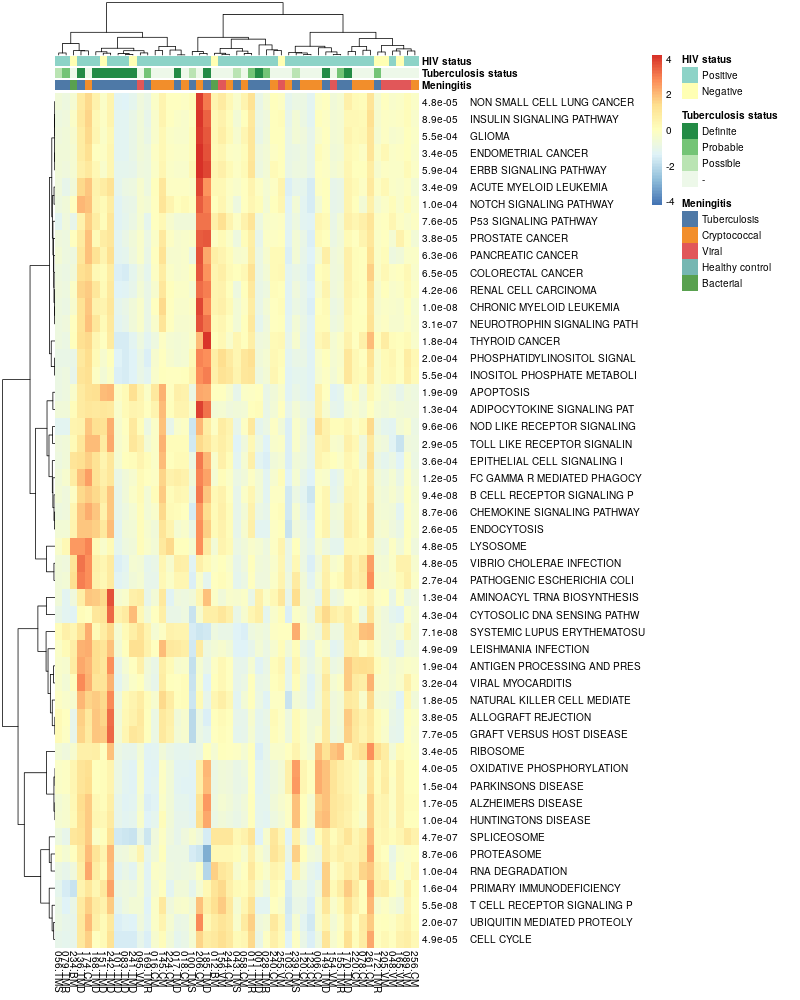

In [195]:
%%R -w 800 -h 1000
gene_set_heatmap(
    head(sets_kegg_entrez, 50), tmm_normalized_tb_subsets,
    collection=c2.cp.kegg, id_type='entrez'
)

It could be tempting to say that KEGG gives the best clustering, but it is wrong:
 - KEGG collection has a small selection of hand-picked pathways; on the plot above I captured more than half (50/94) of significant pathways, but for Reactome I capture only 50/400.
 - we would be testing more hypotheses than needed if we looked at the patients clustering... unless we look at clustering of other groups ;)

Using comparable significance cutoff and k-means sub clustering for Reactome pathways gives us:

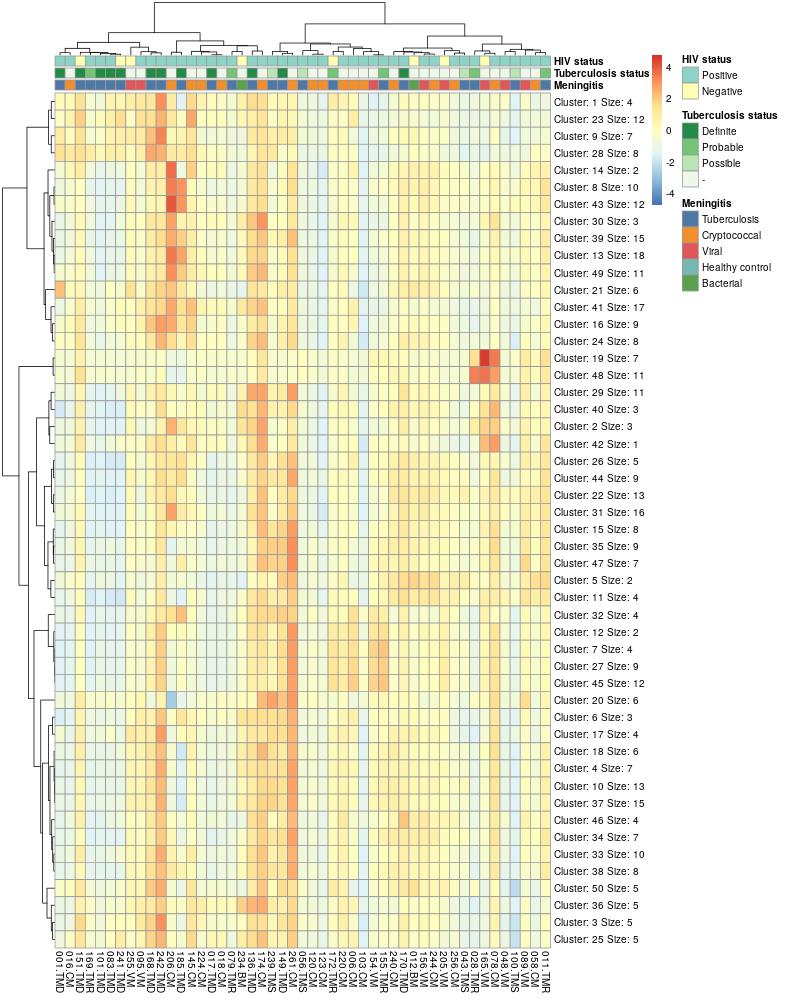

In [196]:
%%R -w 800 -h 1000
gene_set_heatmap(
    sets_reactome_symbols[sets_reactome_symbols$FDR < 1e-04,], tmm_normalized_tb_subsets,
    collection=reactome_new_symbol, id_type='symbol',
    kmeans_k=50, trim=100
)

In [197]:
%%R -w 800 -h 1000
# this is very similar, hidden for brevity
#gene_set_heatmap(
#    sets_reactome_entrez[sets_reactome_entrez$FDR < 1e-04,], tmm_normalized_tb_subsets,
#    collection=c2.cp.reactome, id_type='entrez',
#    kmeans_k=50, trim=100
#)

NULL


### Including topology for pathways analysis

Goals / ideal algorithm:
1. take all significant pathways
2. perform hierarchical clustering
3. choose optimal number of clusters
4. for each cluster:
  - validate that all the pathways have the same direction
  - highlight pathways with the lowest p-value
  - maybe pathways with the highest average expression
  - try to build a pathways hierarchy using the genes information
    E.g. Signaling > Interferon Signaling > **Interferon Gamma Signaling**

In [198]:
%%R
import::here(counts_to_pathways_space, .from='helpers/pathways.R')

pathways_counts = counts_to_pathways_space(tmm_normalized_tb_subsets, collection=c2.cp.reactome, id_type='entrez')

In [199]:
%%R
significant_pathways = sets_reactome_entrez[sets_reactome_entrez$FDR < 0.05,]
significant_counts = pathways_counts[rownames(significant_pathways),]
significant_counts = log2(significant_counts + 0.25)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


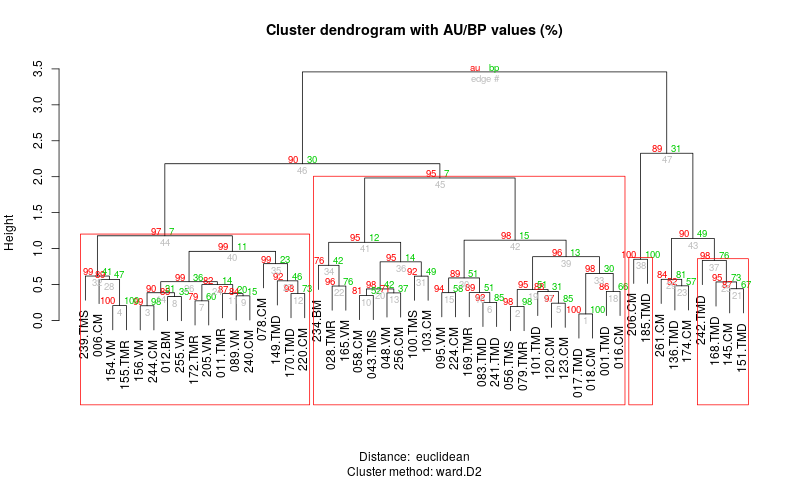

In [200]:
%%R -w 800
set.seed(0)

bootstrapped_clustering <- pvclust::pvclust(
    significant_counts, parallel=T,
    method.hclust="ward.D2", method.dist="euclidean"
)
plot(bootstrapped_clustering)
pvclust::pvrect(bootstrapped_clustering, alpha=0.95)

In [201]:
%%R -w 3000 -h 1200
set.seed(0)
bootstrapped_clustering <- pvclust::pvclust(
    t(significant_counts), parallel=T,
    method.hclust="average", method.dist="correlation",
    nboot=100
)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


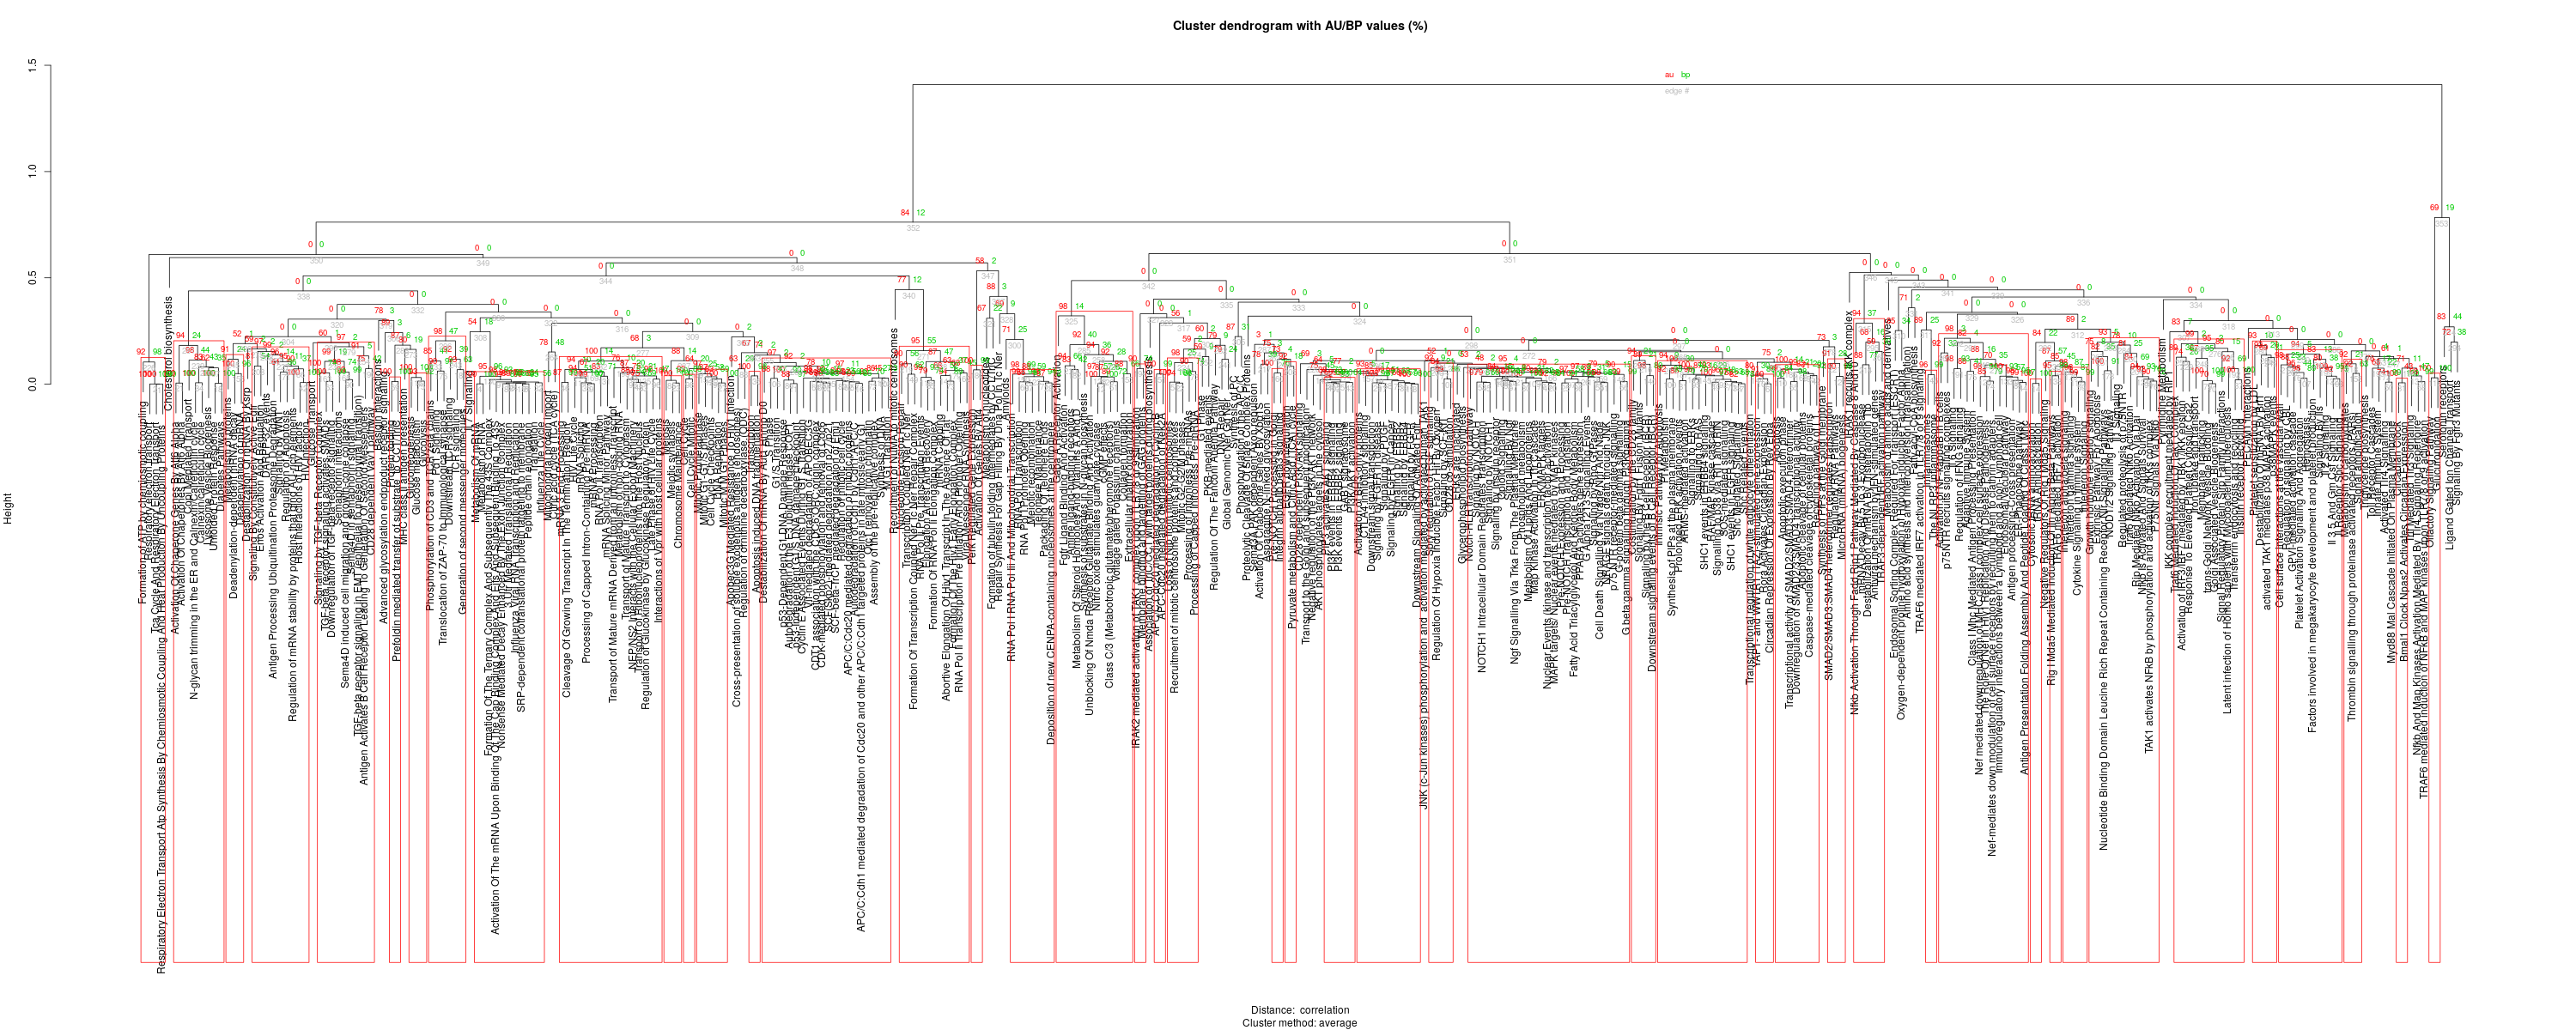

In [202]:
%%R -w 3000 -h 1200
plot(bootstrapped_clustering)
pvclust::pvrect(bootstrapped_clustering, alpha=0.90)

In [203]:
%%R
highly_probable_clusters <- pvclust::pvpick(bootstrapped_clustering, alpha=0.9)

In [204]:
%%R
length(highly_probable_clusters$clusters)

[1] 46


In [205]:
%%R
tb_clusters = Filter(function(pathways) {
    any('Latent infection of Homo sapiens with Mycobacterium tuberculosis' %in% pathways)
}, highly_probable_clusters$clusters)
tb_clusters

[[1]]
 [1] "Membrane Trafficking"                                            
 [2] "trans-Golgi Network Vesicle Budding"                             
 [3] "Signal Regulatory Protein Sirp Family Interactions"              
 [4] "Golgi Associated Vesicle Biogenesis"                             
 [5] "Latent infection of Homo sapiens with Mycobacterium tuberculosis"
 [6] "Activation of IRF3/IRF7 mediated by TBK1/IKK epsilon"            
 [7] "Transferrin endocytosis and recycling"                           
 [8] "Insulin receptor recycling"                                      
 [9] "Traf6 Mediated Induction Of Tak1 Complex"                        
[10] "Iron uptake and transport"                                       
[11] "Response To Elevated Platelet Cytosolic Ca2 "                    



In [206]:
%%R
head(sets_reactome_entrez)

                                                     NGenes Direction
Cytokine Signaling in Immune system                     253        Up
Interferon Signaling                                    146        Up
Signaling By Ils                                        103        Up
Interferon gamma signaling                               58        Up
Signaling by the B Cell Receptor (BCR)                  118        Up
Downstream signaling events of B Cell Receptor (BCR)     90        Up
                                                           PValue          FDR
Cytokine Signaling in Immune system                  5.289373e-17 3.549169e-14
Interferon Signaling                                 6.908348e-15 2.028852e-12
Signaling By Ils                                     9.070874e-15 2.028852e-12
Interferon gamma signaling                           1.612464e-13 2.508075e-11
Signaling by the B Cell Receptor (BCR)               1.868908e-13 2.508075e-11
Downstream signaling events of B Cel

In [207]:
%%R
import::here(names_for_pathway_clusters, collapse_count_clusters, .from='helpers/pathways.R')

cluster_names = names_for_pathway_clusters(highly_probable_clusters$clusters, pathways_data=c2.cp.reactome, pathways_ranking=sets_reactome_entrez)
counts_collapsed = collapse_count_clusters(significant_counts, clusters=highly_probable_clusters$clusters, names=cluster_names)

[1] "Warning: parent node PI3K events in ERBB2 signaling will not be displayed"
[1] "[GAB1 signalosome | PI3K/AKT activation | PI3K events in ERBB4 signaling]"
[2] "PIP3 activates AKT signaling"                                             
[1] "Warning: parent node Signalling By Ngf will not be displayed"                   
[2] "Warning: parent node Map Kinase Activation In Tlr Cascade will not be displayed"
[[1]]
[1] "[Ngf Signalling Via Trka From The Plasma Membrane | MAPK targets/ Nuclear events mediated by MAP kinases]"

[[2]]
[1] "Nuclear Events (kinase and transcription factor activation)"

[[3]]
[1] "ERK/MAPK targets"

[1] "Warning: parent node Signalling By Ngf will not be displayed"
[1] "[Map Kinase Activation In Tlr Cascade | Ngf Signalling Via Trka From The Plasma Membrane]"
[2] "Nuclear Events (kinase and transcription factor activation)"                              
[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node 

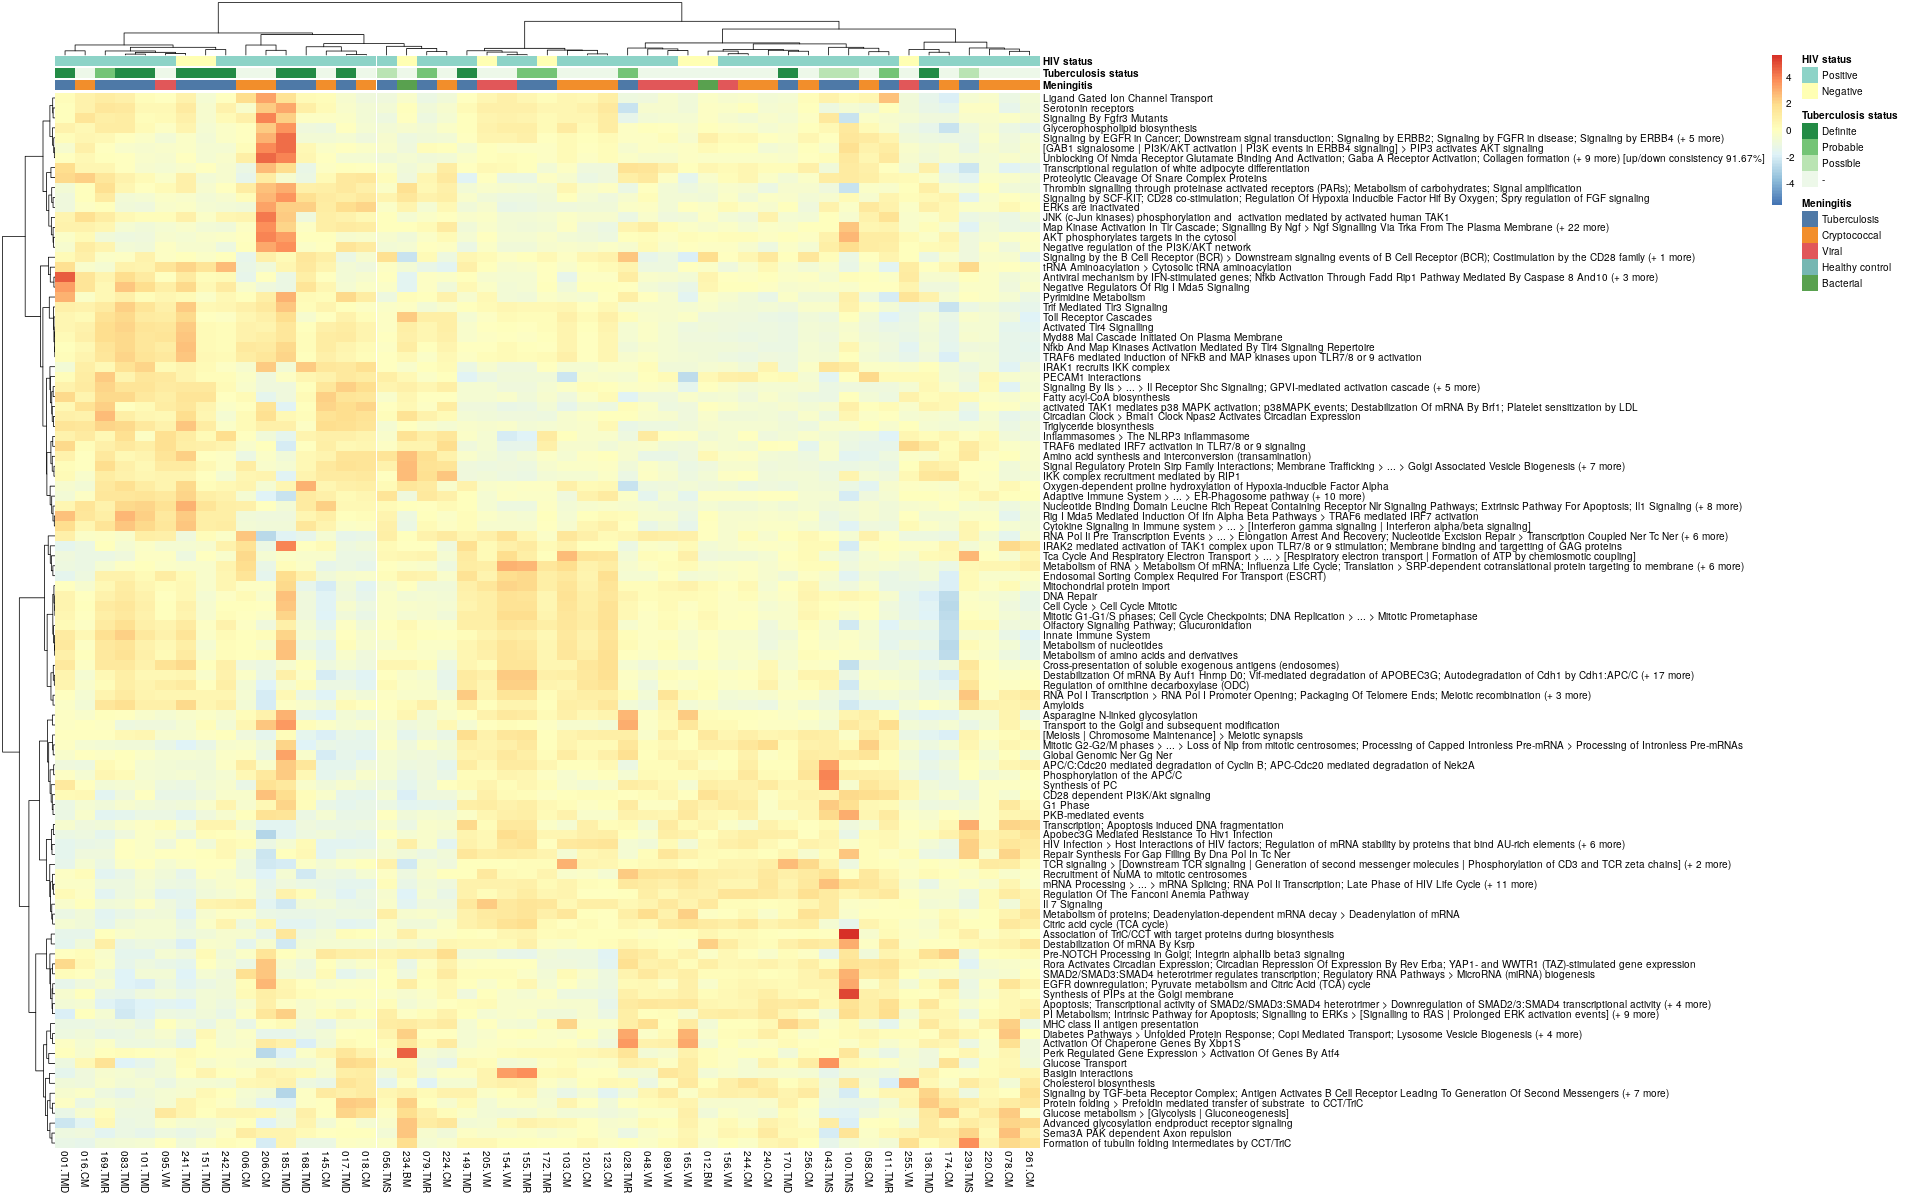

In [208]:
%%R -w 1920 -h 1200
pheatmap(
    scale(counts_collapsed),
    show_colnames=T,
    show_rownames=T,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    cluster_rows=T,
    cluster_cols=T,
    scale='row',
    clustering_distance_rows='correlation'
)

- TODO: place that into the function as debugg/verbose:!!!!!
- TODO: make a heatmap with results for both proteomics and transcriptomics data

### Some heatmaps for DESeq2 and Voom: with & without filtering

In [1969]:
voom_weighted_tmm = definite_tb_cm_limma_cmp_weighted['voom_tmm']
voom_simple_tmm = definite_tb_cm_cmp['voom_tmm']

voom_weighted_rle = definite_tb_cm_limma_cmp_weighted['voom_rle']
voom_simple_rle = definite_tb_cm_cmp['voom_rle']

voom_weighted_eee = definite_tb_cm_limma_cmp_weighted['voom_eee']
voom_simple_eee = definite_tb_cm_cmp['voom_eee']
voom_filtered_eee = definite_tb_cm_limma_cmp_filtered['voom_eee']

In [1810]:
%%R
import::here(ensembl_to_gene_name, .from='helpers/identifiers_mapping.R')

import::here(
    advanced_differential_expression_heatmap, differential_expression_heatmap,
    significant.limma, significant.deseq,
    .from='plots/differential_expression.R'
)
import::here(compose_title, .from='plots/complex_heatmap.R')


de_heatmap = function(counts, dds, main=NULL, major=NULL, minor=NULL, ...) {
    main = compose_title(main, major, minor)
    advanced_differential_expression_heatmap(counts, dds, ..., main=main, id_to_gene_name=ensembl_to_gene_name)
}

simple_de_heatmap = function(...) {
    differential_expression_heatmap(..., id_to_gene_name=ensembl_to_gene_name)
}

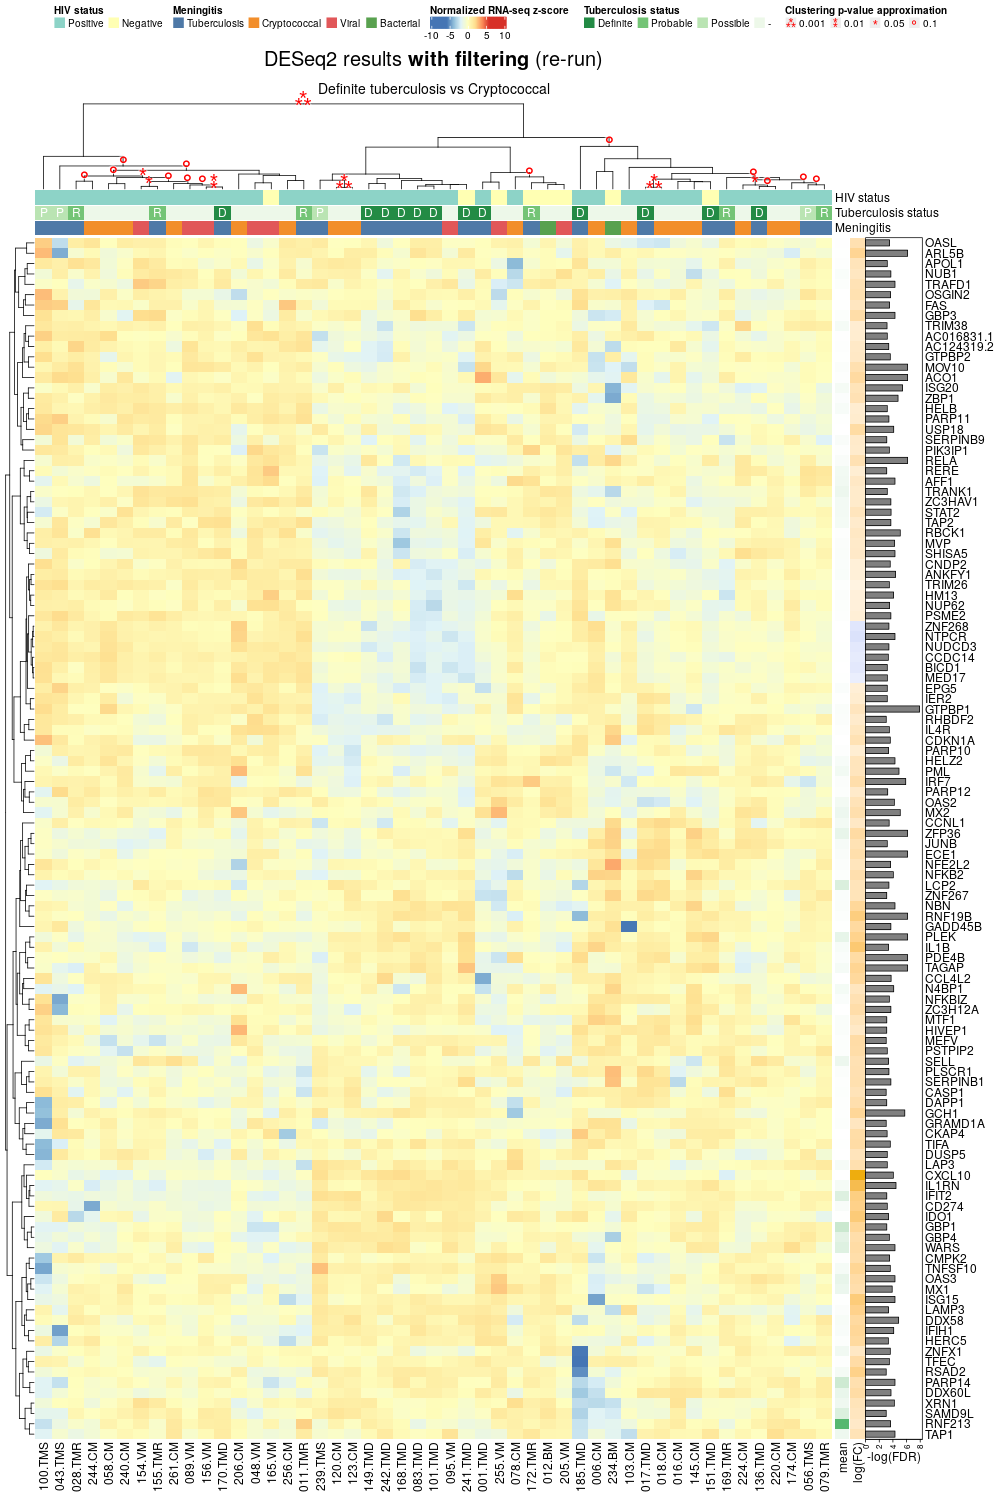

In [1827]:
%%R -w 1000 -h 1500
de_heatmap(
    significant.deseq(deseq2_with_filtering), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{with filtering} (re-run)',
    minor='Definite tuberculosis vs Cryptococcal'
)

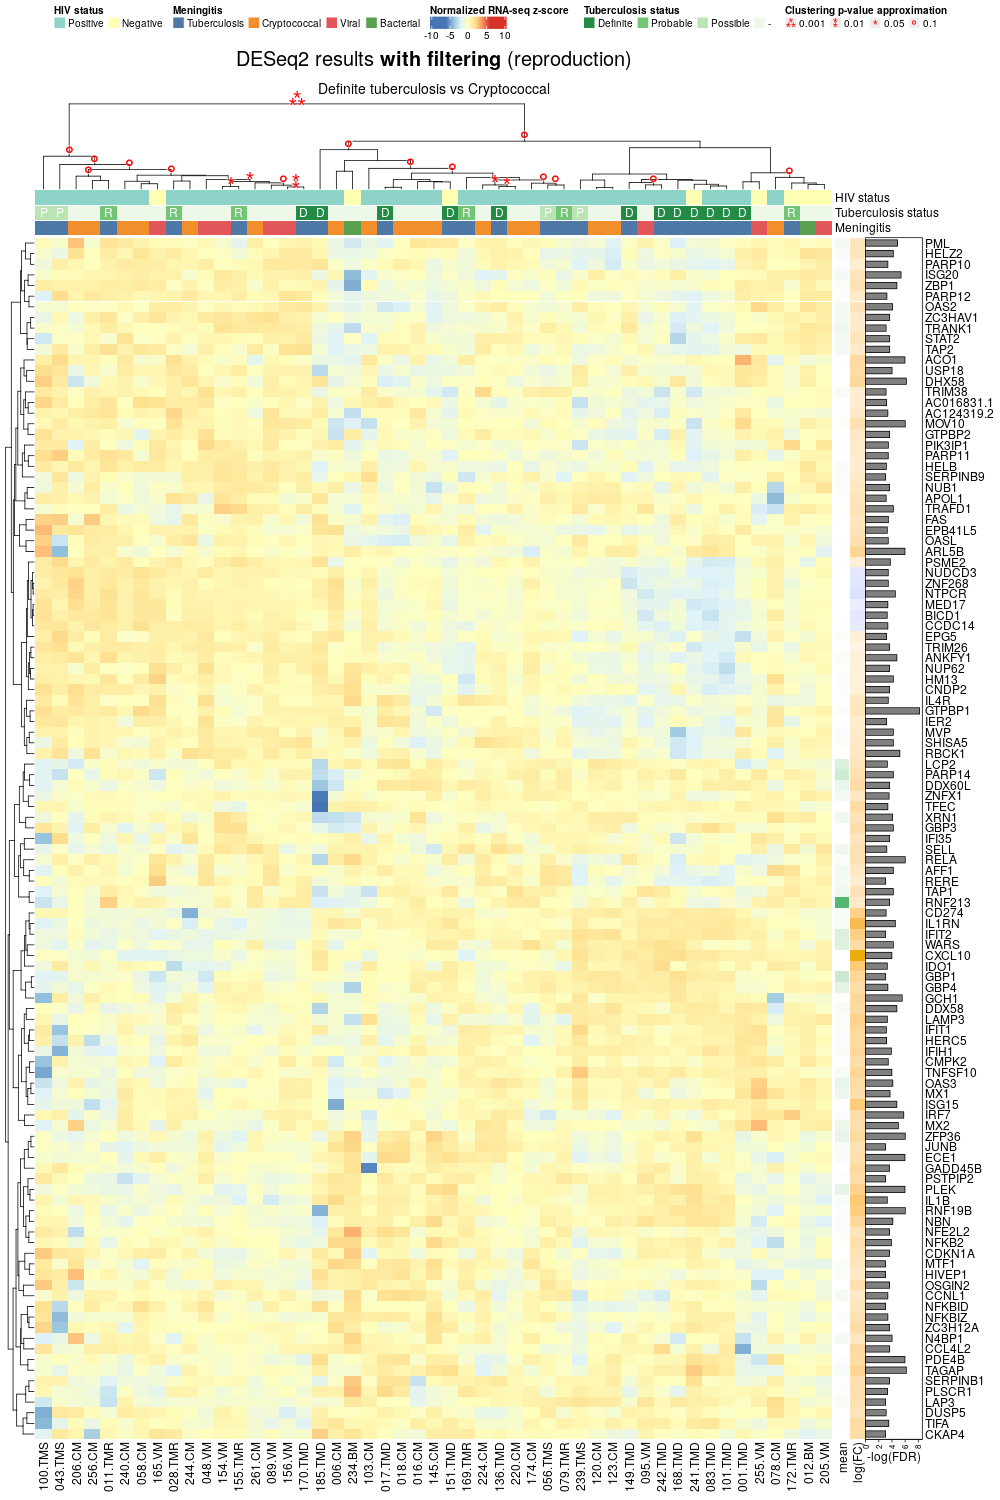

In [1829]:
%%R -w 1000 -h 1500
de_heatmap(
    significant.deseq(deseq2_with_filtering_reproduction), dds_reproduction,
    major='DESeq2 results \\textbf{with filtering} (reproduction)',
    minor='Definite tuberculosis vs Cryptococcal'
)

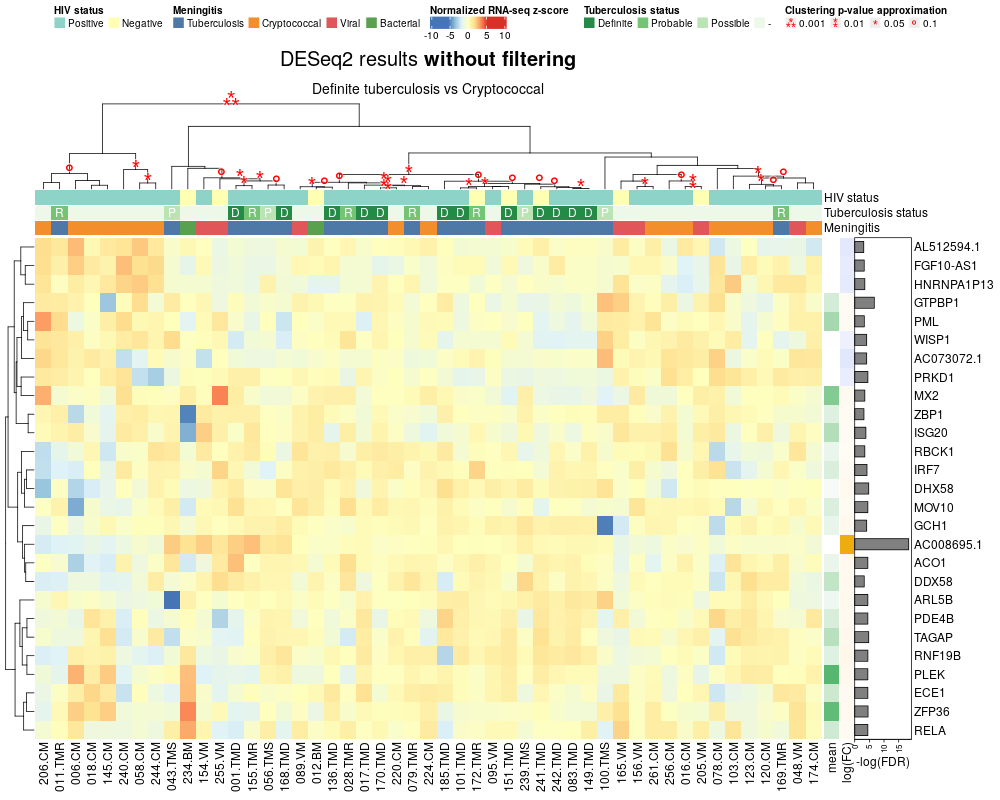

In [1831]:
%%R -w 1000 -h 800
de_heatmap(
    significant.deseq(deseq2_without_filtering), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{without filtering}',
    minor='Definite tuberculosis vs Cryptococcal'
)

AC008695.1 has a very consistent signal (very high logFC).

It is uncharacterized, but similar to RAPGEF6, which may play a role in cell-cell junctions formation:
https://www.sciencedirect.com/science/article/pii/S0898656808001459, Also something about Rap1 isoforms signaling.

How does it compare to voom results?

In [1869]:
with_gene_data(voom_simple_rle).query("gene_name in ['RAPGEF6', 'AC008695.1']")

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000158987 -0.119254  7.123293 -0.800150  0.426852   0.913804 -5.916807   
ENSG00000273217  0.555357 -1.560686  0.483387  0.630851   0.950252 -4.950990   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

In [1855]:
with_gene_data(voom_simple_tmm).query("gene_name in ['RAPGEF6', 'AC008695.1']")

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000158987  0.231149  7.123293  0.846757  0.400265   0.776569 -5.755939   
ENSG00000273217  0.827811 -1.560686  0.746082  0.459374   0.807697 -5.164359   

                  gene_name         biotype contig strand  
ENSG00000158987     RAPGEF6  protein_coding      5      -  
ENSG00000273217  AC008695.1  protein_coding      5      -

In [1859]:
with_gene_data(deseq2_without_filtering, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ENSG00000158987  466.048853       -0.080817  0.177202 -0.456071  6.483391e-01   
ENSG00000273217   14.612156       23.771445  3.261043  7.289521  3.110580e-13   

                         padj   gene_name         biotype contig strand  
ENSG00000158987  9.999882e-01     RAPGEF6  protein_coding      5      -  
ENSG00000273217  9.956968e-09  AC008695.1  protein_coding      5      -

In [1863]:
%R -o shrunk_normal_lfc

In [1867]:
with_gene_data(shrunk_normal_lfc, sort=F).query("gene_name in ['RAPGEF6', 'AC008695.1']")

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ENSG00000158987  466.048853       -0.079513  0.174894 -0.456071  6.483391e-01   
ENSG00000273217   14.612156        0.553051  0.612266  7.289521  3.110580e-13   

                     padj   gene_name         biotype contig strand  
ENSG00000158987  0.943448     RAPGEF6  protein_coding      5      -  
ENSG00000273217       NaN  AC008695.1  protein_coding      5      -

Here we go, after shrinkage it' does look so great (NaN in padj is unrelated, the variable was just reused from filtered dds).

Interestingly, the shrunken log-fold changes are now comparable between voom and deseq.

[1] "Too few observations to assess the clustering p-values"


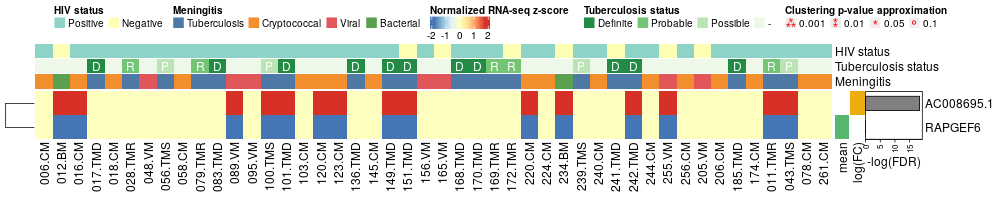

In [1965]:
%%R -w 1000 -h 200
de_heatmap(
    deseq2_without_filtering[c('ENSG00000158987', 'ENSG00000273217'),], dds_edger_prefiltered,
    skip_cols=c('175.TMD', '074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '233.CM', '001.TMD', '155.TMR', '154.VM')
)

Maybe there is something with the transcript mapping?

In [1930]:
%%R -o dds_counts
dds_counts = as.data.frame(counts(dds_edger_prefiltered, normalized=T))

In [1910]:
show_table(
    raw_counts_matrix.loc[['ENSG00000158987', 'ENSG00000273217']].T
    .query("ENSG00000158987 != 0 or ENSG00000273217 != 0")
)

ENSG00000158987  ENSG00000273217
001.TMD  21.33            21.67          
006.CM   169.00           0.00           
012.BM   795.00           0.00           
016.CM   213.00           0.00           
017.TMD  620.00           0.00           
018.CM   396.00           0.00           
028.TMR  576.00           0.00           
048.VM   2508.00          0.00           
056.TMS  1096.02          25.22          
058.CM   168.00           0.00           
079.TMR  966.00           0.00           
083.TMD  642.00           0.00           
089.VM   869.00           0.00           
093.TMD  217.00           0.00           
095.VM   826.00           0.00           
100.TMS  21.00            0.00           
101.TMD  778.00           0.00           
103.CM   586.00           0.00           
120.CM   583.00           0.00           
123.CM   838.00           0.00           
136.TMD  259.00           0.00           
145.CM   132.00           0.00           
149.TMD  411.00           0.00           
151.TMD  528.00           0.00           
154.VM   478.26           80.74          
155.TMR  1257.86          331.14         
156.VM   9973.00          0.00           
165.VM   444.00           0.00           
168.TMD  162.88           12.43          
170.TMD  690.00           0.00           
169.TMR  237.00           0.00           
172.TMR  1814.00          0.00           
220.CM   1357.00          0.00           
224.CM   576.00           0.00           
234.BM   590.19           58.13          
239.TMS  872.37           14.71          
240.CM   530.00           0.00           
241.TMD  409.00           0.00           
242.TMD  843.00           0.00           
244.CM   629.00           0.00           
255.VM   313.38           51.62          
256.CM   675.00           0.00           
205.VM   843.00           0.00           
206.CM   52.00            0.00           
185.TMD  66.00            0.00           
174.CM   375.00           0.00           
011.TMR  166.00           0.00           
043.TMS  422.01           42.99          
078.CM   961.00           0.00           
261.CM   712.00           0.00

So we got a case of log fold change for a pair where one group has sum of counts = 0

In [1936]:
dds_counts.loc['ENSG00000273217', dds_counts.index.str.endswith('CM')].sum()

0.0

Apparently, DESeq does not handle such cases explicitly if one group in contrast has zeros only. See: https://support.bioconductor.org/p/111231/

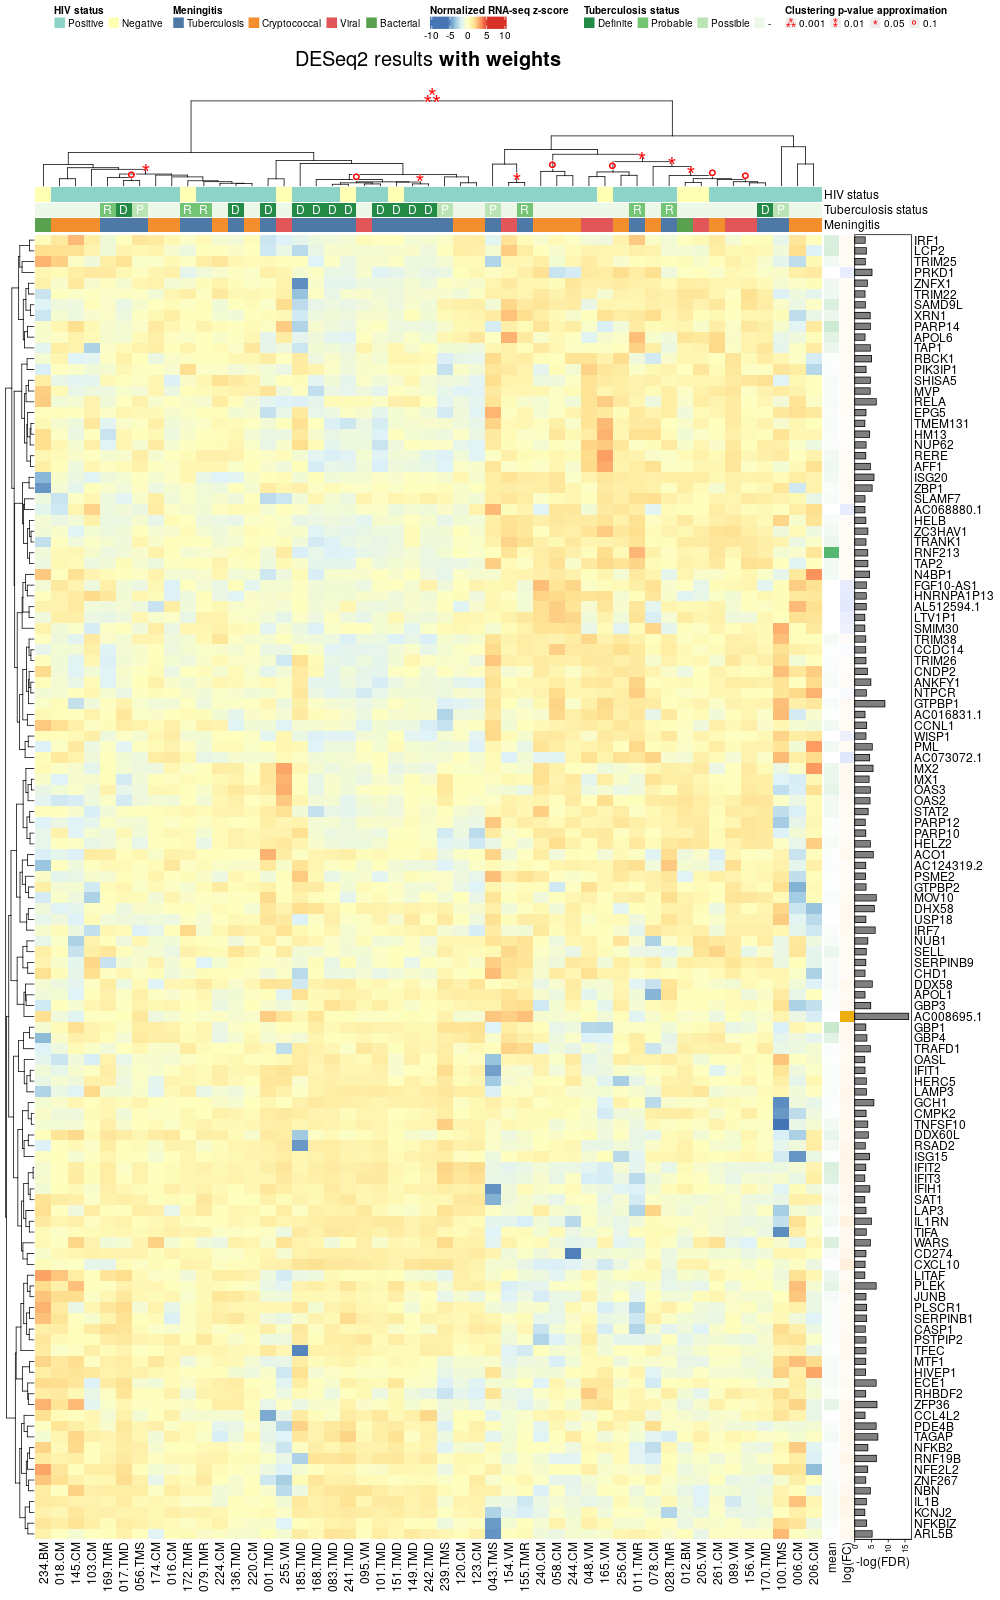

In [1940]:
%%R -w 1000 -h 1600
de_heatmap(
    significant.deseq(deseq2_with_weighting), dds_edger_prefiltered,
    major='DESeq2 results \\textbf{with weights}}',
    minor='Definite tuberculosis vs Cryptococcal'
)

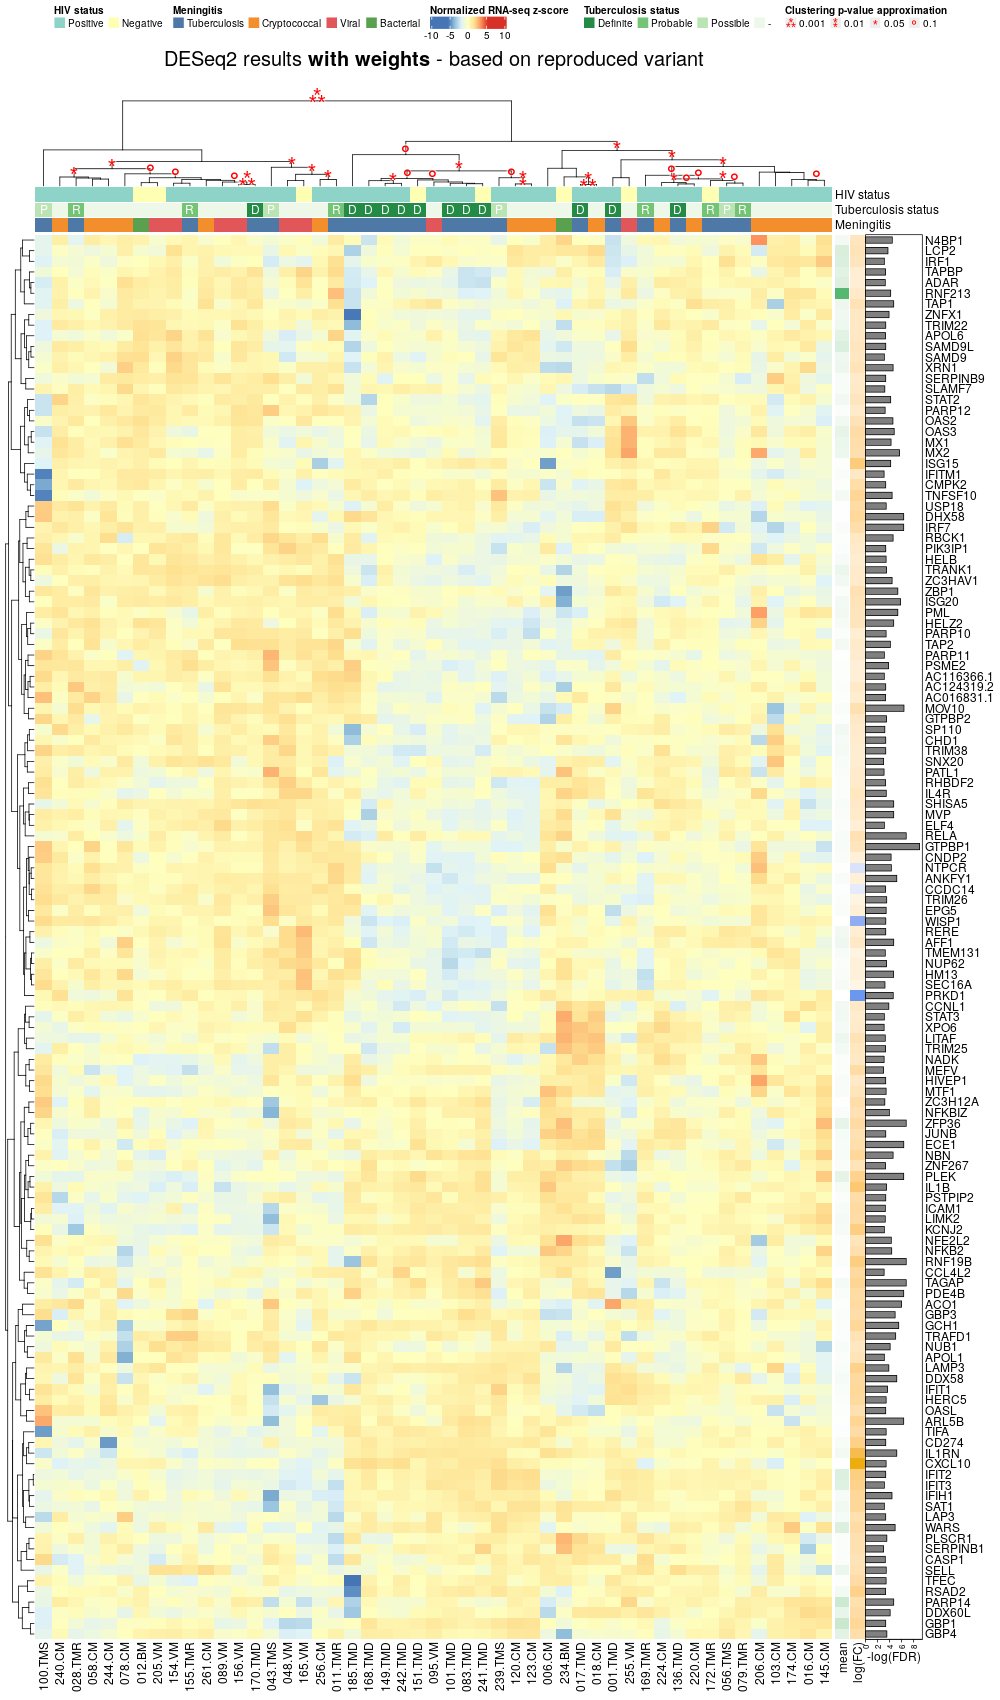

In [1961]:
%%R -w 1000 -h 1700
de_heatmap(
    significant.deseq(deseq2_with_weighting_reproduction), dds_reproduction,
    major='DESeq2 results \\textbf{with weights} - based on reproduced variant}',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [1958]:
with_gene_data(voom_simple_tmm).query("gene_name in ['WISP1', 'AC012363.1', 'RNF213']")

logFC    AveExpr         t       P.Value  adj.P.Val  \
ENSG00000224789  3.561383  -1.218302  6.021654  9.125444e-08   0.001575   
ENSG00000173821  1.142558  11.728214  3.682157  4.750803e-04   0.161419   
ENSG00000104415 -1.760435   1.713906 -3.645468  5.348101e-04   0.162976   

                        B   gene_name         biotype contig strand  
ENSG00000224789  5.470512  AC012363.1       antisense      2      -  
ENSG00000173821 -0.244006      RNF213  protein_coding     17      +  
ENSG00000104415 -0.366549       WISP1  protein_coding      8      +

Individual genes do not agree between methods too much, and if they do I doubt because those are lowly expressed. The heatmap looks nice, but could I get such a nice heatmap from random data?

[1] "Too few observations to assess the clustering p-values"


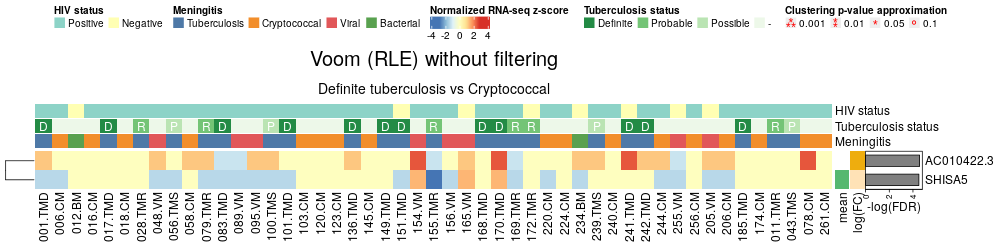

In [467]:
%%R -w 1000 -h 250 -i voom_simple_rle

de_heatmap(
    significant.limma(voom_simple_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) without filtering',
    minor='Definite tuberculosis vs Cryptococcal'
)

Side note: in the previous iteration, a simpler version of the heatmap was used, and it can be accessed with simple_de_heatmap():

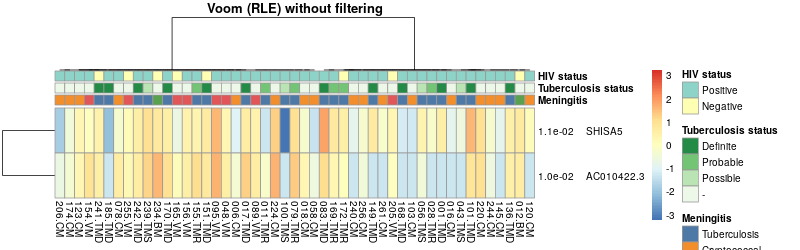

In [453]:
%%R -w 800 -h 250
simple_de_heatmap(
    significant.limma(voom_simple_rle), tmm_normalized_tb_subsets,
    main='Voom (RLE) without filtering'
)

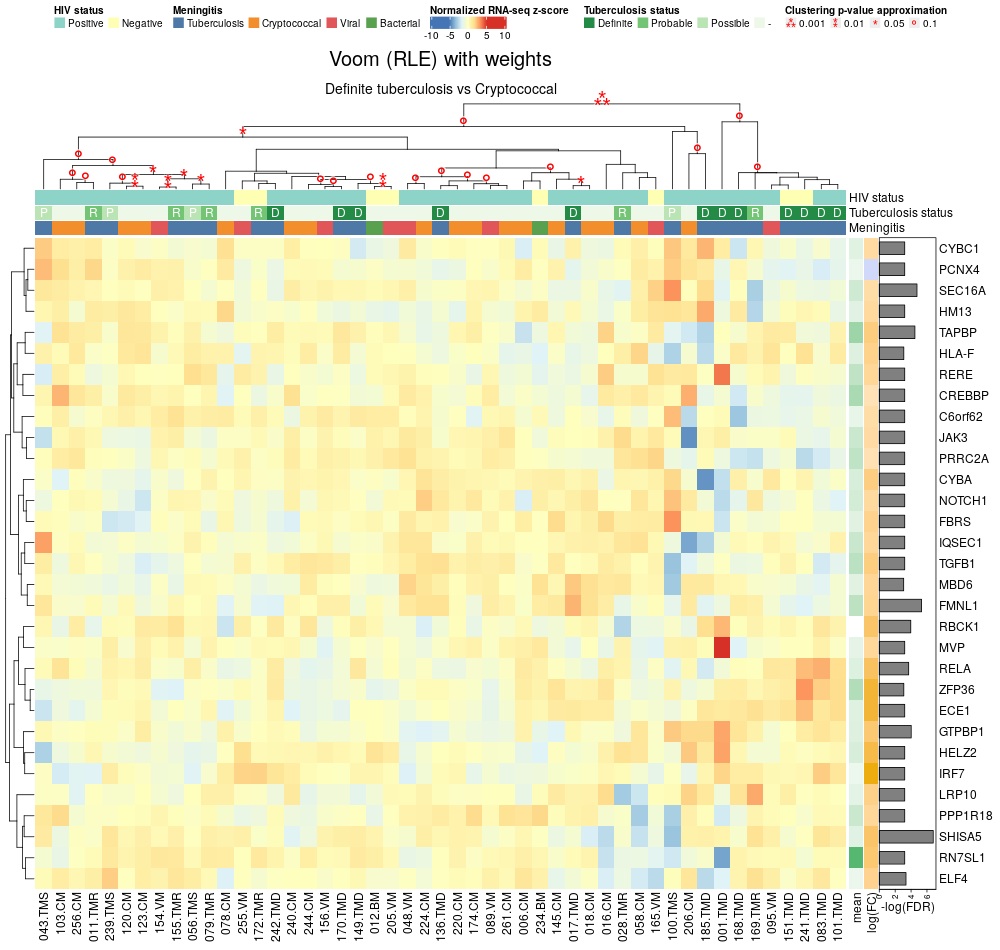

In [469]:
%%R -w 1000 -h 950 -i voom_weighted_rle

de_heatmap(
    significant.limma(voom_weighted_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

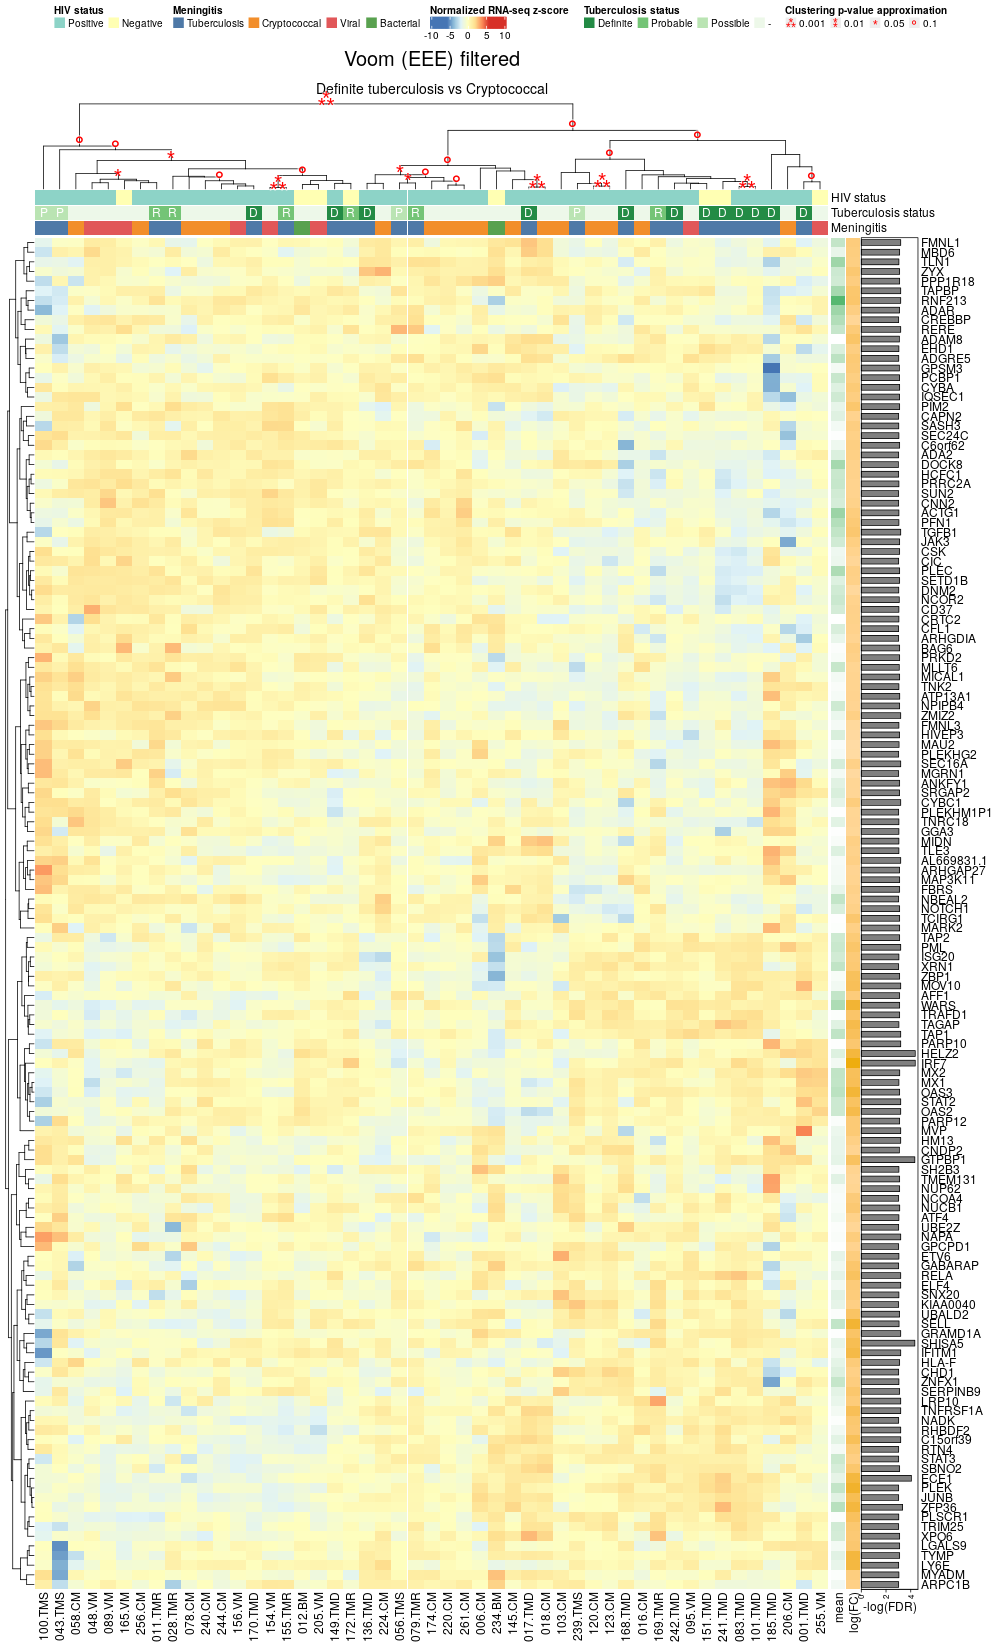

In [481]:
%%R -w 1000 -h 1650 -i voom_filtered_eee

de_heatmap(
    significant.limma(voom_filtered_eee), eee_normalized_tb_subsets,
    major='Voom (EEE) filtered',
    minor='Definite tuberculosis vs Cryptococcal'
)

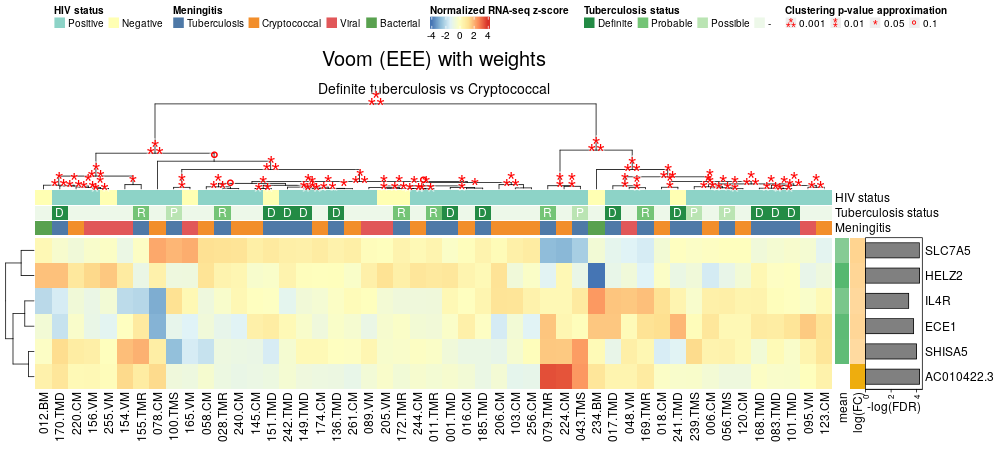

In [473]:
%%R -w 1000 -h 450 -i voom_weighted_eee

de_heatmap(
    significant.limma(voom_weighted_eee), eee_normalized_tb_subsets,
    major='Voom (EEE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

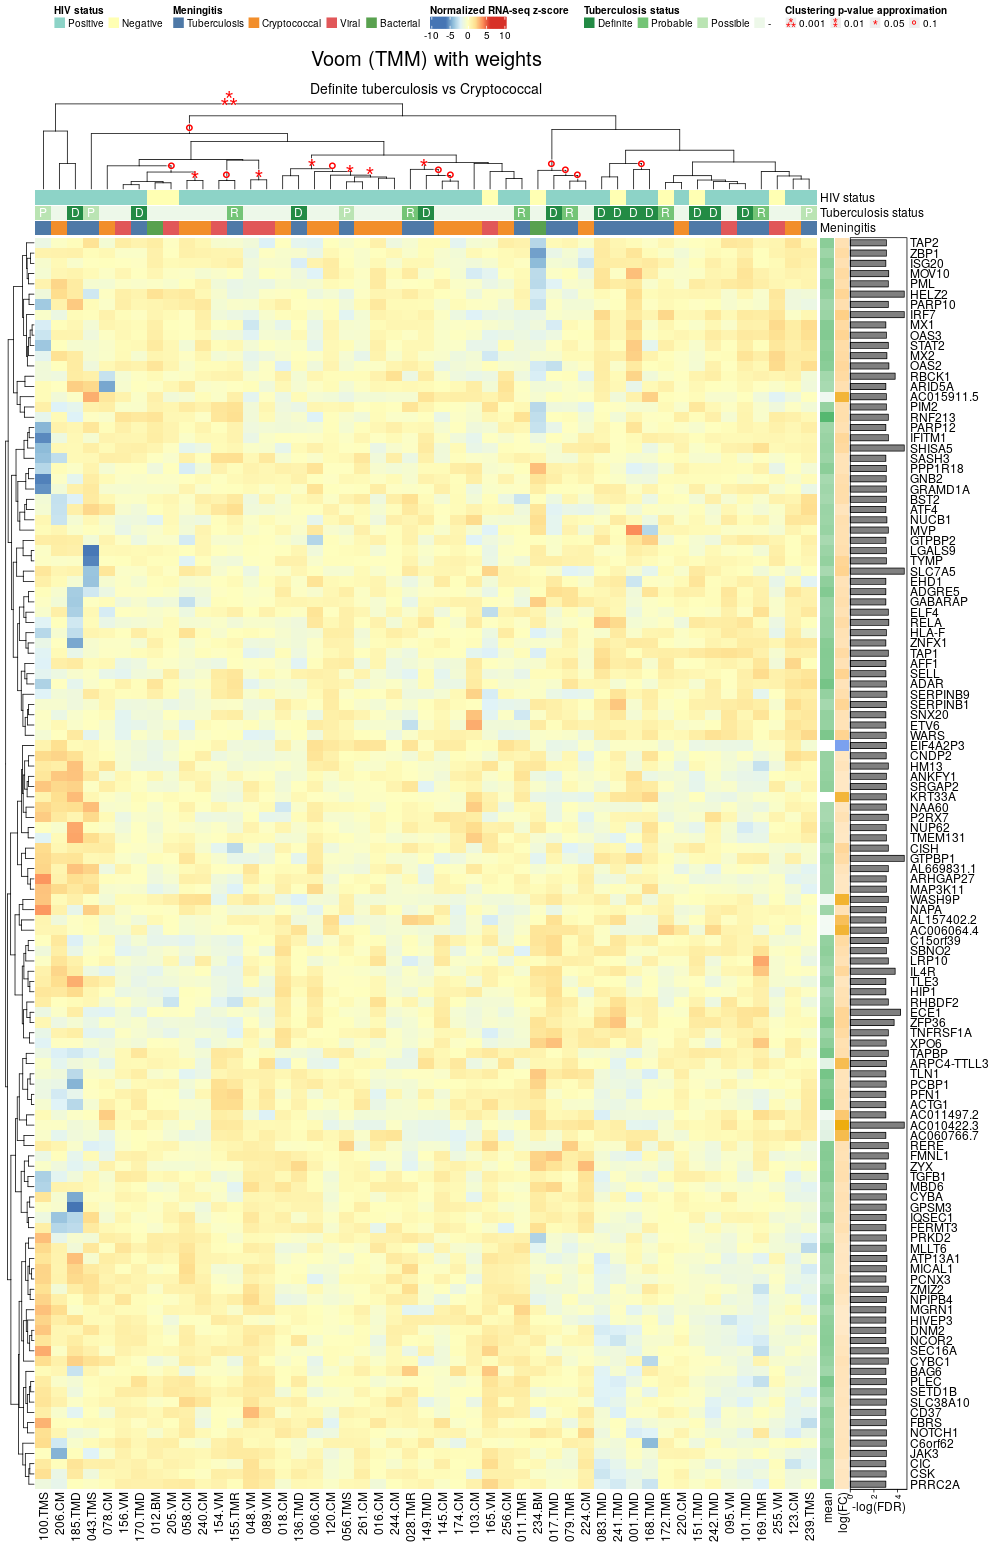

In [463]:
%%R -w 1000 -h 1550 -i voom_weighted_tmm

de_heatmap(
    significant.limma(voom_weighted_tmm), tmm_normalized_tb_subsets,
    major='Voom (TMM) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

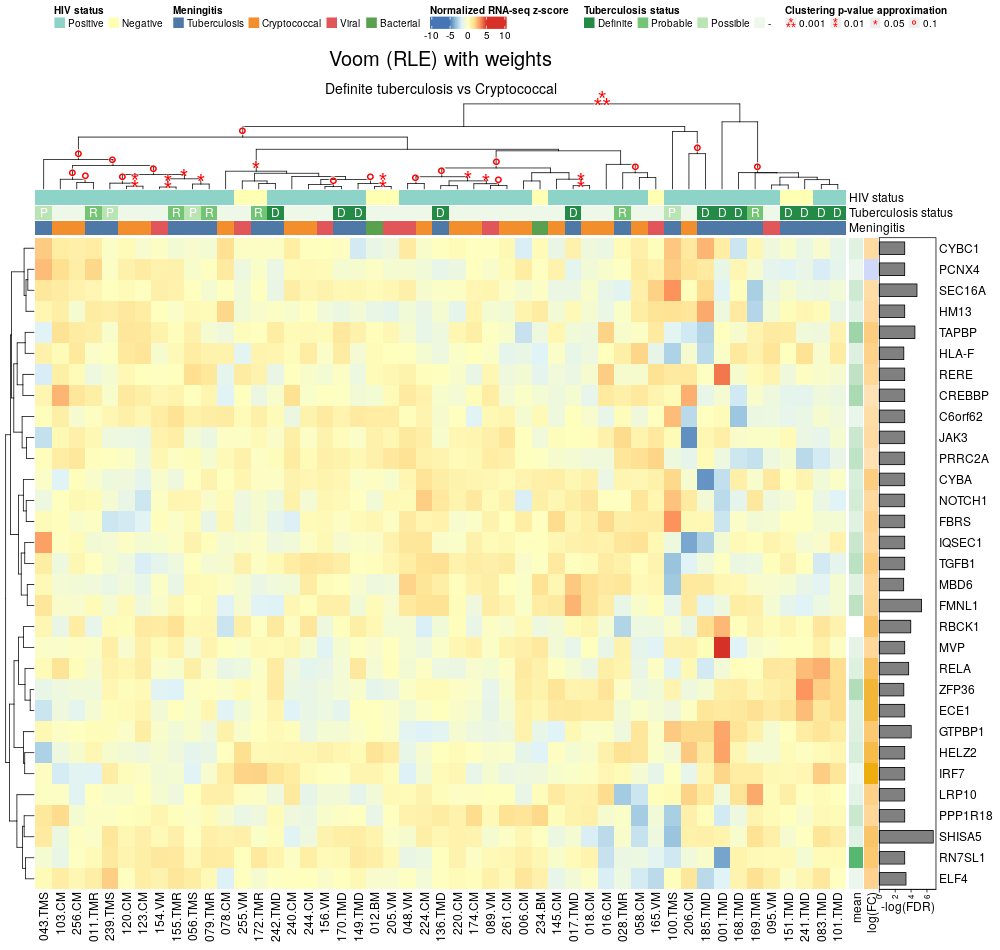

In [1973]:
%%R -w 1000 -h 950 -i voom_weighted_rle

de_heatmap(
    significant.limma(voom_weighted_rle), rle_normalized_tb_subsets,
    major='Voom (RLE) with weights',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [1975]:
provided = reference_definite_tbm_cm_deg.set_index('ensembl_id')

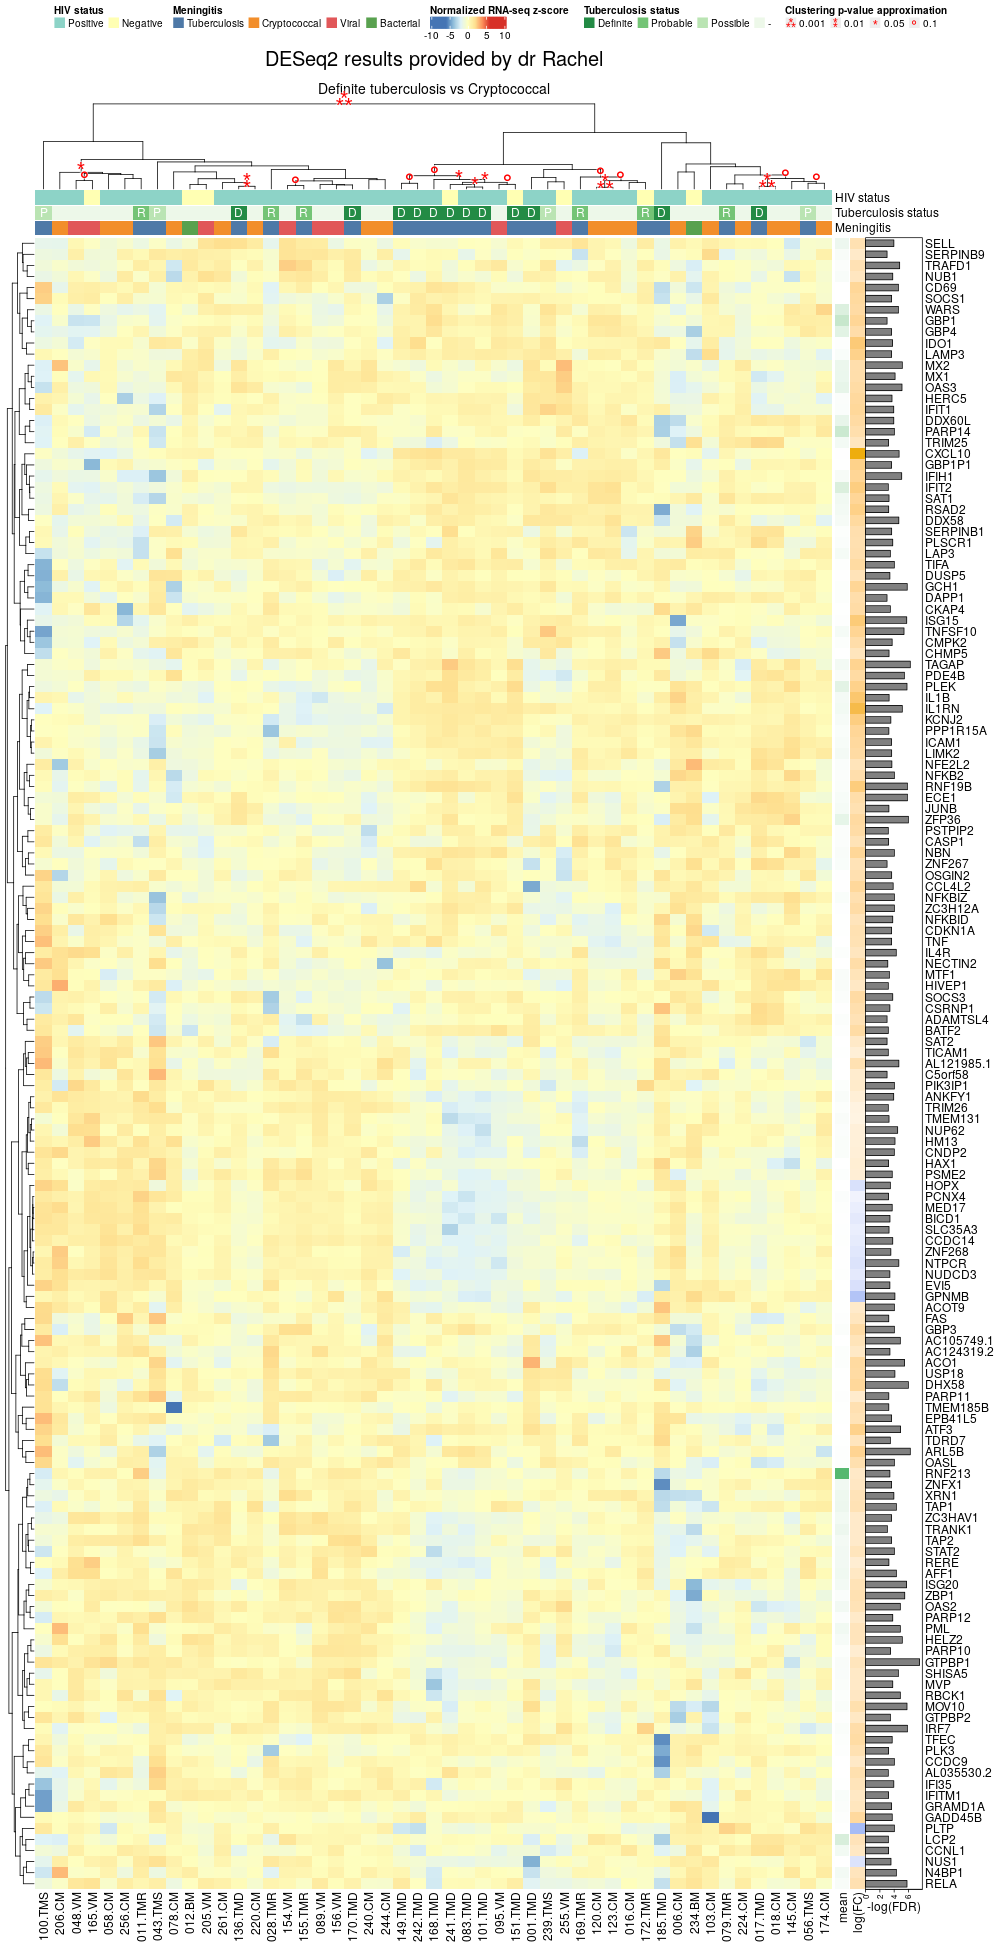

In [1977]:
%%R -w 1000 -h 1950 -i provided
de_heatmap(
    significant.deseq(provided), dds_reproduction,
    major='DESeq2 results provided by dr Rachel',
    minor='Definite tuberculosis vs Cryptococcal'
)

# Final results

I will generate three result sets:
 - voom-TMM
 - DESeq2
 - intersection of voom-TMM and DESeq2

If the number of significant DE genes without independent filtering for voom-TMM will remain as low for other contrasts, I will analyse these by hand as well.

Adding voom-RLE does not seem warranted as the example above shows that it provides little additional results different from voom-TMM; also, the results are expected to be similar to voom-TMM or DESeq2 because it shares large similarities with both of them.

If - as argued by some - the intersection can be restated as a certain percentage of top results of voom-TMM and DESeq2, it would not be a very useful thing to do. But it is not such simple (see paired plot above).

## With TB confidence subsets (definite/probable/possible)

In [221]:
voom_path = Path(results_path) / 'voom_tmm'
voom_path.mkdir(exist_ok=True, parents=True)

In [222]:
%%R
import::here(collapse_ranking_clusters, .from='helpers/pathways.R')

some_greek_letters = data.frame(
    full=c('alpha', 'beta', 'gamma', 'epsilon'),
    abbreviation=c('\U03B1', '\U03B2', '\U03B3', '\U03B5')
)

collapse_by_clusters_and_topology = function(
    counts, pathways, collection, id_type,
    cluster_p_threshold=0.95,
    counts_transform=log2, damping_factor=0.25,
    nboot=1000, character_limit=100
) {
    pathways_counts = counts_to_pathways_space(counts, collection=collection, id_type=id_type)
    significant_counts = pathways_counts[rownames(pathways),]
    significant_counts = counts_transform(significant_counts + damping_factor)

    bootstrapped_clustering <- pvclust::pvclust(
        t(significant_counts), parallel=T,
        method.hclust="ward.D2", method.dist="correlation",
        nboot=nboot, quiet=T
    )
    highly_probable_clusters <- pvclust::pvpick(bootstrapped_clustering, alpha=cluster_p_threshold)

    cluster_names = names_for_pathway_clusters(
        highly_probable_clusters$clusters, pathways_data=collection, pathways_ranking=pathways,
        abbreviations=some_greek_letters, character_limit=character_limit
    )
    counts_collapsed = collapse_count_clusters(significant_counts, clusters=highly_probable_clusters$clusters, names=cluster_names)

    print(paste(
        'Chosen', length(highly_probable_clusters$clusters),
        'highly probable (p >= ', cluster_p_threshold, ') clusters'
    ))
    
    ranking_collapsed = collapse_ranking_clusters(
        get_significant_pathways(pathways),
        clusters=highly_probable_clusters$clusters,
        names=cluster_names,
        collapse=function(cluster) apply(cluster, 2, min)
    )
    
    list(counts=counts_collapsed, ranking=ranking_collapsed)
}

get_significant_pathways = function(pathways, fdr_threshold=0.05) {
    pathways[pathways$FDR < fdr_threshold,]
}

simple_pheatmap = function(counts_collapsed) {
    pheatmap(
        scale(counts_collapsed),
        show_colnames=T,
        show_rownames=T,
        annotation_col=counts_patient_annotations,
        #annotation_row=annotation_row,
        annotation_colors=patient_colors,
        clustering_method='ward.D2',
        clustering_distance_cols='correlation',
        cluster_rows=T,
        cluster_cols=T,
        scale='row',
        clustering_distance_rows='correlation'
    )
}

In [223]:
%%R
collapsed_voom_reactome_entrez = collapse_by_clusters_and_topology(
    tmm_normalized_tb_subsets, get_significant_pathways(sets_reactome_entrez, 0.01),
    collection=c2.cp.reactome, id_type='entrez',
    # note low bootstrap count and low fdr cutoff (for demonstration purposes)
    nboot=500, character_limit=100
)

[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node Signalling to RAS will not be displayed"              
[3] "Warning: parent node Prolonged ERK activation events will not be displayed"
[1] "[ARMS-mediated activation | SHC1 events in EGFR signaling | SOS-mediated signalling | Shc Mediated Signalling]"
[2] "RAF/MAP kinase cascade"                                                                                        
[1] "Warning: parent node Signalling to ERKs will not be displayed"             
[2] "Warning: parent node Prolonged ERK activation events will not be displayed"
[1] "[Signalling to RAS | ARMS-mediated activation | SHC1 events in EGFR signaling | SOS-mediated signalling]"
[2] "RAF/MAP kinase cascade"                                                                                  
[1] "Cluster not fully consistent; consistent until 4 position in the FDR-based ranking (40%); consistency = 70%"
[1] "Top 3 pathways in th

In [224]:
%%R
import::here(names_for_pathway_clusters, collapse_count_clusters, .from='helpers/pathways.R')

#cluster_names = names_for_pathway_clusters(highly_probable_clusters$clusters, pathways_data=reactome_new_symbol, pathways_ranking=sets_reactome_symbols)
#counts_collapsed = collapse_count_clusters(significant_counts, clusters=highly_probable_clusters$clusters, names=cluster_names)

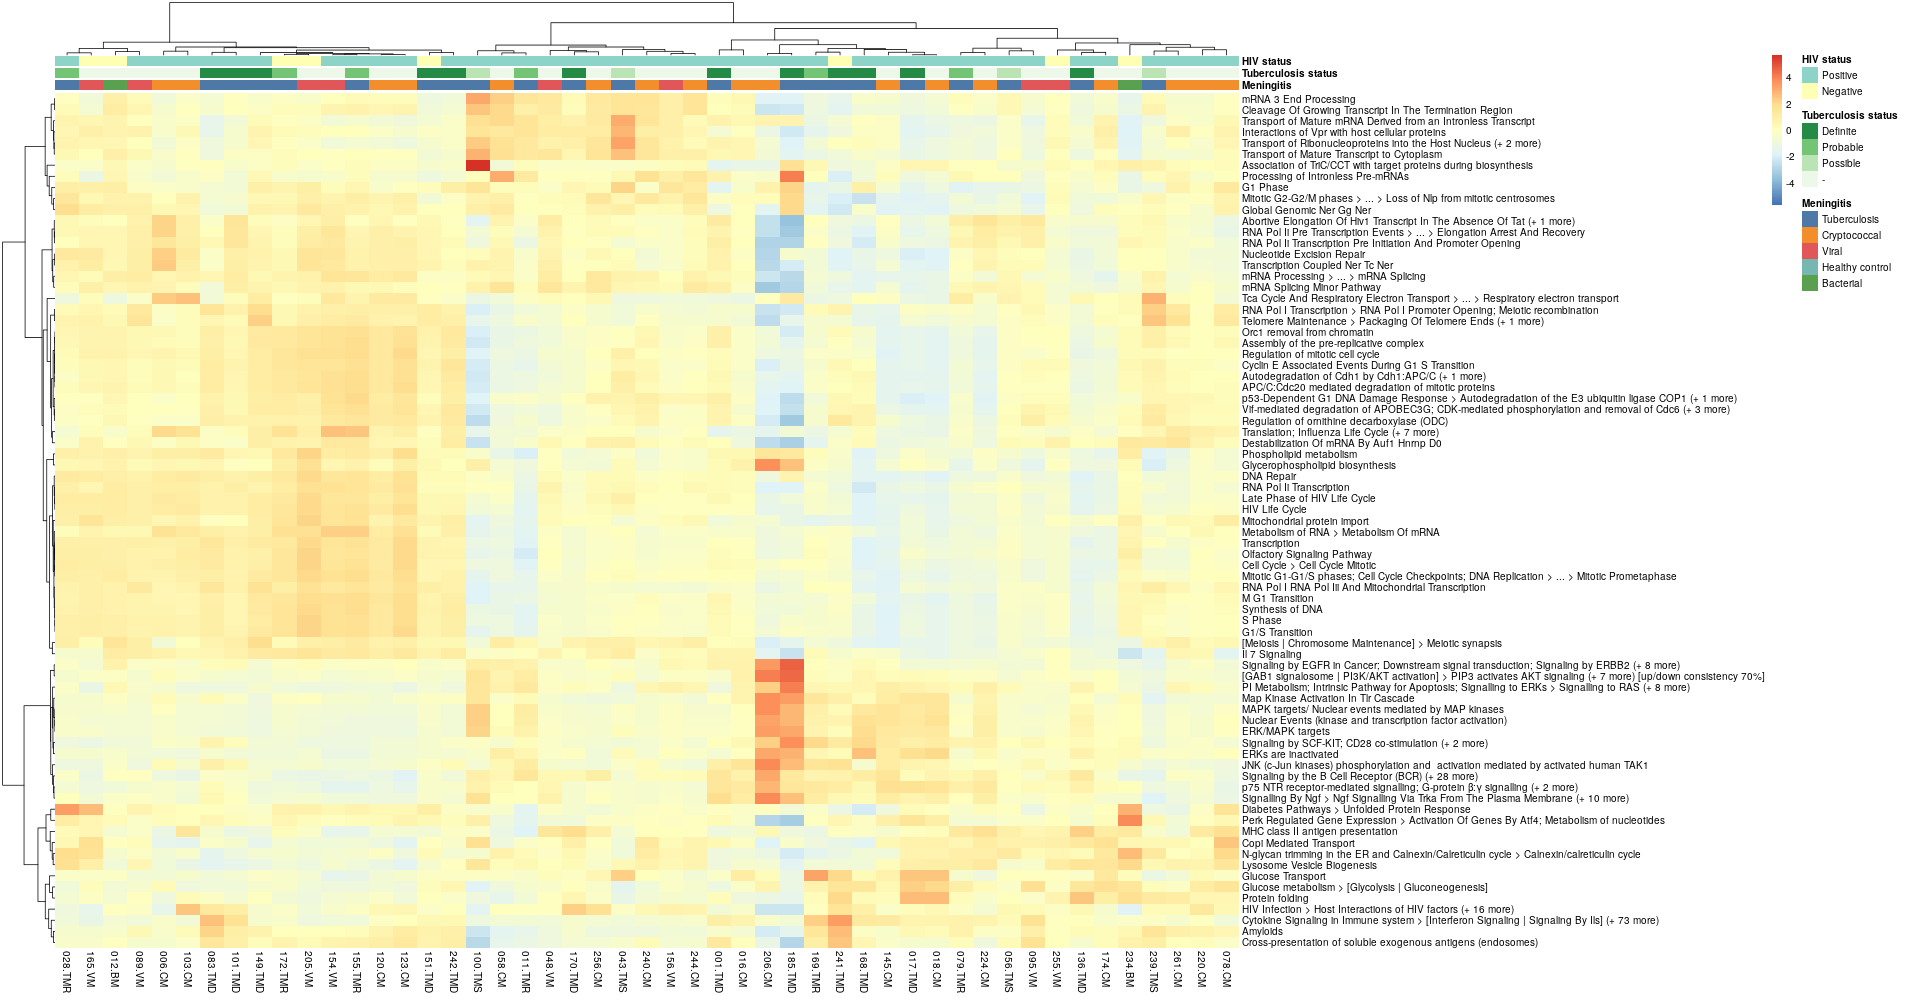

In [225]:
%%R -w 1920 -h 1000
simple_pheatmap(collapsed_voom_reactome_entrez$counts)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


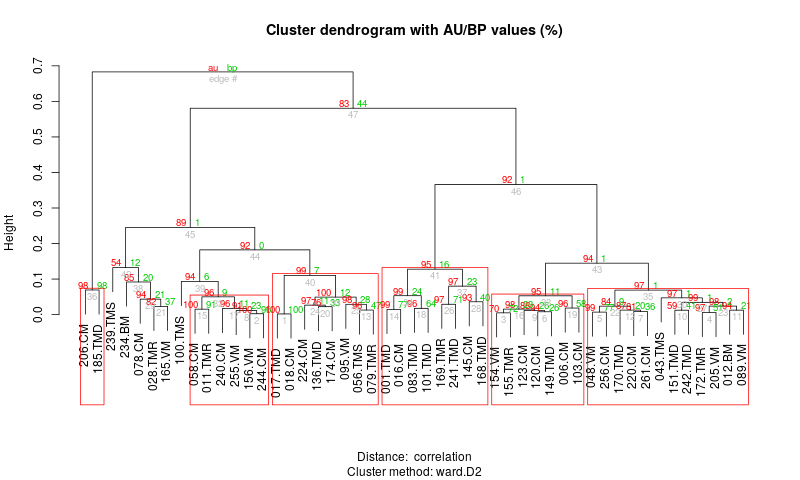

In [226]:
%%R -w 800
collapsed_patients_clustering <- pvclust::pvclust(
    scale(collapsed_voom_reactome_entrez$counts), parallel=T,
    method.hclust="ward.D2", method.dist="correlation"
)
plot(collapsed_patients_clustering)
pvclust::pvrect(collapsed_patients_clustering, alpha=0.95)

Creating a temporary cluster...done:
socket cluster with 7 nodes on host ‘localhost’
Multiscale bootstrap... Done.


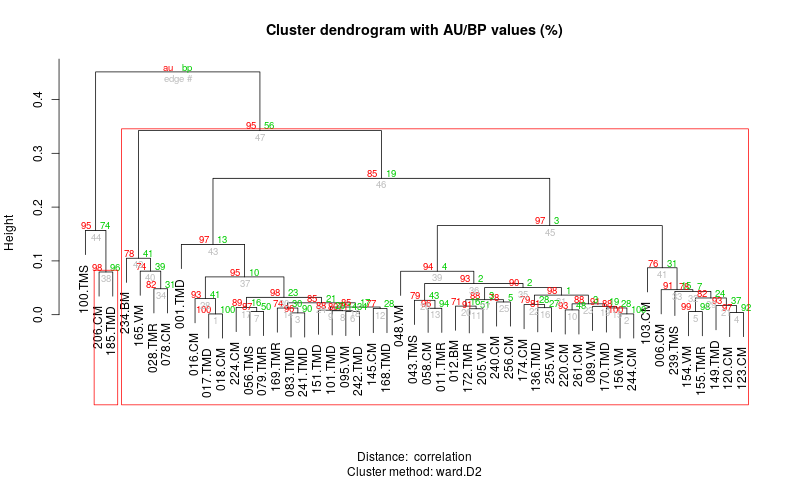

In [227]:
%%R -w 800
significant_counts = pathways_counts[
    rownames(get_significant_pathways(sets_reactome_entrez)),
]

patients_clustering <- pvclust::pvclust(
    scale(significant_counts), parallel=T,
    method.hclust="ward.D2", method.dist="correlation"
)
plot(patients_clustering)
pvclust::pvrect(patients_clustering, alpha=0.95)

In [228]:
%%R
import::here(pvclust_heatmap, simple_clinical_annotation, .from='plots/complex_heatmap.R')

full_pathways_plot = function(counts_collapsed, pathways_collapsed, samples_clustering, main=NULL, major=NULL, minor=NULL) {
    title = compose_title(main, major, minor)
    pvclust_heatmap(
        counts_collapsed, samples_clustering, title,
        right_annotation=ComplexHeatmap::rowAnnotation(
            '-log(min(FDR))'=ComplexHeatmap::anno_barplot(
                -log(pathways_collapsed[,'FDR']),
                axis_param=list(side ='bottom'),
                width = unit(2, "cm")
            )
        ),
        column_names_rot=45,
    )
}

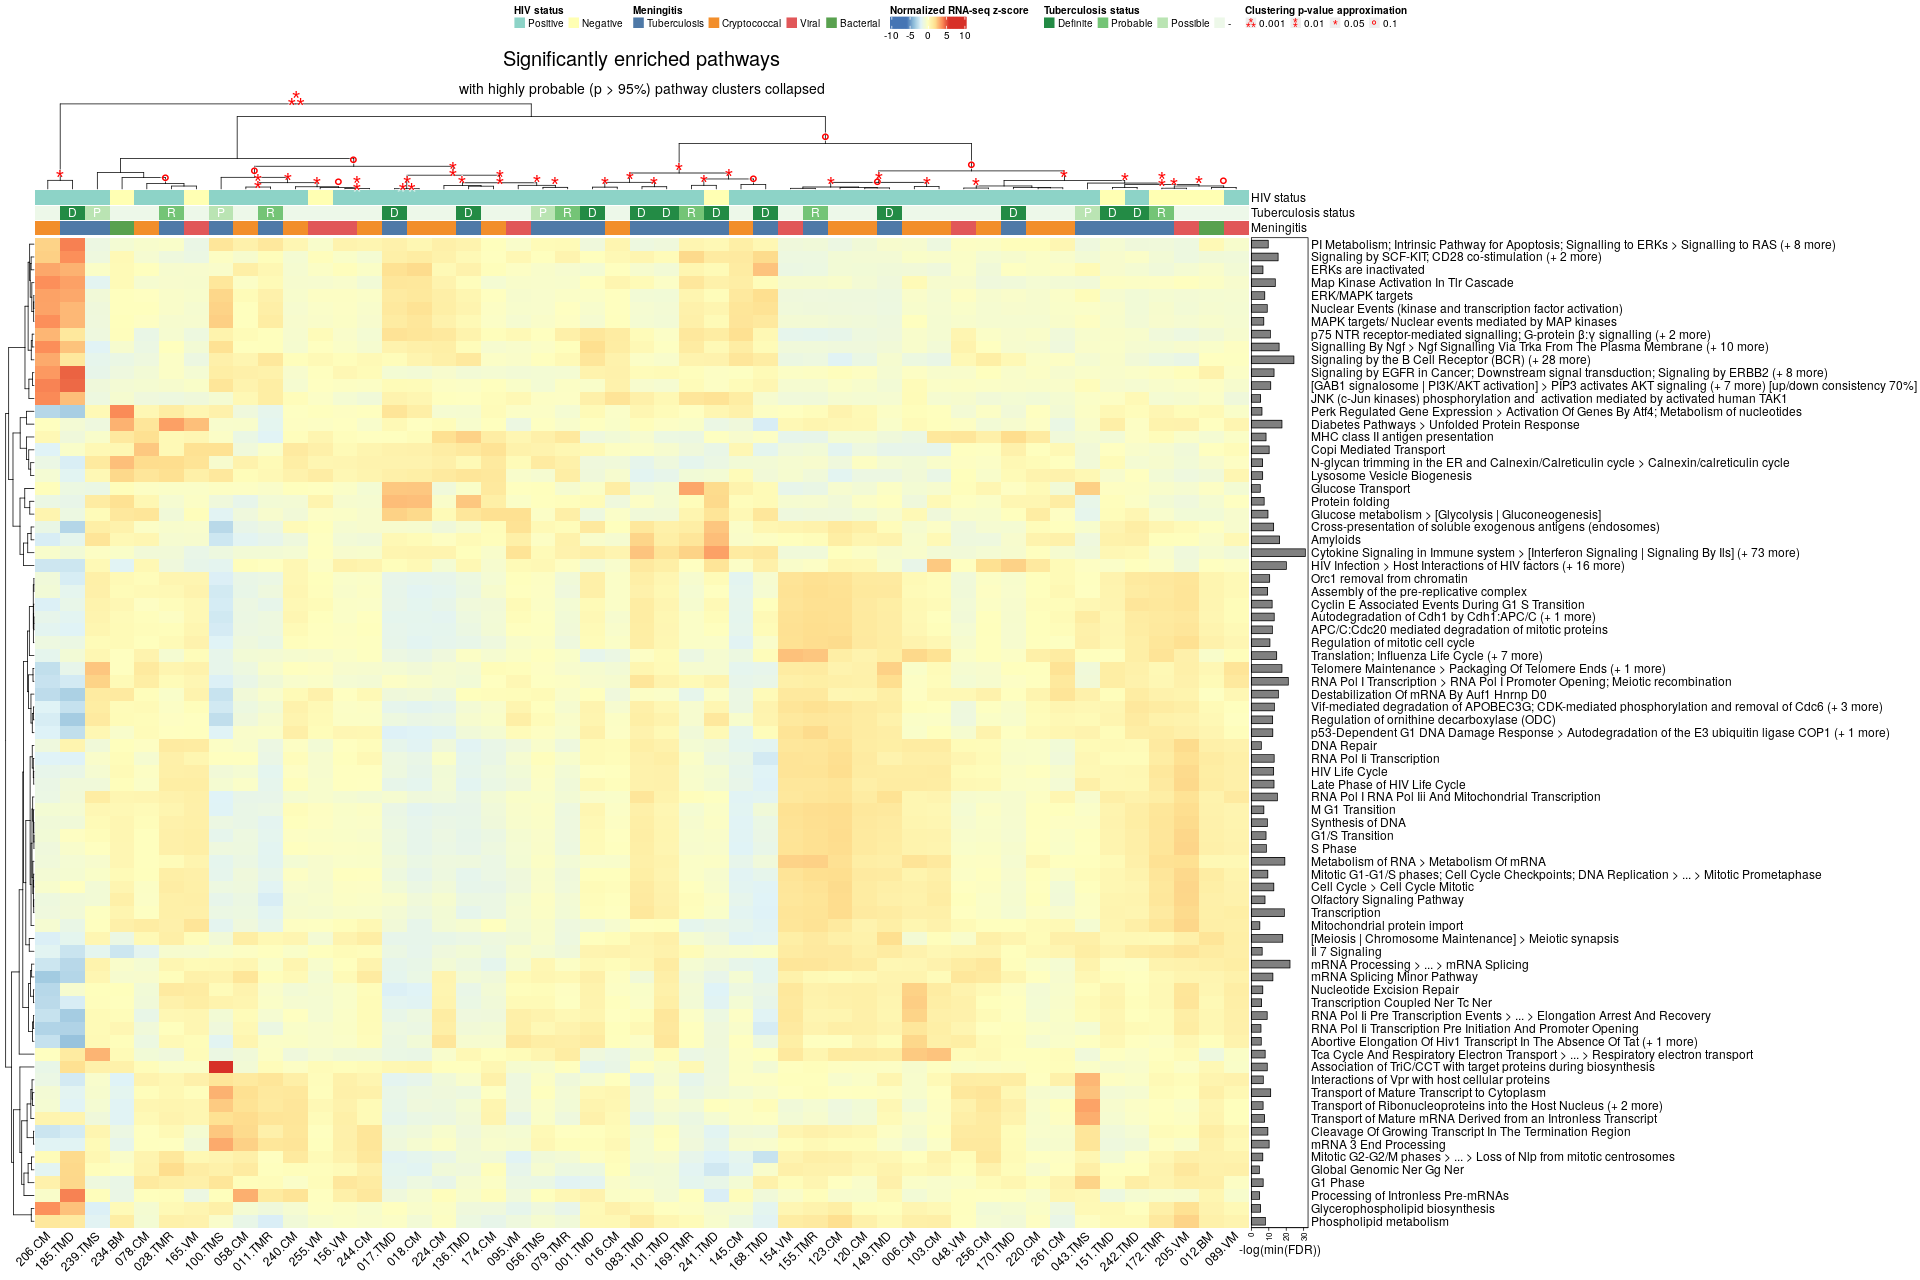

In [229]:
%%R -w 1920 -h 1280

full_pathways_plot(
    collapsed_voom_reactome_entrez$counts,
    pathways_collapsed=collapsed_voom_reactome_entrez$ranking,
    samples_clustering=collapsed_patients_clustering,
    major='Significantly enriched pathways',
    minor='with highly probable (p > 95%) pathway clusters collapsed'
)

In [230]:
%%R
save_plot = function(plot, path, width=800, height=1000, units='px', device=png, ...) {
    dev.off()
    device(path, width=width, height=height, units=units)
    plot()    
}

run_limma_pathways_analysis = function(
    with_de_params, collection, id_type, analysis_name, contrast_id, counts, contrast_samples, include_filtered=T,
    collapse_pathways=FALSE
) {
    
    analysis_id = tolower(sub(' ', '_', analysis_name))
    
    path = paste0(voom_path, 'pathways/')
    dir.create(file.path(voom_path, 'pathways'), showWarnings = FALSE)

    dir.create(file.path(path, analysis_id), showWarnings = FALSE)
    path = paste0(path, analysis_id, '/')
    
    # this uses standard t-statistic, so no effect from the independent weighting
    voom_de_gene_sets = with_de_params(calc_camera, collection=collection, convert_to=id_type)
    
    voom_de_gene_sets$AveExpr = average_pathways_expression(
        counts, collection=collection, id_type,
        pathways_subset=rownames(voom_de_gene_sets),
    )
    write.csv(voom_de_gene_sets, paste0(path, analysis_id, '_', contrast_id, '.csv'))

    if(include_filtered) {   
        voom_de_gene_sets_filtered = add_p_value_for_filtered_subset(voom_de_gene_sets, fdr_threshold=0.05, expression_col='AveExpr', pvalue_col='PValue')
        write.csv(voom_de_gene_sets_filtered, paste0(path, analysis_id, '_pathways_filtered-', contrast_id, '.csv'))
    }
    
    top_pathways_heatmap = save_plot(
        plot=function() { gene_set_heatmap(
            head(voom_de_gene_sets, 50), counts, collection=collection, id_type=id_type,
            main=paste0(a, ' - ', b, ' top 50 pathways, showing all samples (', analysis_name, ', voom)'),
            trim=55
        ) },
        path=paste0(path, analysis_id, '_top_50_heatmap-', contrast_id, '.png'),
        width=900*1.2, height=1200*1.2
    )
    
    analysed_patients = names(contrast_samples[!contrast_samples])
    
    top_pathways_heatmap_analysed_contrast_only = save_plot(
        plot=function() { gene_set_heatmap(
            head(voom_de_gene_sets, 50), counts, collection=collection, id_type=id_type,
            main=paste0(a, ' - ', b, ' top 50 pathways (', analysis_name, ', voom)'),
            trim=55, skip_cols=c(outliers, analysed_patients)
        ) },
        path=paste0(path, analysis_id, '_top_50_heatmap-analysed_contrast_only-', contrast_id, '.png'),
        width=900*1.2, height=1200*1.2
    )
    
    pathways_counts = counts_to_pathways_space(counts, collection=collection, id_type=id_type)
    significant_counts = pathways_counts[rownames(get_significant_pathways(voom_de_gene_sets)),]
    significant_counts = log2(significant_counts + 0.25)
    
    if (nrow(significant_counts) == 0) {
        print(paste('Skipping: no significant pathways for', a, '-', b, analysis_name))
        return(NULL)
    }
    
    # more conservative
    patients_clustering <- pvclust::pvclust(
        scale(significant_counts), parallel=T,
        method.hclust="ward.D2", method.dist="correlation"
    )

    # better for full reactome which has a high degree of pathways redundance
    # but if may cluster too much sometimes
    #unbiased_patients_clustering <- pvclust::pvclust(
    #    scale(counts_collapsed), parallel=T,
    #    method.hclust="ward.D2", method.dist="correlation"
    #)

    save_plot(
        plot=function(){
            plot(
                patients_clustering,
                main=paste0(a, ' - ', b, ' based on significant pathways (', analysis_name, ', voom)')
            )
            pvclust::pvrect(patients_clustering, alpha=0.95)
        },
        path=paste0(path, analysis_id, '_based_clustering-', contrast_id, '.png'),
        width=900*1.2, height=500*1.2
    )
    
    if(collapse_pathways) {
        collapsed = collapse_by_clusters_and_topology(
            counts, get_significant_pathways(voom_de_gene_sets, 0.01),
            collection=collection, id_type=id_type,
            nboot=1000
        )
        save_plot(
            plot=function() {
                full_pathways_plot(
                    collapsed$counts,
                    pathways_collapsed=collapsed$ranking,
                    samples_clustering=patients_clustering,
                    major=paste0(a, ' - ', b, ' significant ($FDR < 0.01$) pathways (', analysis_name, ', voom)'),
                    minor='with highly probable ($p > 95%$) pathway clusters collapsed, showing all samples'
                )
            },
            path=paste0(path, analysis_id, '_heatmap-', contrast_id, '.png'),
            width=1920, height=250 + 15 * nrow(collapsed$counts)
        )

        skip_cols=c(outliers, analysed_patients)
        significant_counts = significant_counts[,!(colnames(significant_counts) %in% skip_cols)]
        counts = counts[,!(colnames(counts) %in% skip_cols)]
        patients_clustering <- pvclust::pvclust(
            scale(significant_counts), parallel=T,
            method.hclust="ward.D2", method.dist="correlation"
        )
        collapsed = collapse_by_clusters_and_topology(
            counts, get_significant_pathways(voom_de_gene_sets, 0.01),
            collection=collection, id_type=id_type,
            nboot=1000
        )
        
        save_plot(
            plot=function() {
                full_pathways_plot(
                    collapsed$counts,
                    pathways_collapsed=collapsed$ranking,
                    samples_clustering=patients_clustering,
                    major=paste0(a, ' - ', b, ' significant ($FDR < 0.01$) pathways (', analysis_name, ', voom)'),
                    minor='with highly probable ($p > 95%$) pathway clusters collapsed'
                )
            },
            path=paste0(path, analysis_id, '_heatmap-analysed_contrast_only-', contrast_id, '.png'),
            width=1920, height=250 + 15 * nrow(collapsed$counts)
        )
        
    }

}

In [ ]:
%%R -i results_path
# TODO: redirect output to a log file
stop('This analysis step takes too long to be included in automated builds')

conditions = unique(by_condition_and_tb_subset_no_outliers)

voom_path = paste0(results_path, 'voom_tmm/')

combinations = combn(conditions, 2, simplify=F)
i = 0

for(combination in combinations) {
    print(paste0('Progress: ', 100 * i / length(combinations), '%'))
    i = i + 1
    
    a = combination[1]
    b = combination[2]

    contrast_samples = by_condition_and_tb_subset_no_outliers == a | by_condition_and_tb_subset_no_outliers == b
    skip_cols = c(outliers, names(contrast_samples[!contrast_samples]))

    contrast_id = paste(a, b, sep='_vs_')
    
    # voom with quality sample weights, robust, TMM normalization
    # outlier samples defined as |z-score| > 2 removed,
    # independent weighting of hypotheses with IHW using mean expression as the independent hypothesis
    
    with_de_params = function(func, ...) {
        func(a, b, tmm_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T, ...)
    }
    
    voom_de = with_de_params(calc_de, confint=T)
    voom_de = add_p_value_for_weighted_hypothesis(voom_de)

    path = paste0(voom_path, 'genes/')
    dir.create(file.path(voom_path, 'genes'), showWarnings = FALSE)
    
    write.csv(voom_de, paste0(path, 'voom-', contrast_id, '.csv'))
    
    significant_count = nrow(significant.limma(voom_de))
    print(significant_count)

    significant_genes_heatmap = save_plot(
        plot=function() {
            de_heatmap(
                significant.limma(voom_de), tmm_normalized_tb_subsets,
                major=paste(a, '-', b, 'limma-voom differentially expressed genes'),
                minor='TMM, quality weights, robust, IHW $FDR<0.05$, showing all samples'
            )
        },
        path=paste0(path, 'heatmap-', contrast_id, '.png'),
        width=1000, height=250 + 15 * significant_count
    )
    
    significant_genes_heatmap_analysed_contrast_only = save_plot(
        plot=function() {
            de_heatmap(
                significant.limma(voom_de), tmm_normalized_tb_subsets,
                major=paste(a, '-', b, 'limma-voom differentially expressed genes'),
                minor='TMM, quality weights, robust, IHW $FDR<0.05$',
                skip_cols=c(outliers, names(contrast_samples[!contrast_samples]))
            )
        },
        path=paste0(path, 'heatmap-analysed_contrast_only-', contrast_id, '.png'),
        width=1000, height=250 + 15 * significant_count
    )
    
    
    # Pathways for msigdb
    run_limma_pathways_analysis(
        with_de_params, contrast_id=contrast_id, counts=tmm_normalized_tb_subsets, contrast_samples=contrast_samples,
        analysis_name='MSigDB Reactome', collection=c2.cp.reactome, id_type='entrez',
        collapse_pathways=TRUE
    )
    
    # Same but for full Reactome    
    run_limma_pathways_analysis(
        with_de_params, contrast_id=contrast_id, counts=tmm_normalized_tb_subsets, contrast_samples=contrast_samples,
        analysis_name='Full Reactome', collection=reactome_new_symbol, id_type='symbol'
    )
}

Notes:
 - mRNA processing is highly correlated with HIV life cycle

## With aggregated TB samples

TODO

TODO: re-run protein!

TODO: recall citation for the fact that limma-trend gets less significant results and it is ok and what it means.

# Literature search

RNA-seq human cells 2015 Mbt against 6 other pathogens https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4653619/ also use limma+voom
(found with https://jhubiostatistics.shinyapps.io/recount/, search phrase tuberculosis)

In [ ]:
#!wget https://bitbucket.org/jdblischak/tb-data/raw/bc0f64292eb8c42a372b3a2d50e3d871c70c202e/table-s2.txt

In [ ]:
differential_expression_for_GSE67427 = read_table('table-s2.txt', index_col=0)
differential_expression_for_GSE67427.head()

- GC = Mycobacterium tuberculosis GC1237
- Rv = Mycobacterium tuberculosis (MTB) H37Rv
- Rv+ = heat-inactivated MTB H37Rv

In [ ]:
# absent
'ENSG00000269242' in differential_expression_for_GSE67427.index

In [ ]:
# significant_deseq2
# intersection_tmm
# show_table(differential_expression_for_GSE67427.loc[significant_deseq2].sort_values('GC.48.adj.P.Val'))

In [ ]:
def get_macrophage_differential_expression(prefix):
    return differential_expression_for_GSE67427.rename(columns=lambda x: x.replace(prefix + '.', ''))

In [ ]:
venn4({
    'TBM in CSF against CM: voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']),
    'TBM in CSF against CM: DESeq2': significant_deseq2,
    'TB GC 48h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('GC.48')),
    'TB RV 48h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('Rv.48'))
}, fill='percent');

In [ ]:
venn4({
    'TBM in CSF against CM: voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']),
    'TBM in CSF against CM: DESeq2': significant_deseq2,
    'TB GC 4h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('GC.4')),
    'TB RV 4h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('Rv.4'))
}, fill='percent');

In [ ]:
venn4({
    'TBM in CSF against CM: voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']),
    'TBM in CSF against CM: DESeq2': significant_deseq2,
    'Yers 48h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('Yers.48')),
    'Salm 48h in macrophages (against healthy): voom-TMM': significant_ensembl(get_macrophage_differential_expression('Salm.48'))
}, fill='percent');

Now, If I do TBM against everything and it improves the overlap percentage, we got (some kind of) an external validation!